In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [3]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

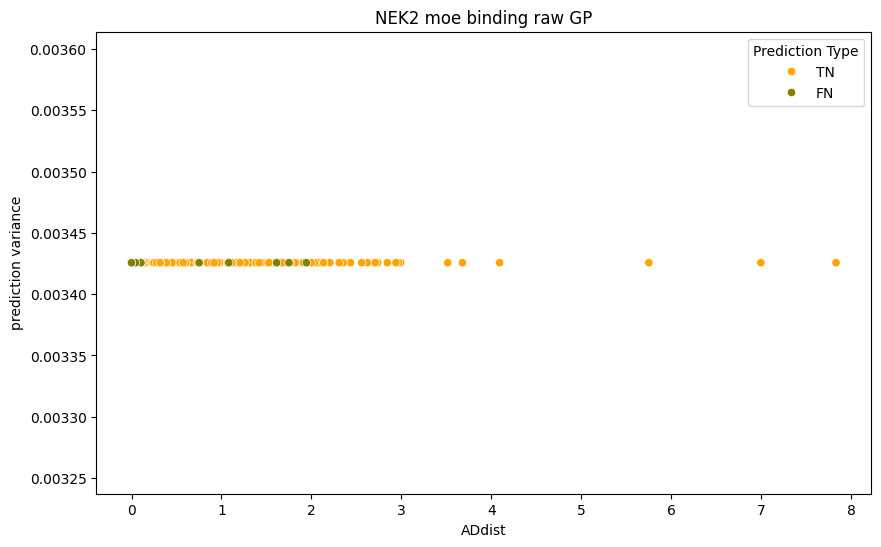

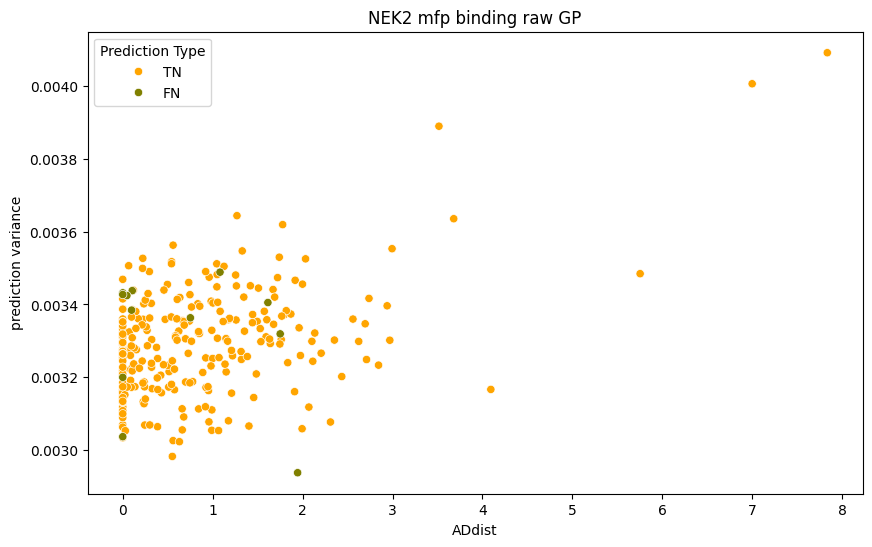

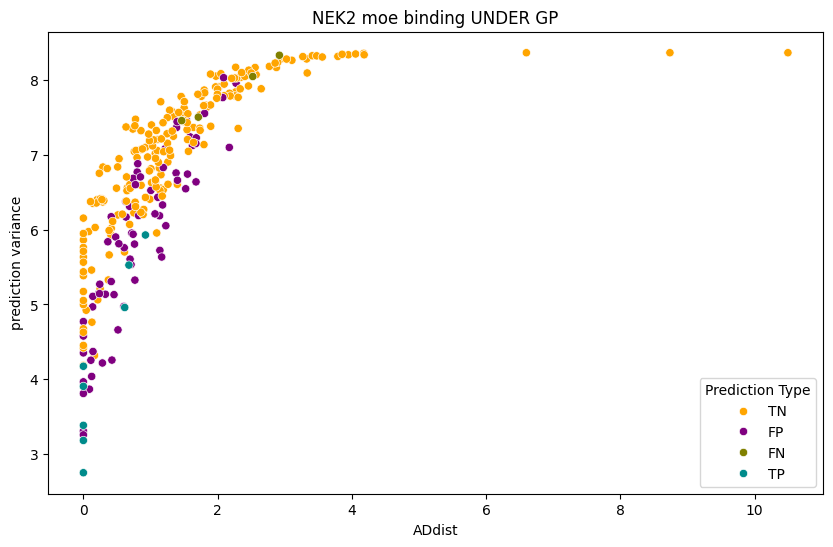

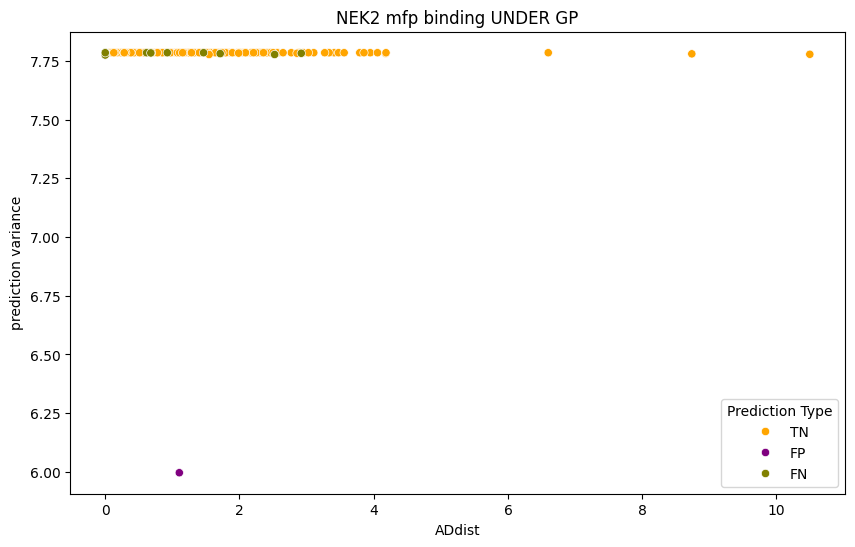

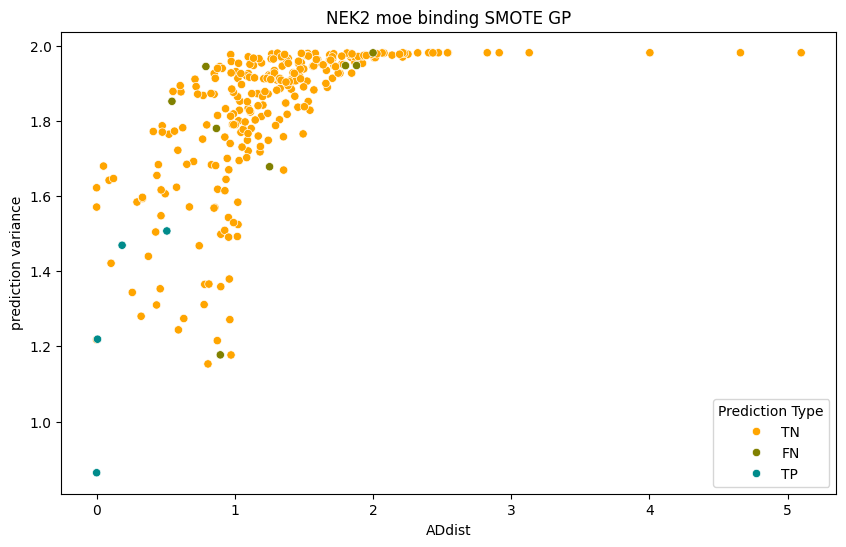

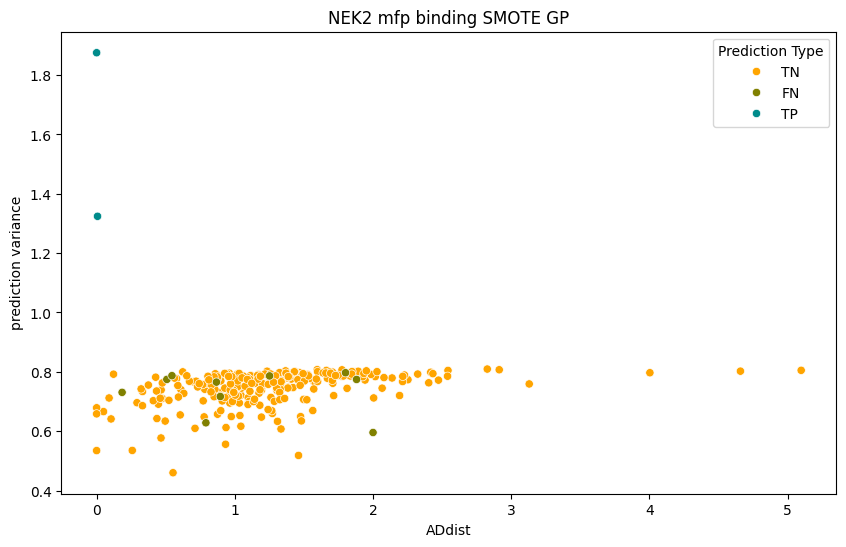

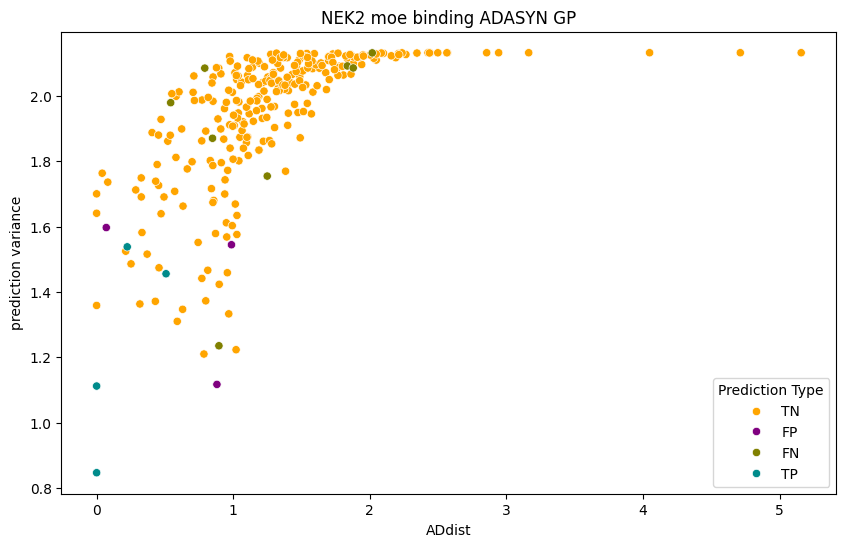

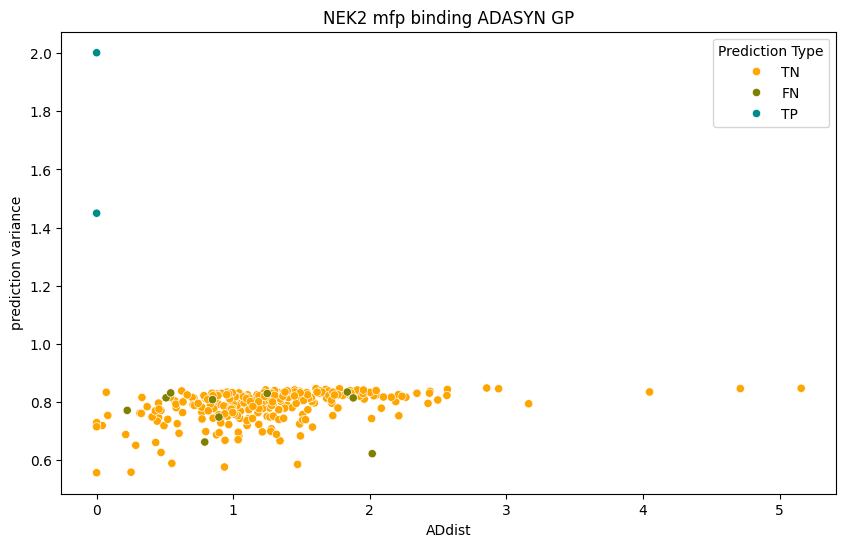

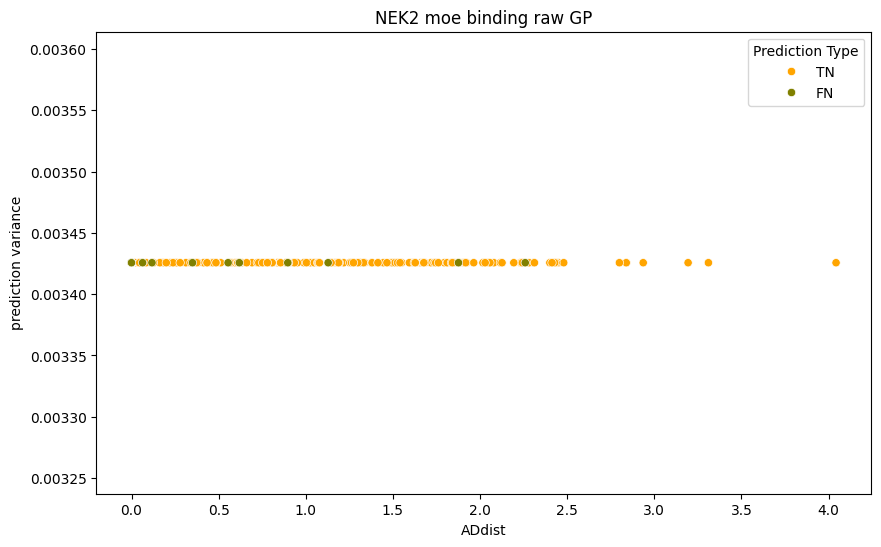

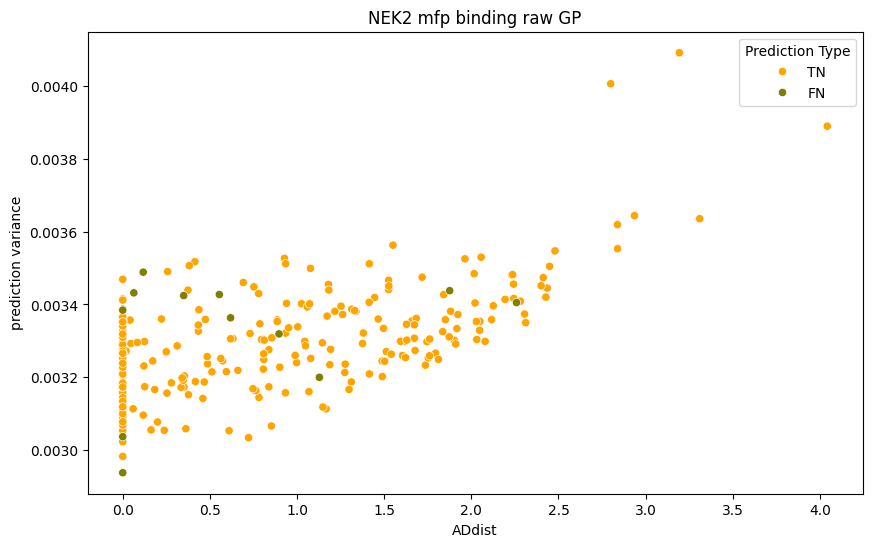

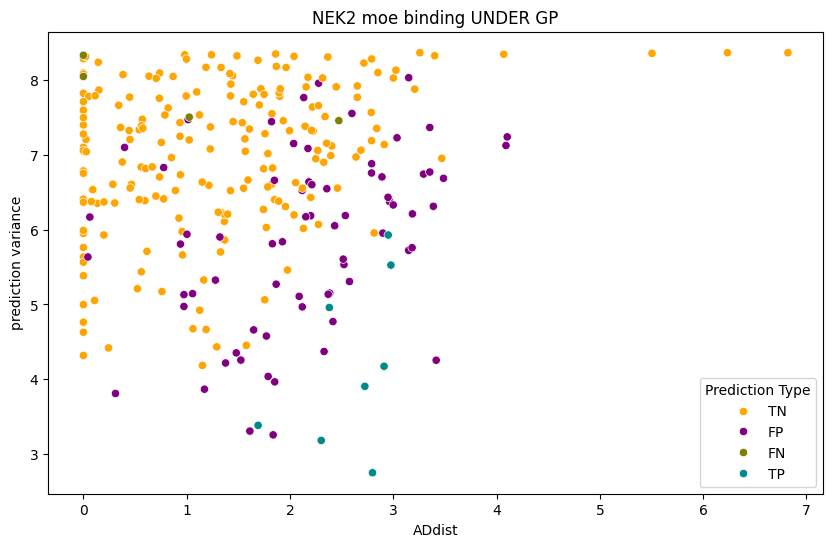

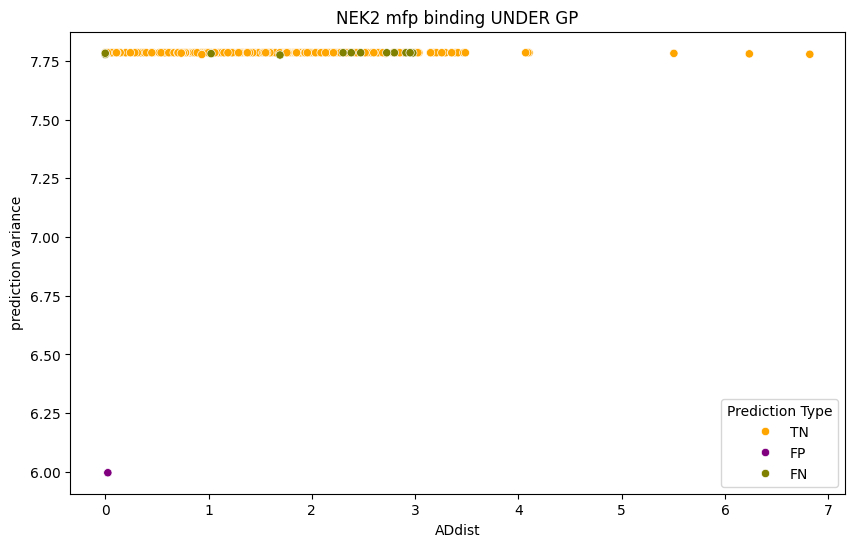

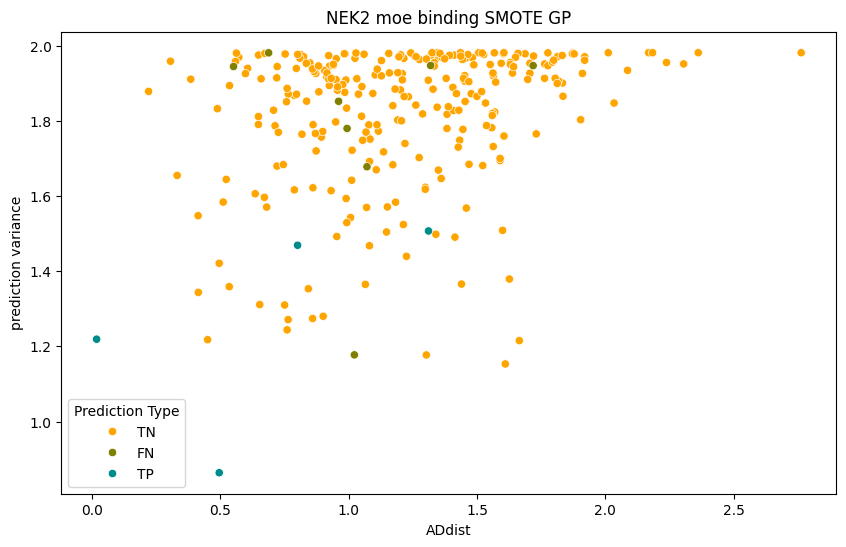

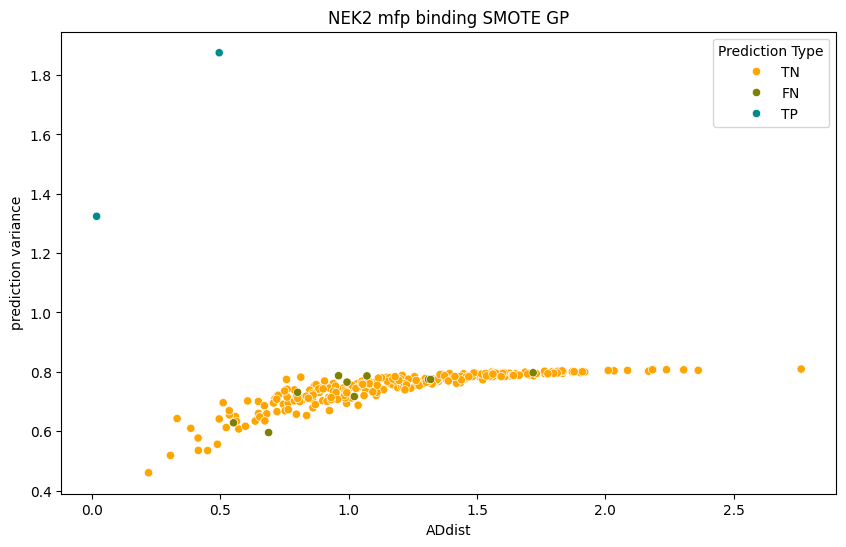

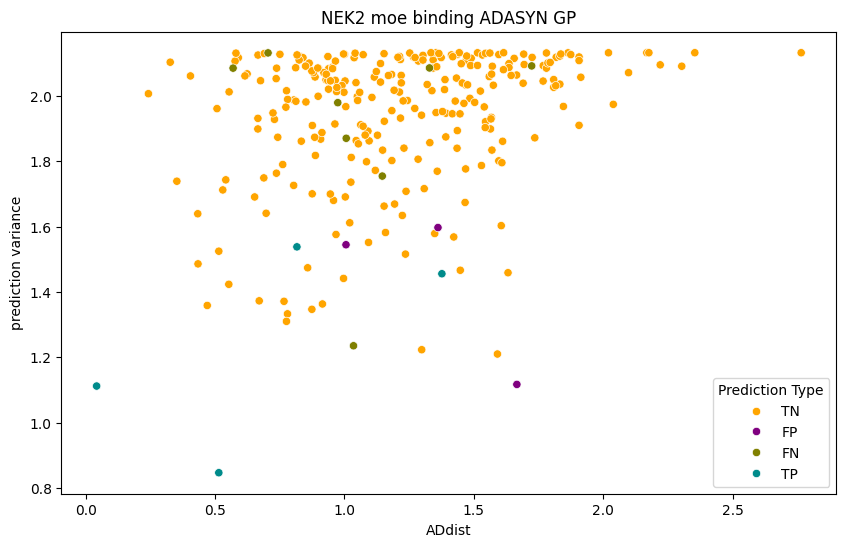

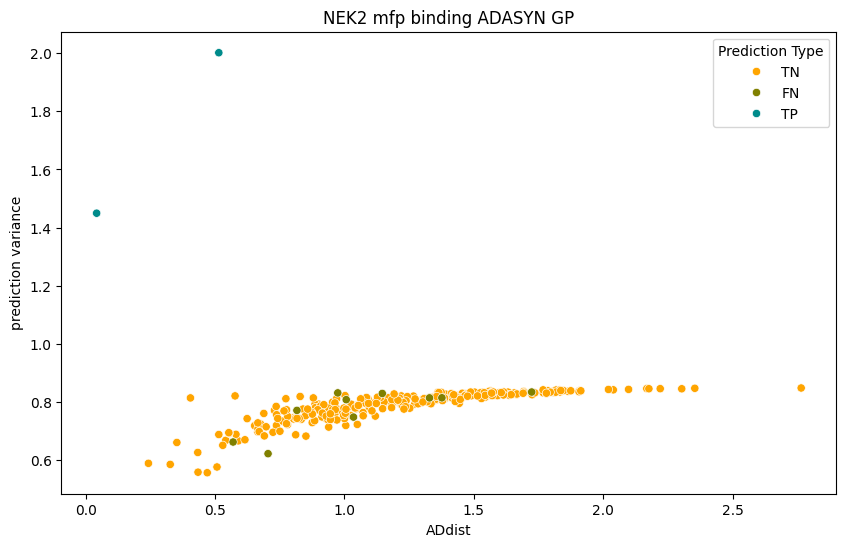

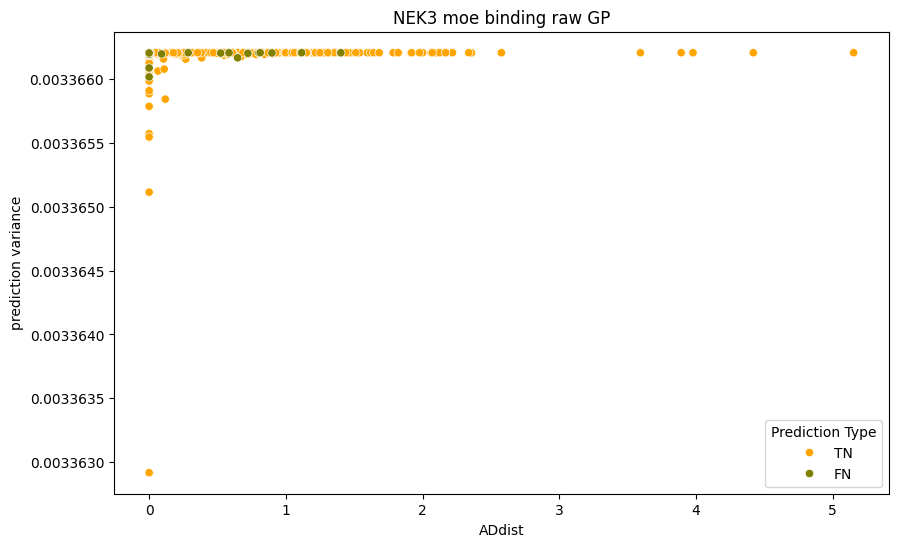

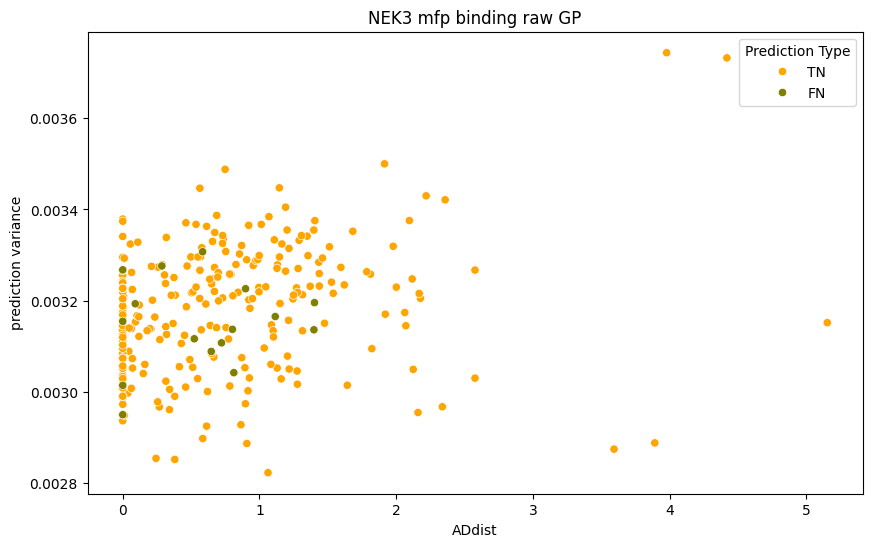

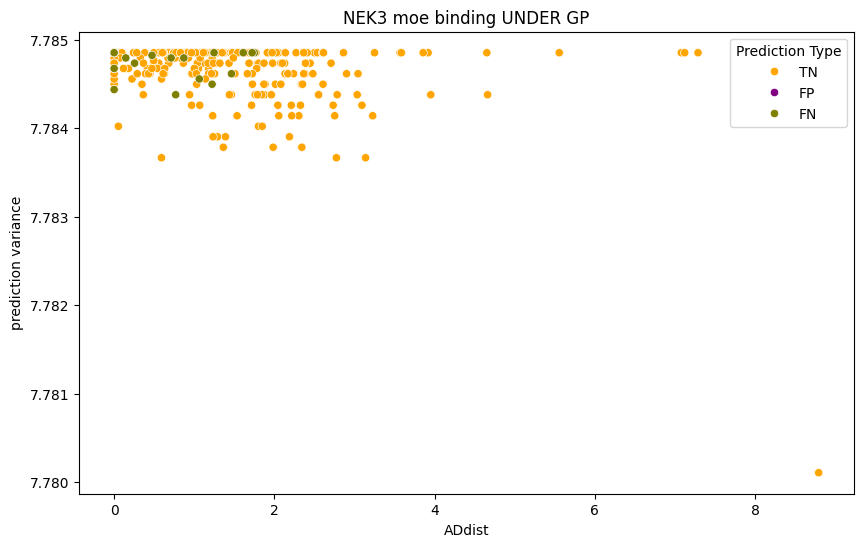

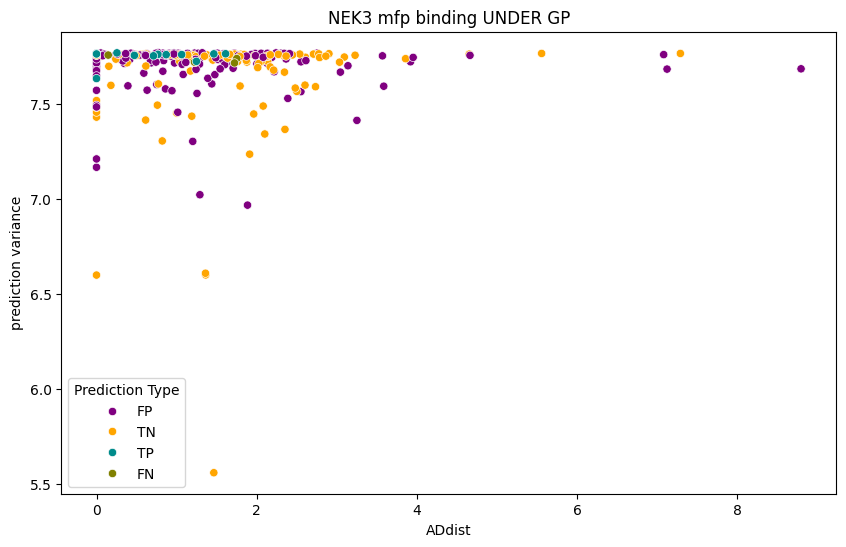

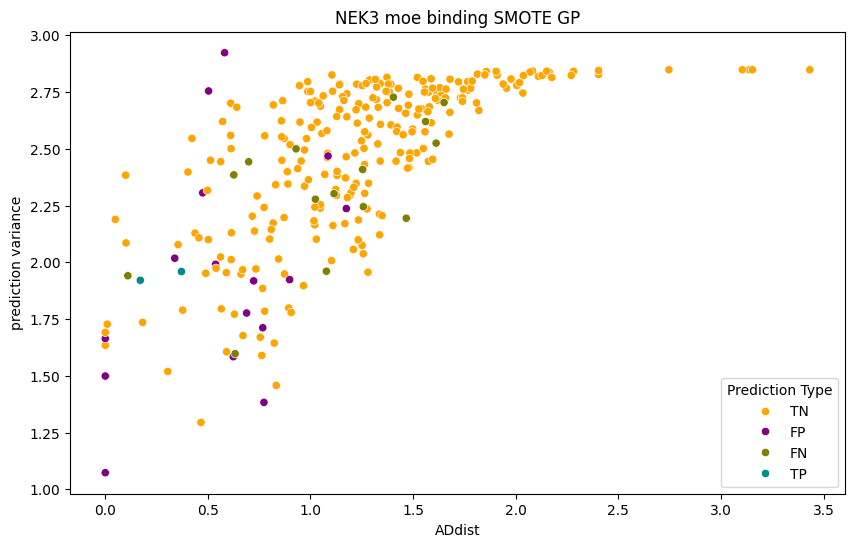

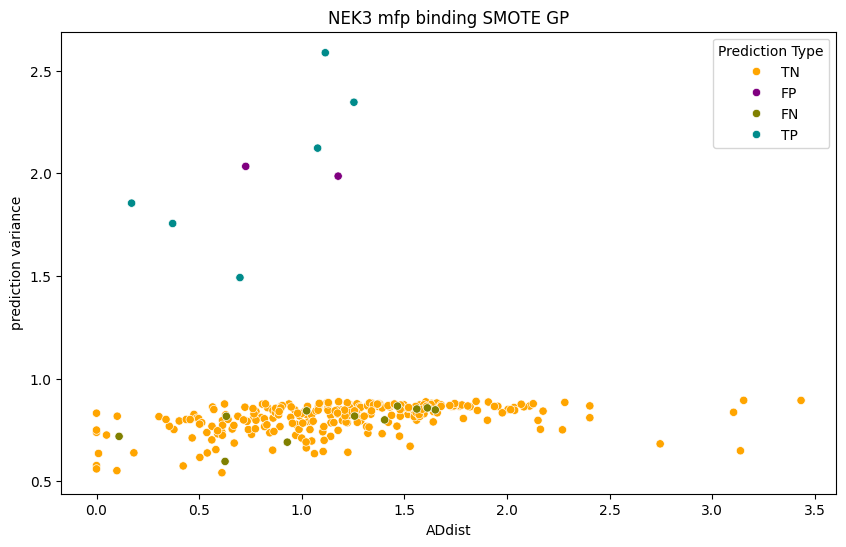

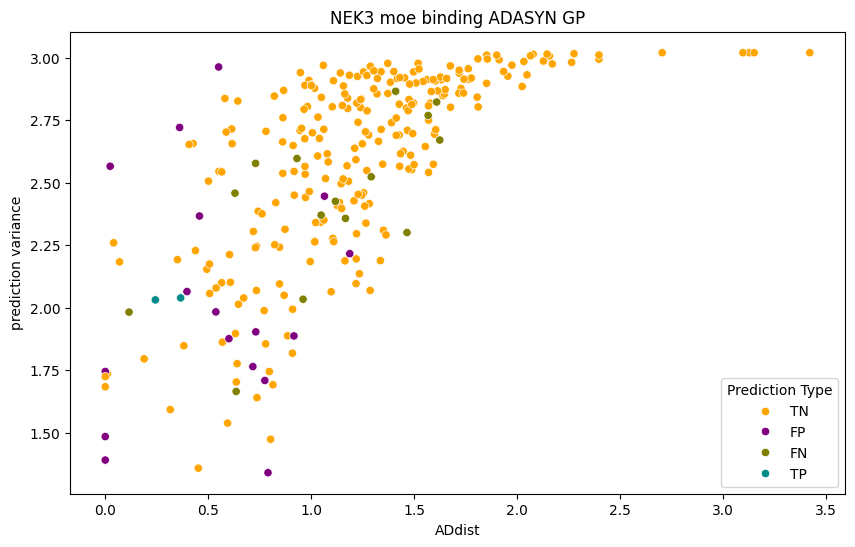

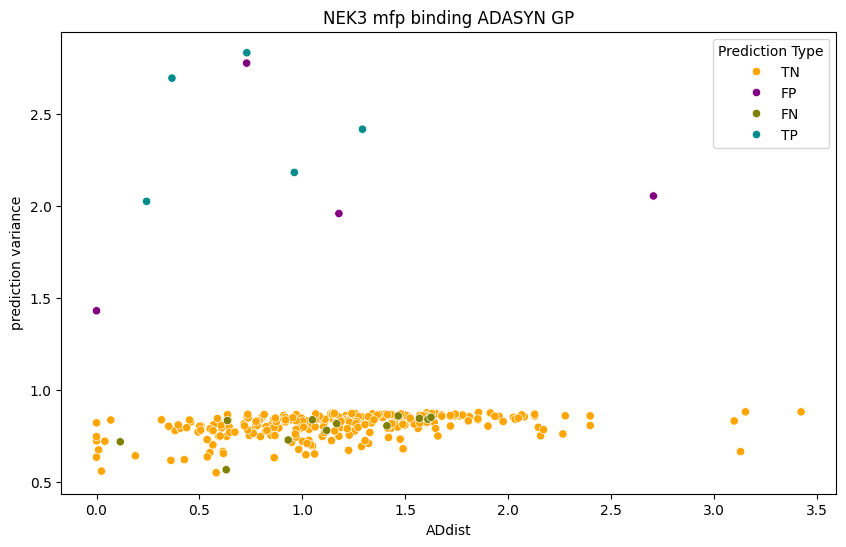

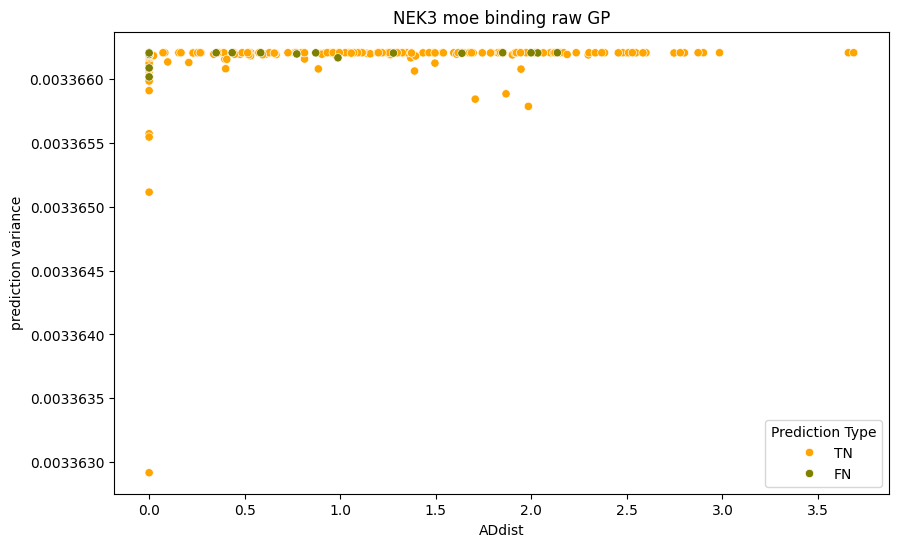

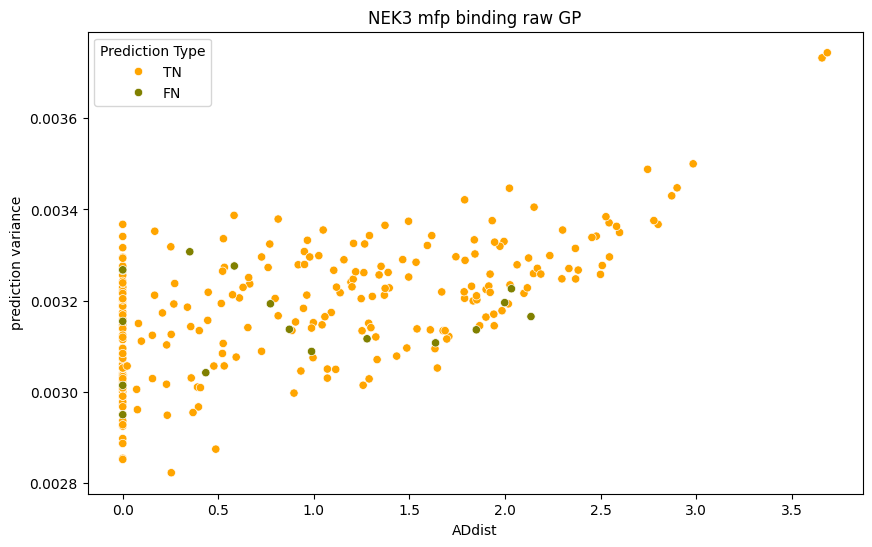

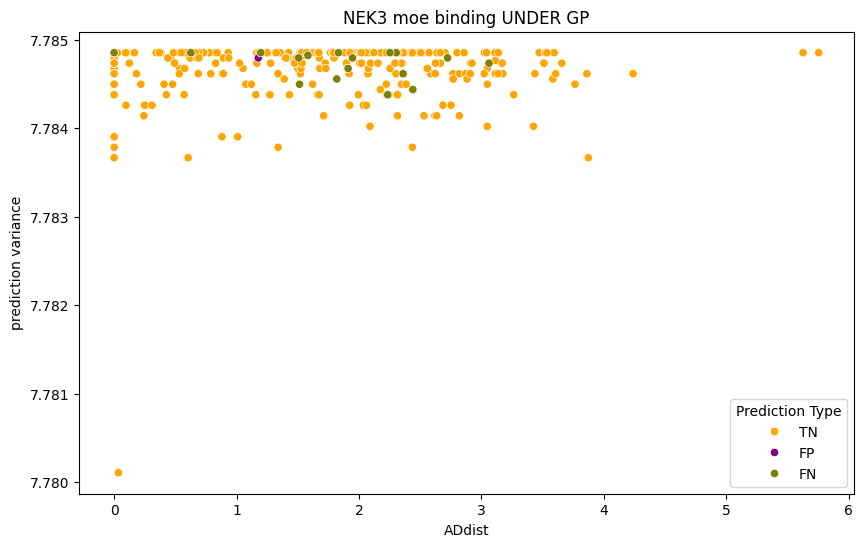

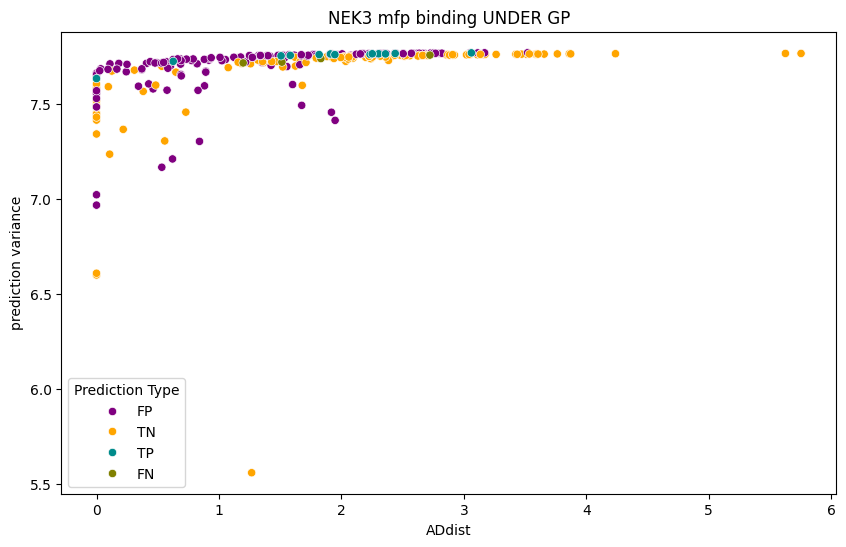

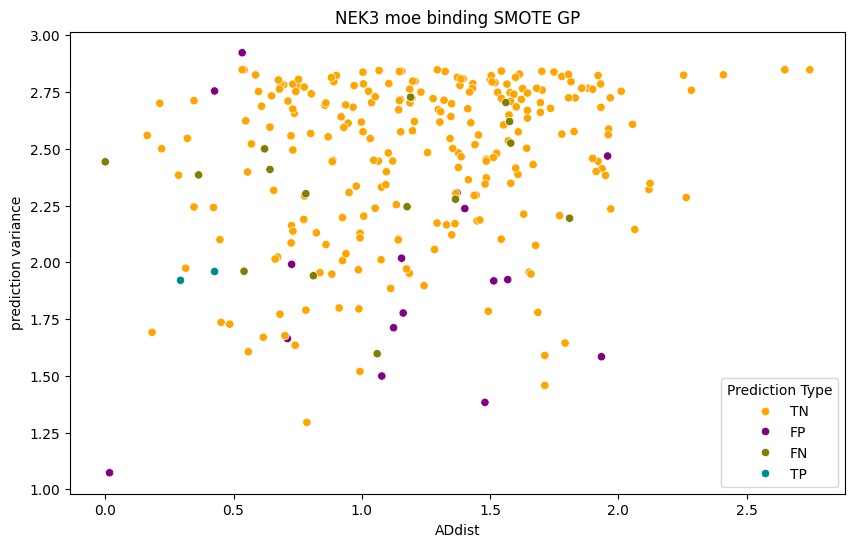

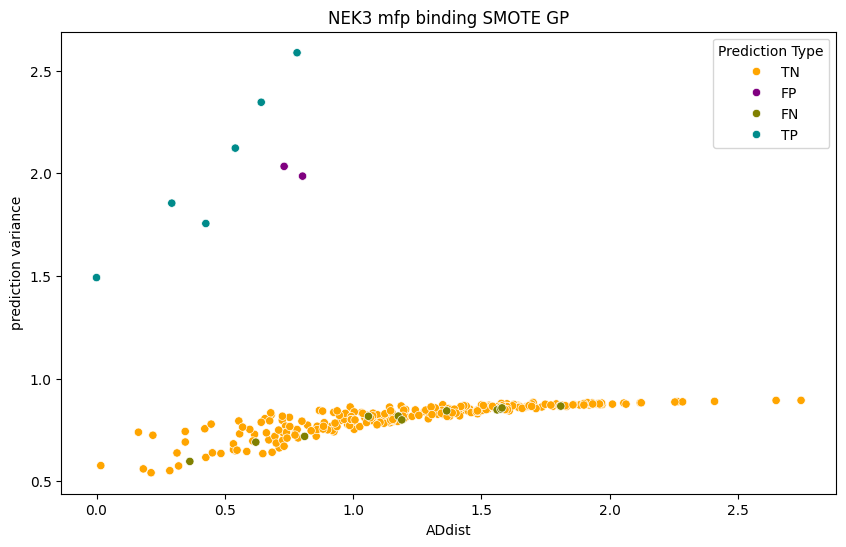

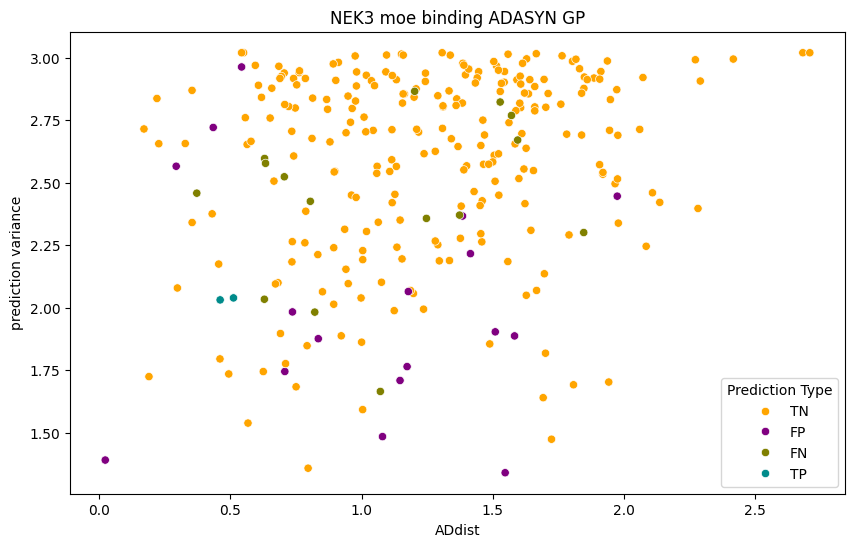

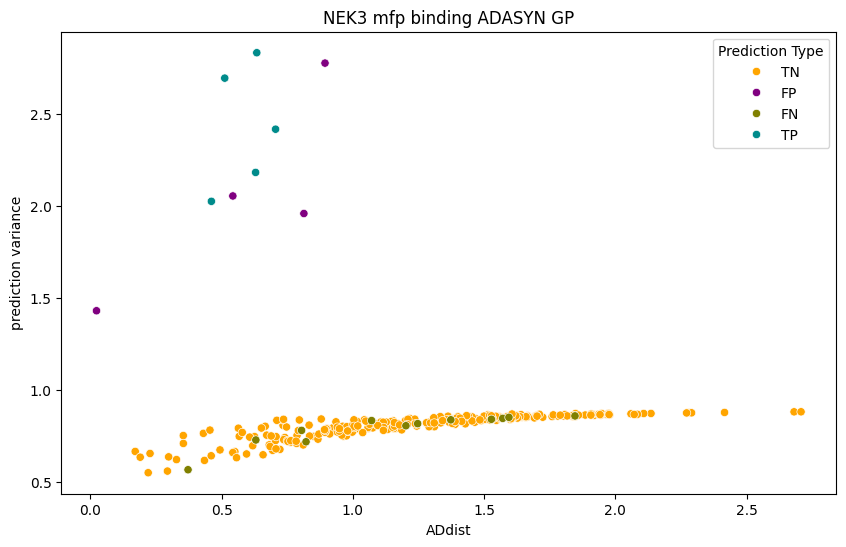

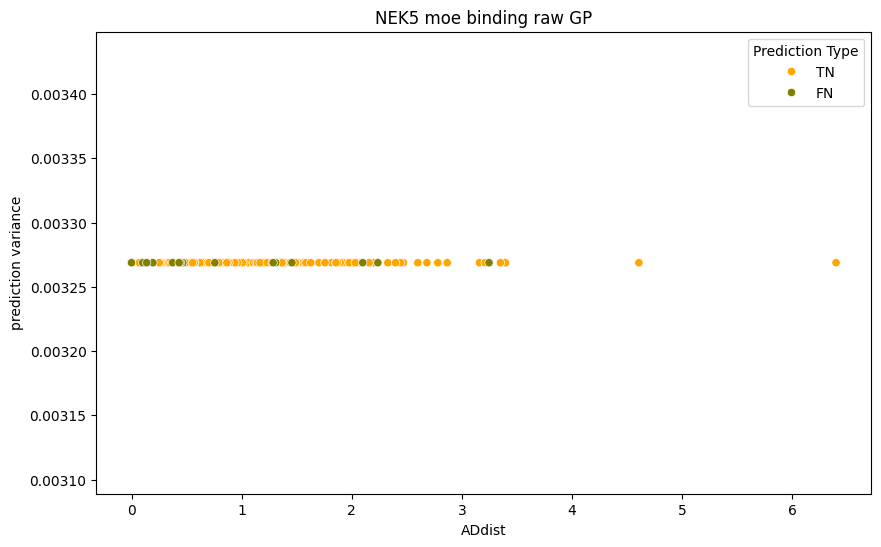

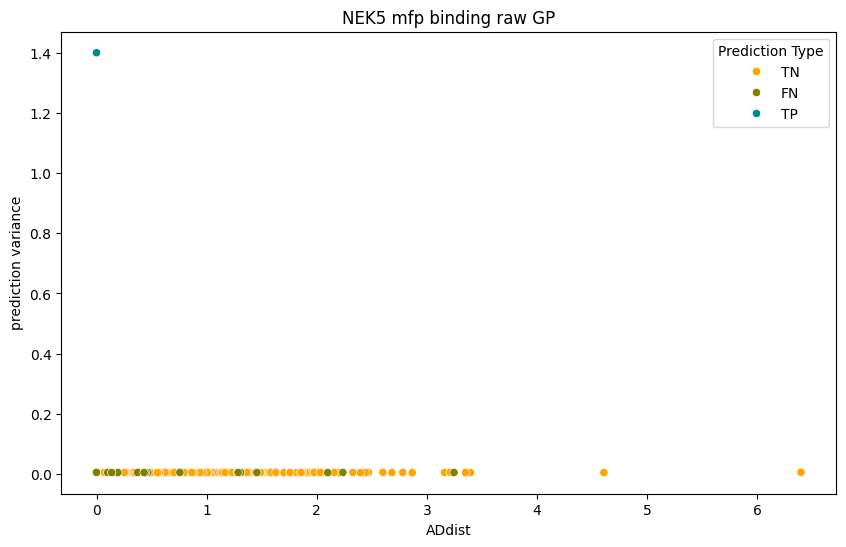

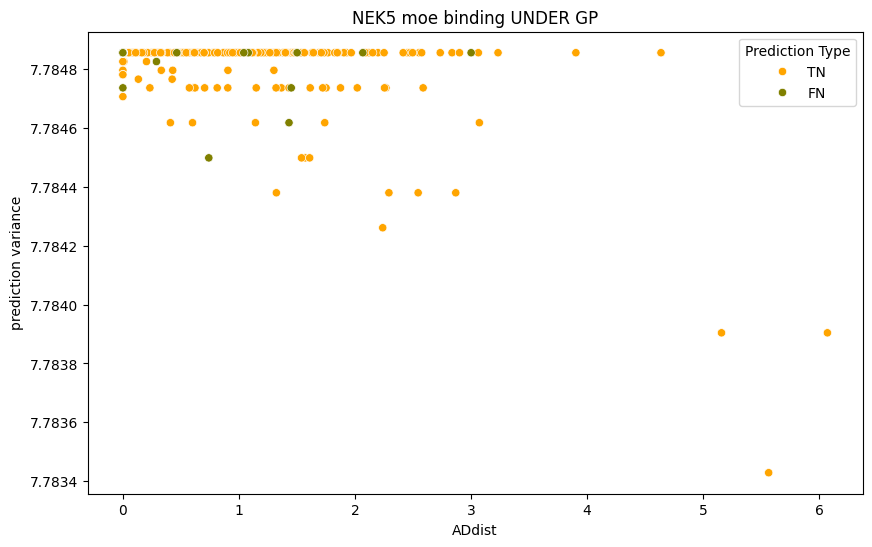

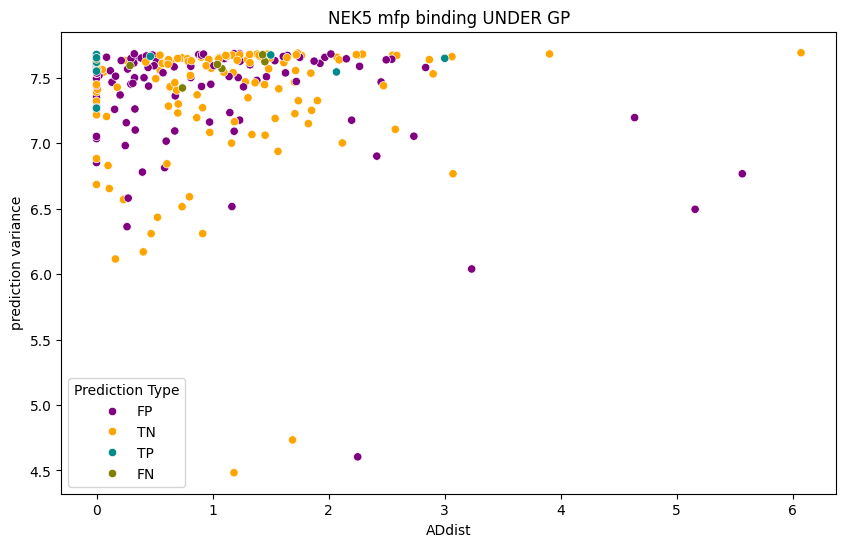

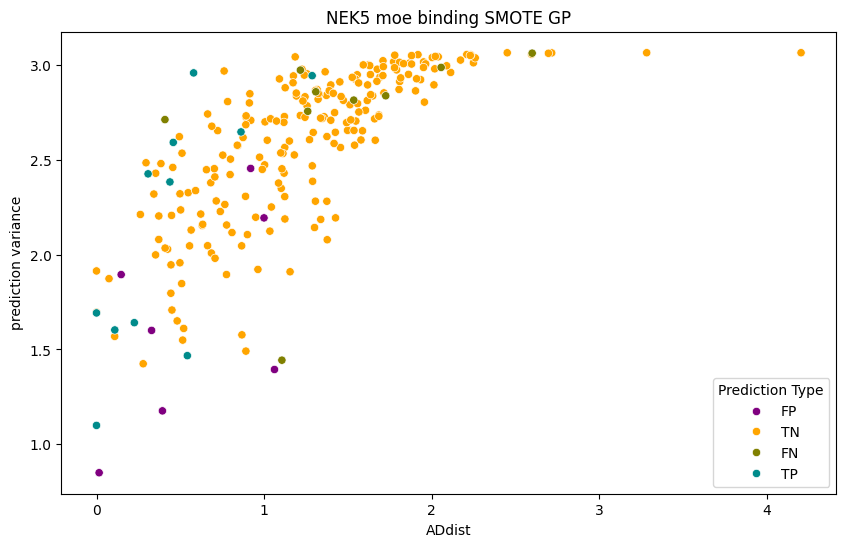

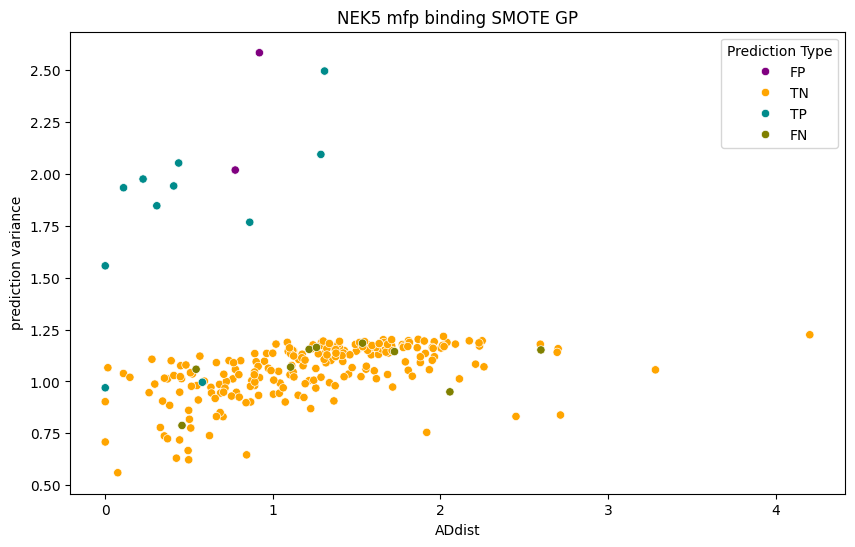

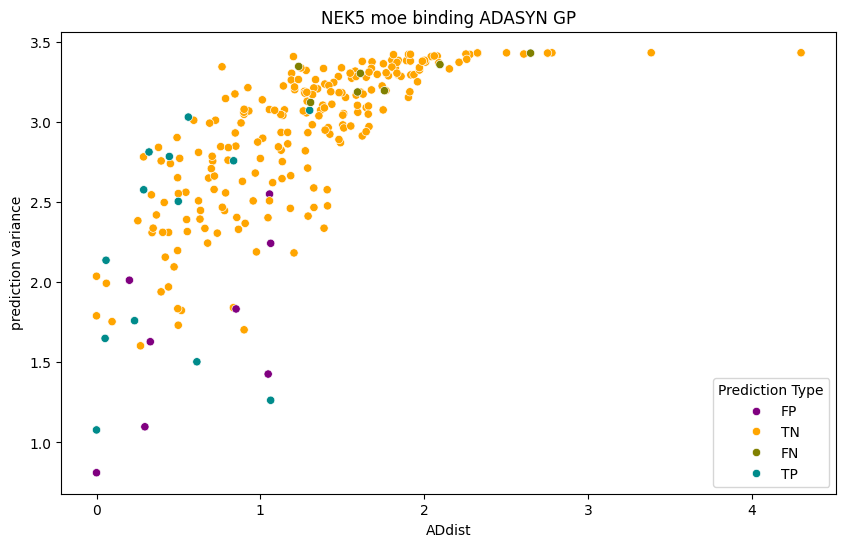

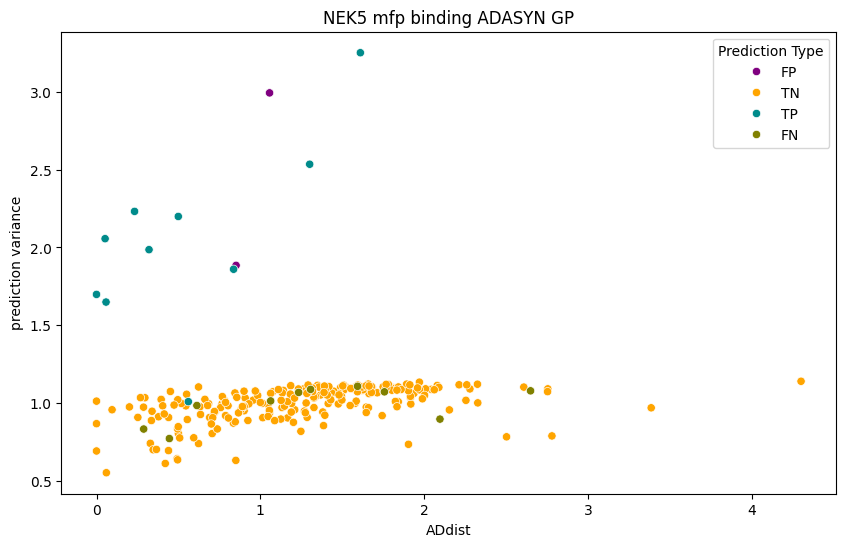

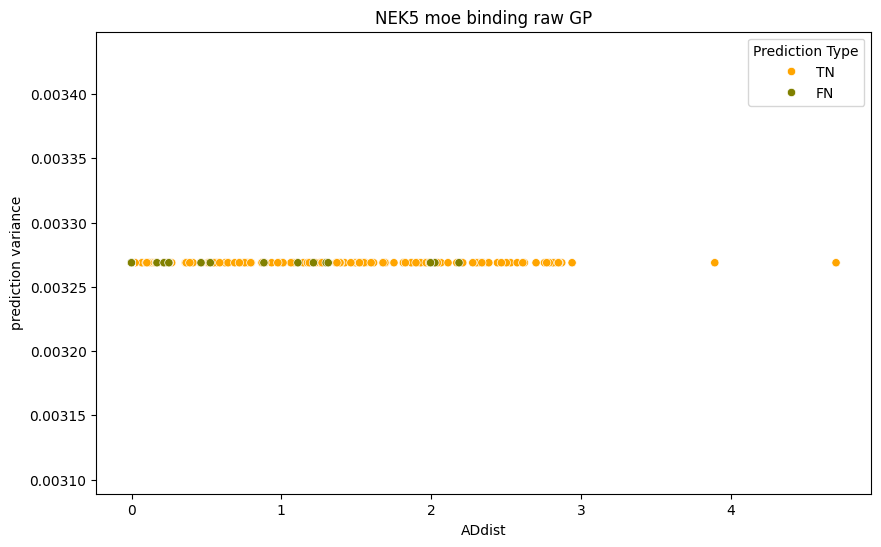

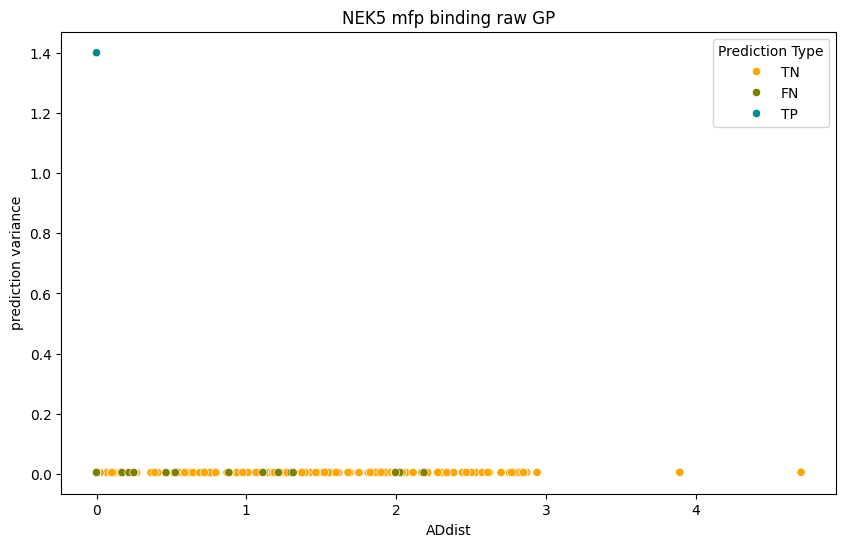

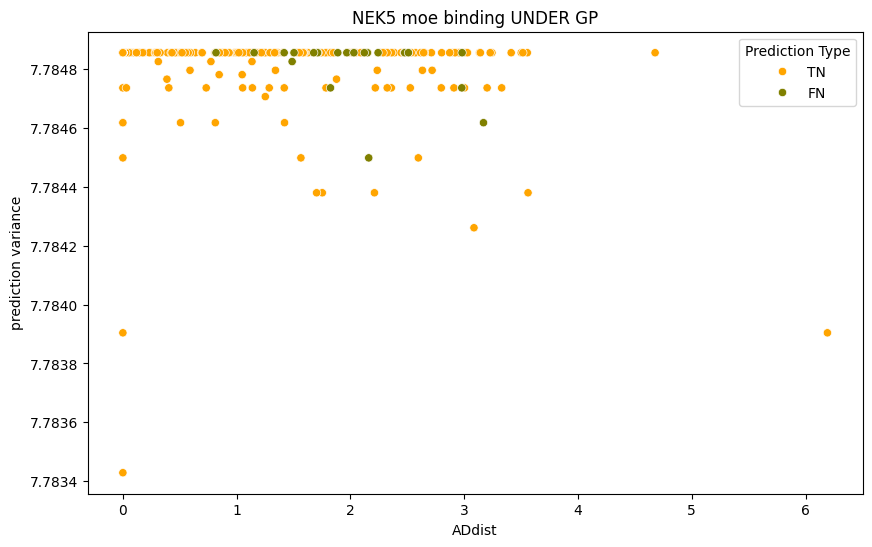

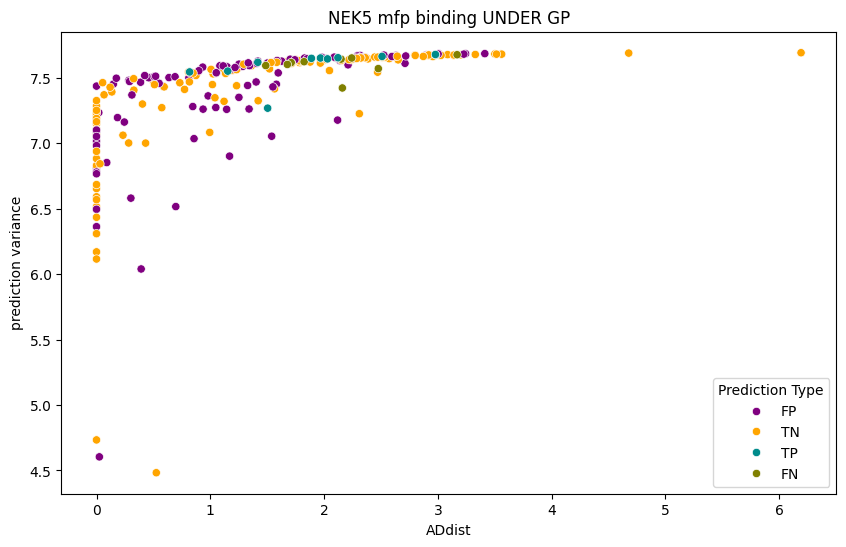

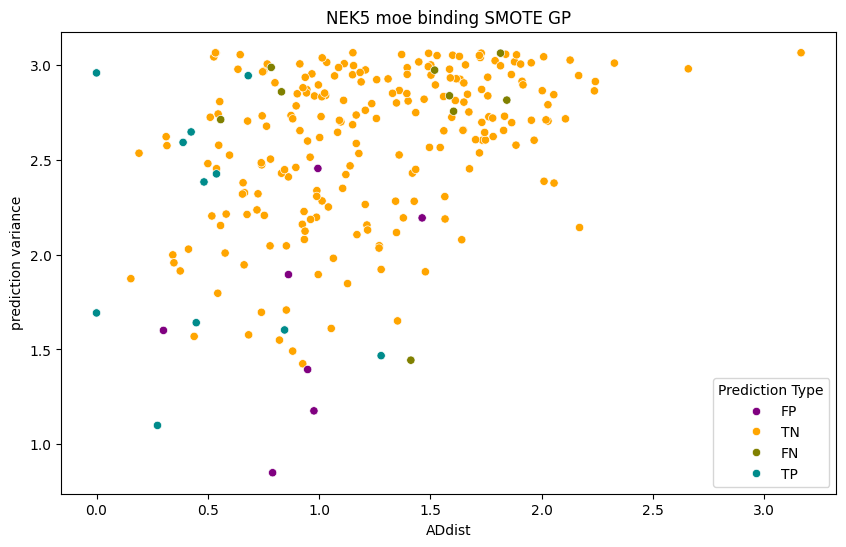

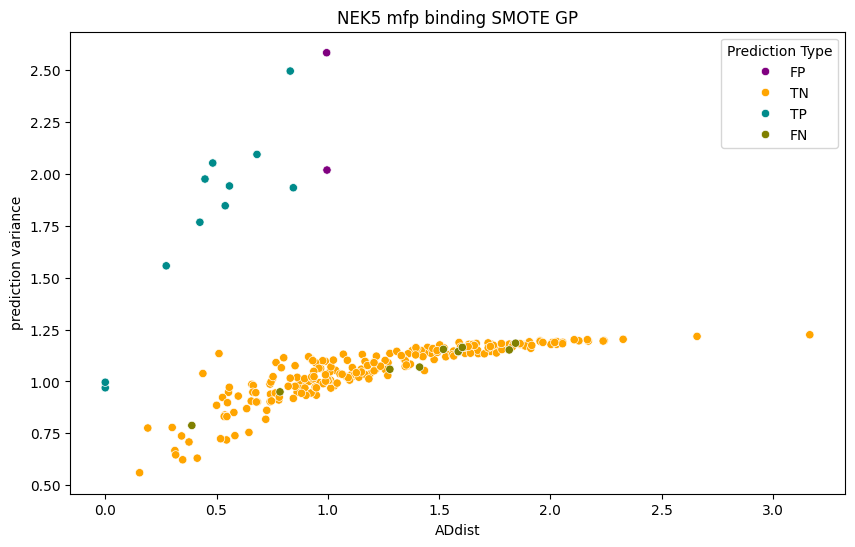

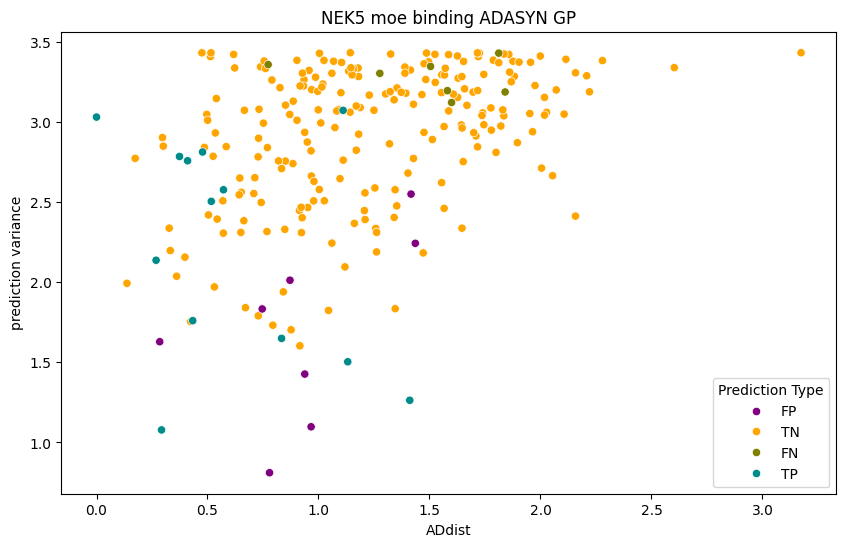

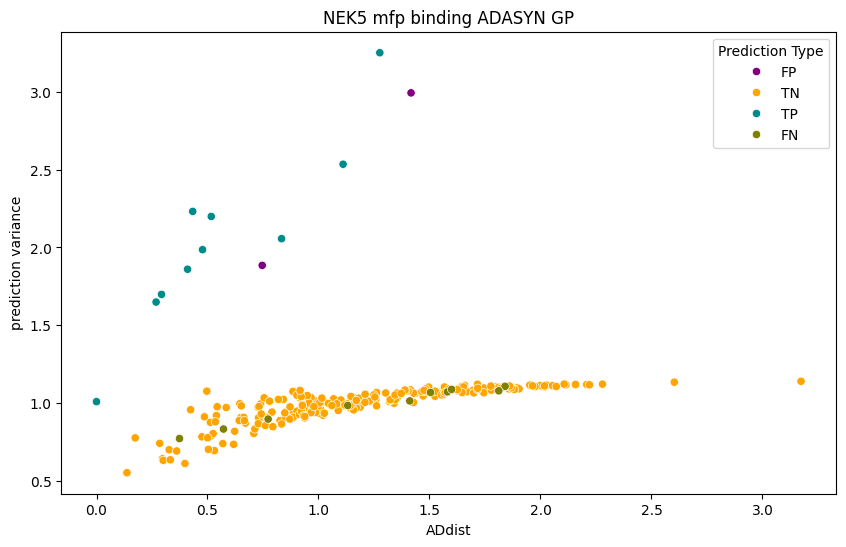

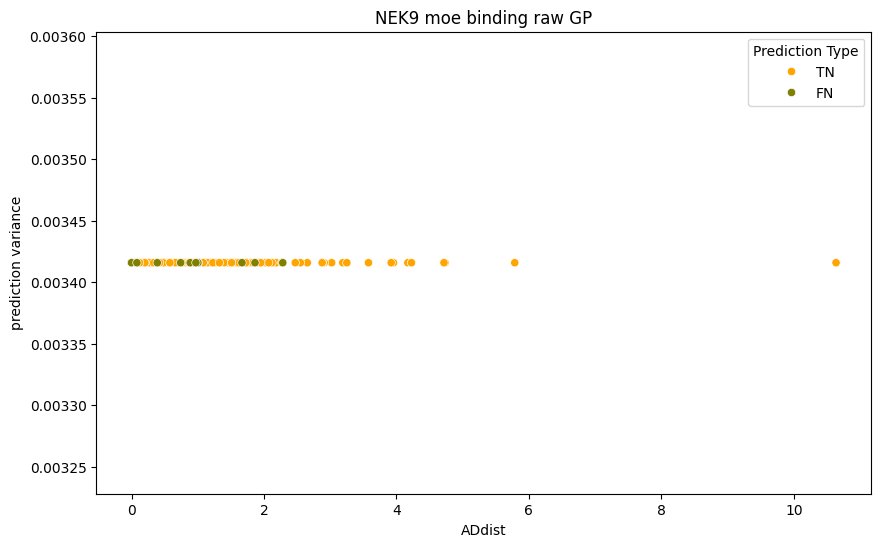

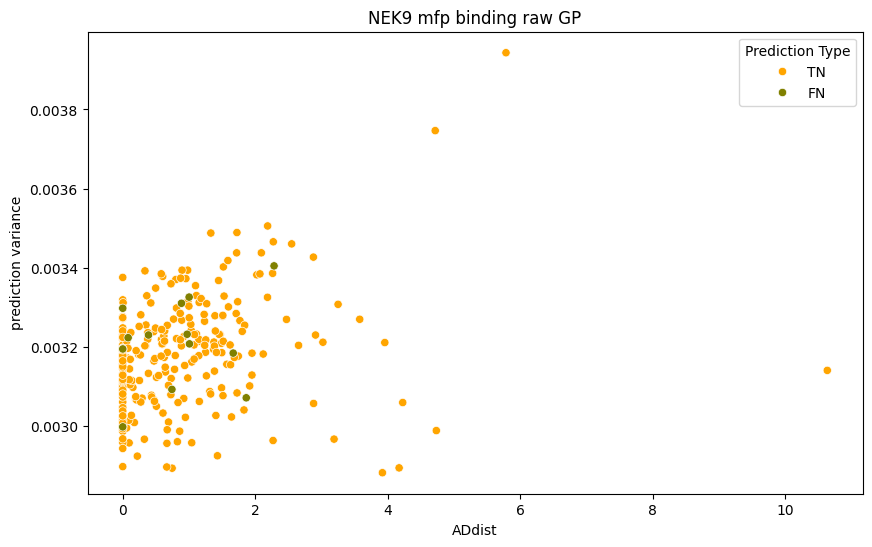

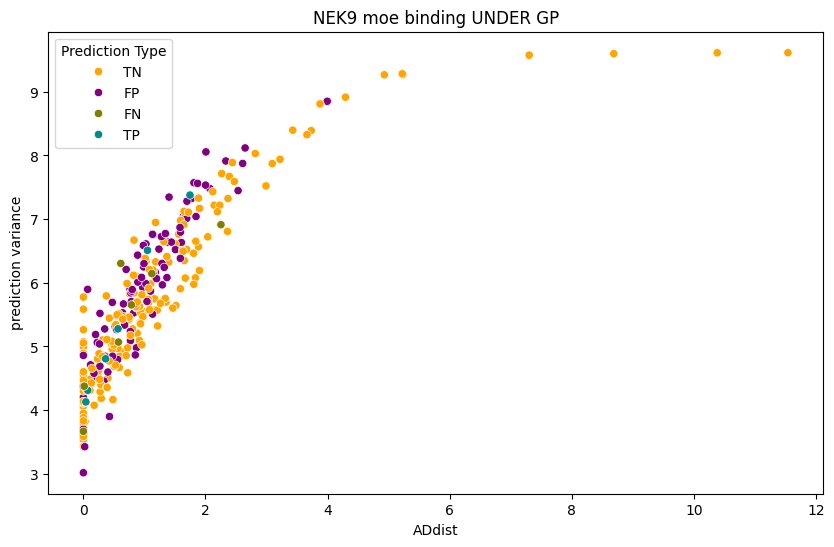

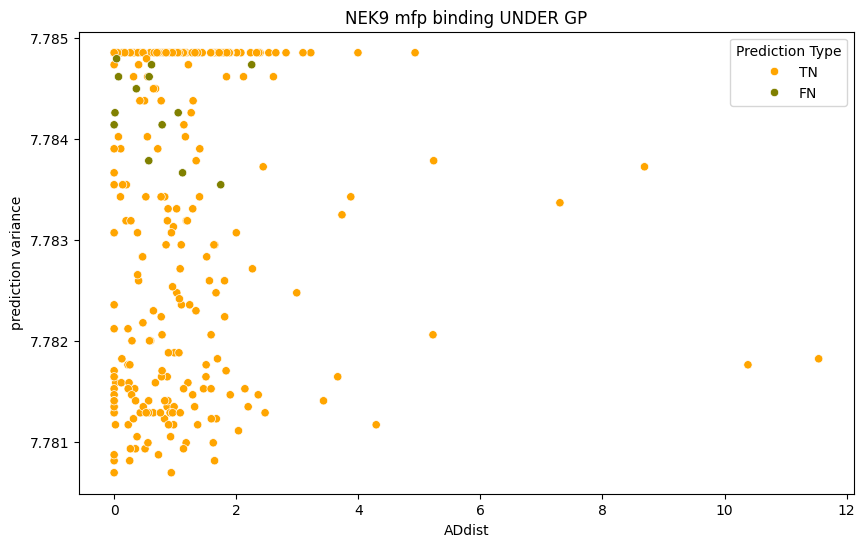

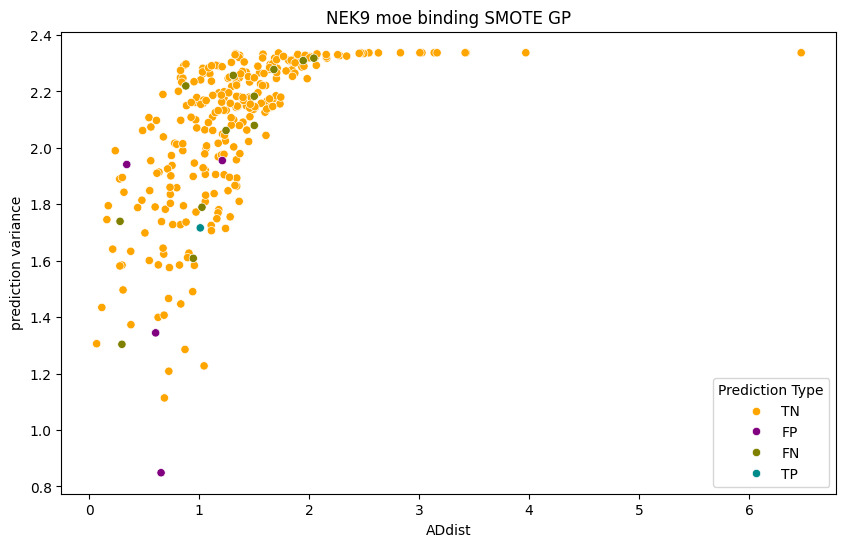

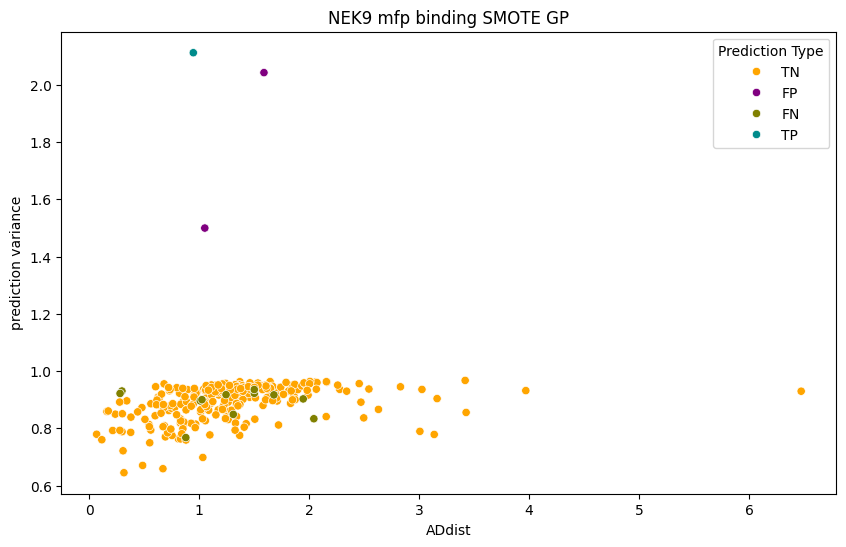

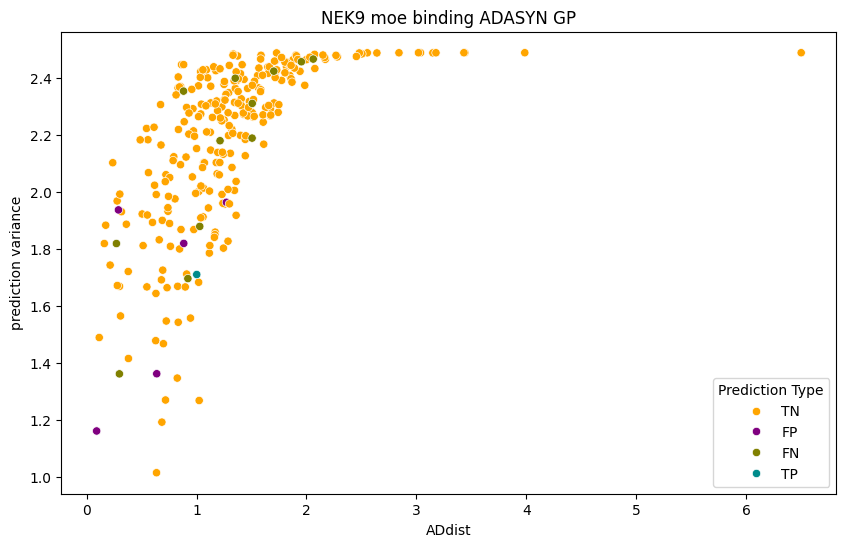

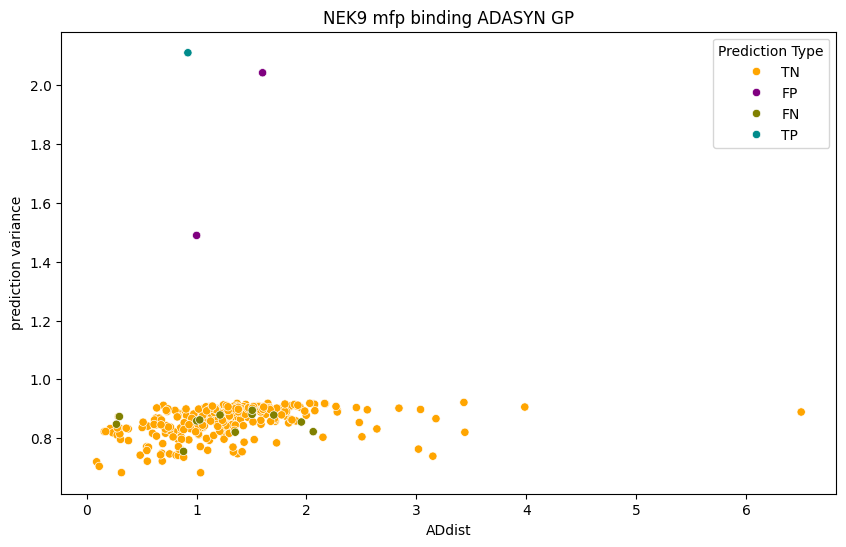

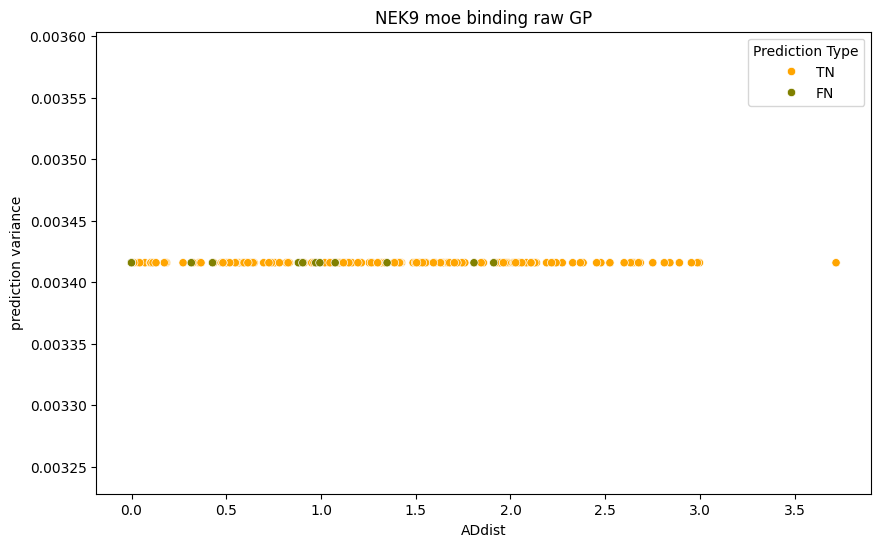

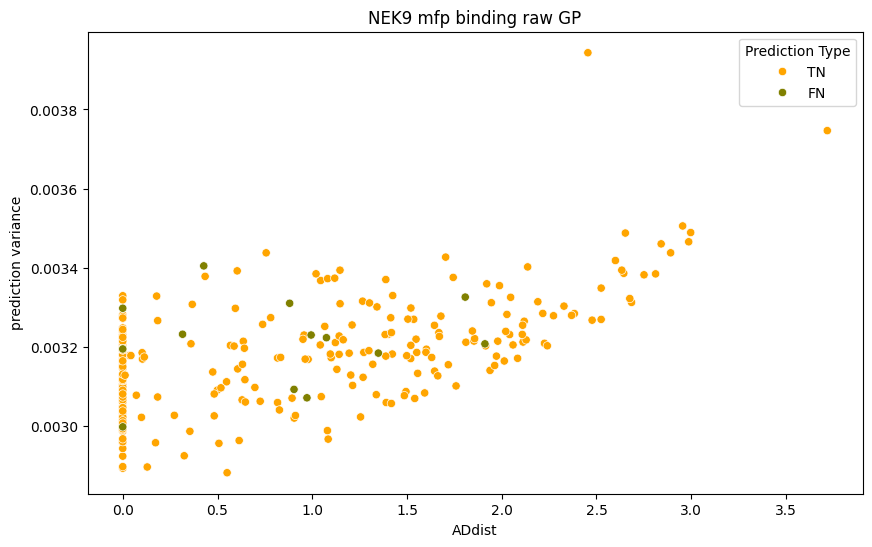

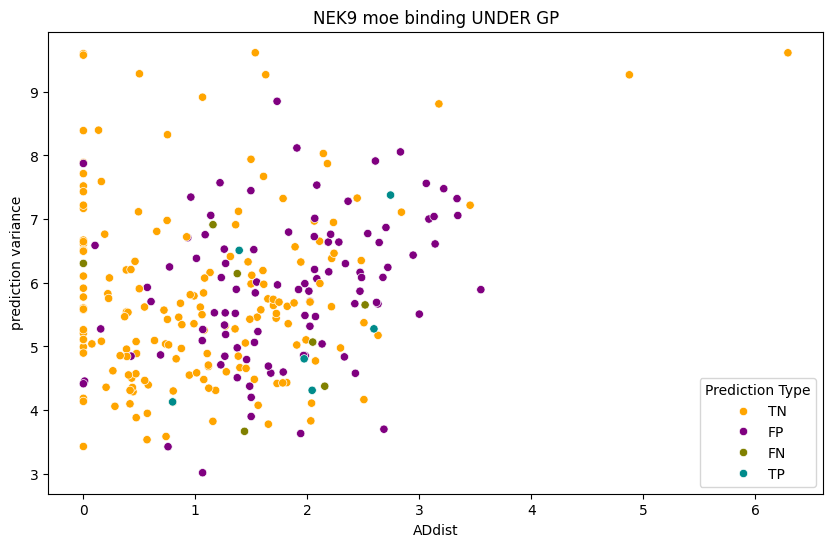

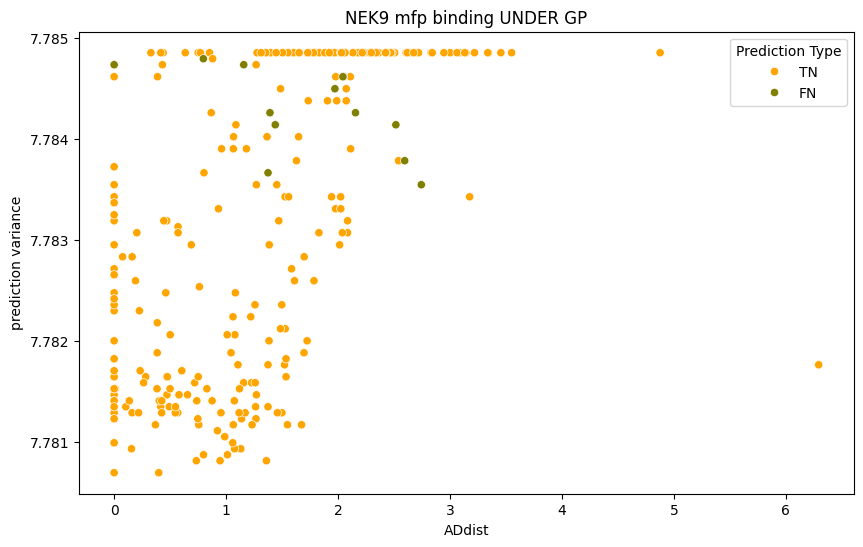

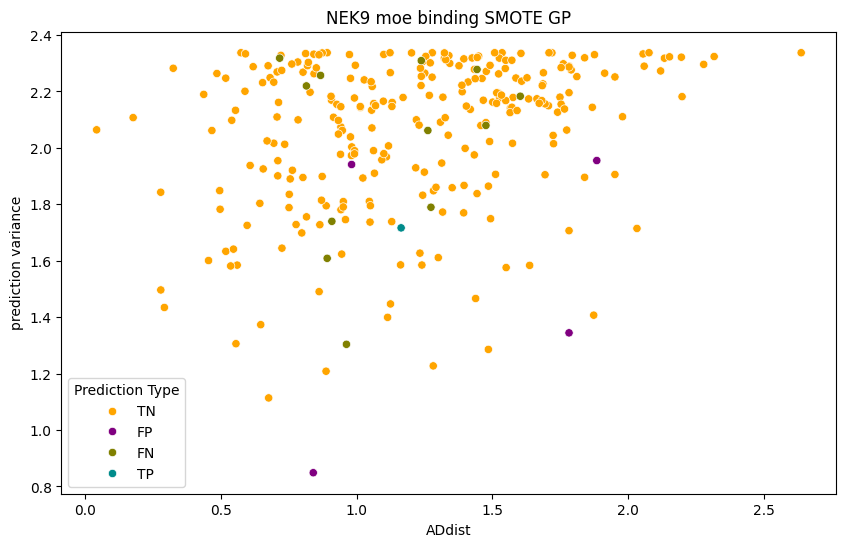

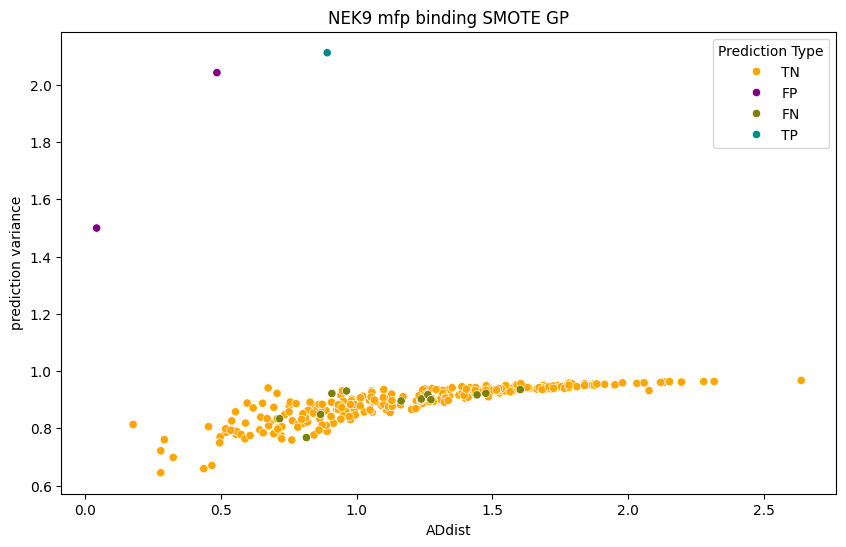

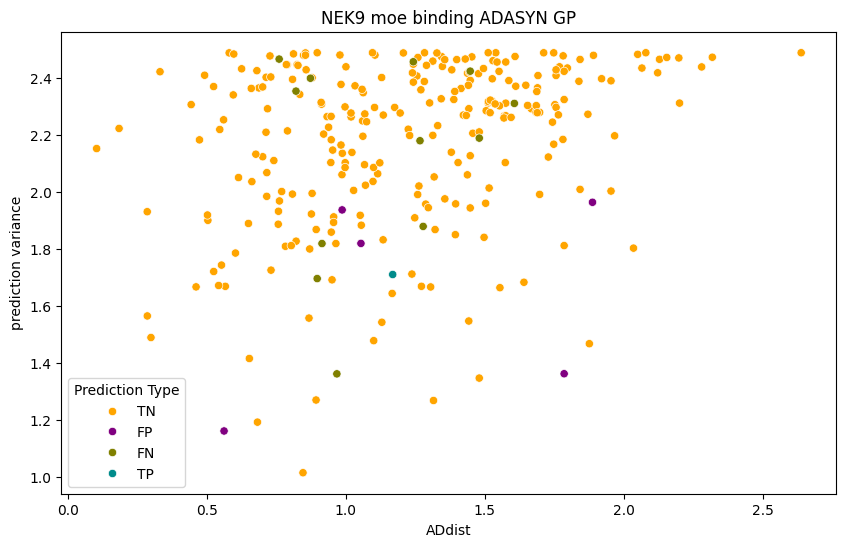

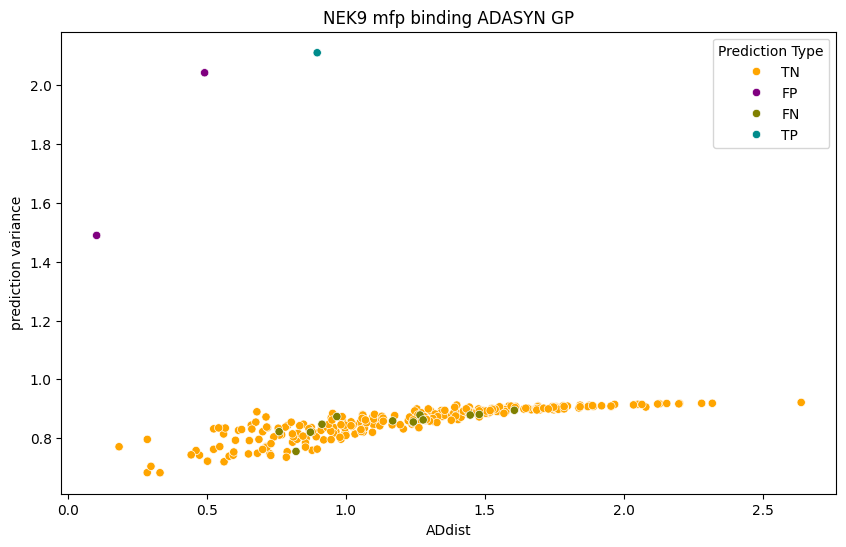

In [4]:


def scatter_ad_GP(df, true_labels, title, figure_path, filename, variance_class):
    # Determine the indices for TP, TN, FP, and FN
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    # Initialize 'Varience of prediction' with NaN
    df['prediction variance'] = np.nan
    
    # Assign values based on the indices
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    ad_dist = df['ADdist']

    # Prepare data for plotting
    data = {
        'prediction variance': df['prediction variance'],
        'Prediction Type': df['prediction_type'],
        'Feature Type': df['feat_type'],
        'ADdist' : df['ADdist']

    }
    plot_df = pd.DataFrame(data)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    pred_palette = {'TP':'darkcyan', 'TN':'orange', 'FP':'purple', 'FN':'olive'}
    ax = sns.scatterplot(x='ADdist', y='prediction variance', data=plot_df, hue='Prediction Type', palette=pred_palette)
    
  
    plt.title(title)
    plt.xlabel('ADdist')
    plt.ylabel('prediction variance')

  
        
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
col_names = ['prediction_type', 'ADdist', 'model_type']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            scatter_ad_GP(moe_df, true_labels, f'NEK{nek} moe binding {samp} GP', figure_path, f'NEK{nek}_binding_moe_{samp}_GP_AD','var0')
            scatter_ad_GP(mfp_df, true_labels, f'NEK{nek} mfp binding {samp} GP', figure_path, f'NEK{nek}_binding_mfp_{samp}_GP_AD','var0')

            if samp == 'raw': 
                samp = 'scaled'


Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_mfp_scaled_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_mfp_UNDER_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_mfp_SMOTE_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_mfp_ADASYN_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_moe_scaled_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_moe_UNDER_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_moe_SMOTE_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK3/bind/NEK3_binding_moe_ADASYN_df.csv


IndexError: index 2 is out of bounds for axis 0 with size 2

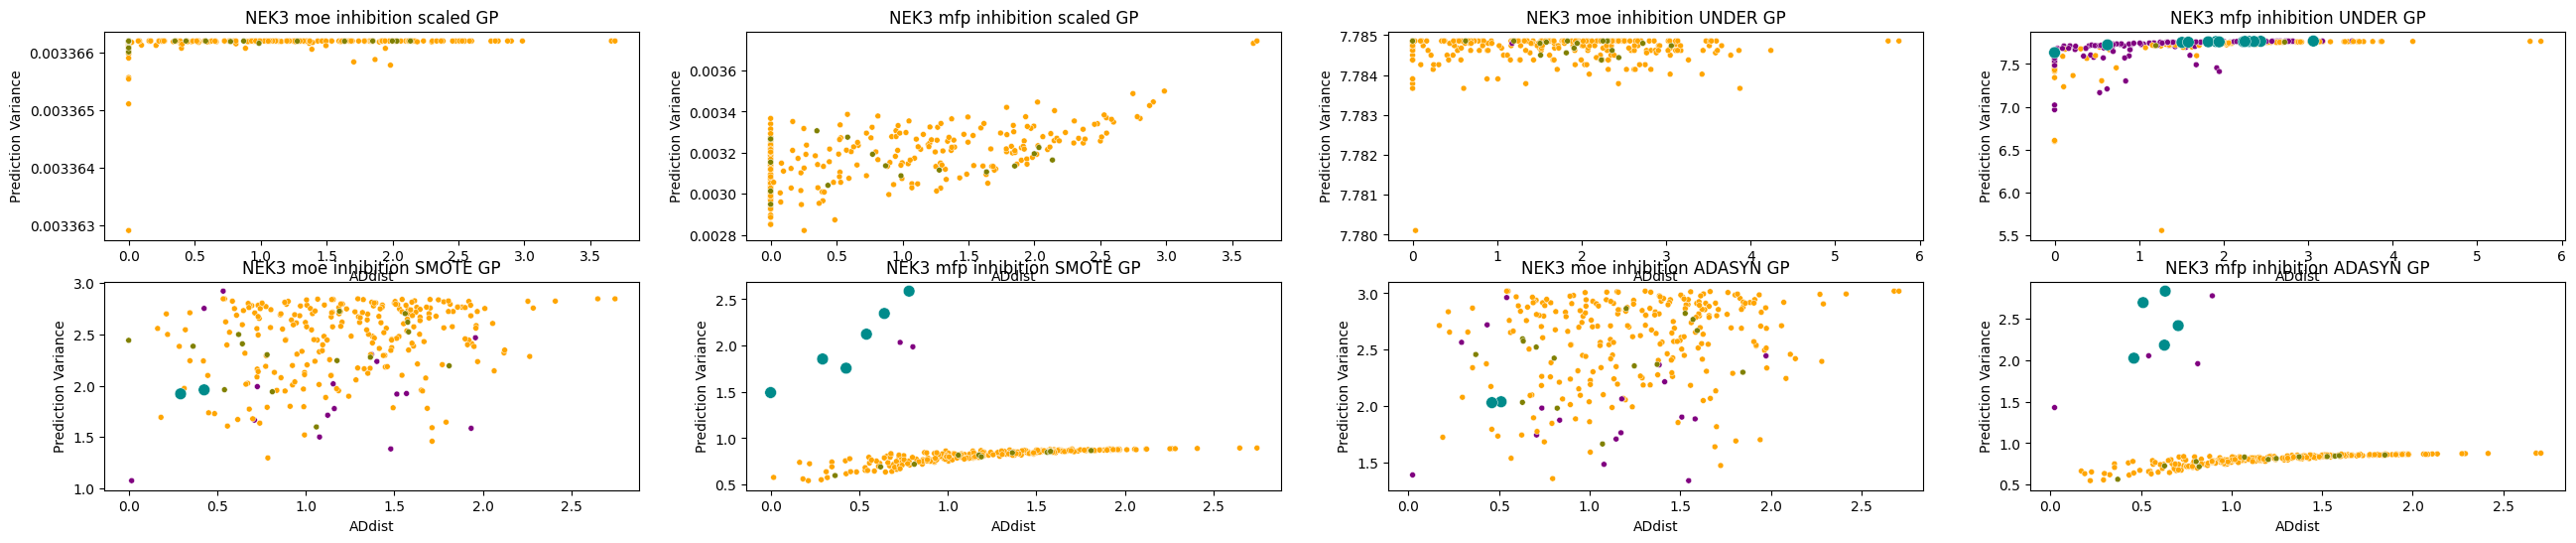

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, filename):
    fig, axes = plt.subplots(2, 4, figsize=(32, 6), sharex=False, sharey=False)
    pred_palette = {'TP': 'darkcyan', 'TN': 'orange', 'FP': 'purple', 'FN': 'olive'}
    pred_sizes = {'TP': 103, 'TN': 99, 'FP': 99, 'FN': 99}

    for i, (df, true_labels, title) in enumerate(zip(df_list, true_labels_list, titles)):
        ax = axes[i // 4, i % 4]  # Correctly place subplots in a 2x4 grid

        tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
        tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
        fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
        fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]

        df['prediction variance'] = np.nan
        df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
        df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
        df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
        df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']

        # Create a new column for marker size based on prediction type
        df['marker_size'] = df['prediction_type'].map(pred_sizes)

        plot_df = pd.DataFrame({
            'prediction variance': df['prediction variance'],
            'Prediction Type': df['prediction_type'],
            'Feature Type': df['feat_type'],
            'ADdist': df['ADdist'],
            'marker_size': df['marker_size']
        })

        sns.scatterplot(x='ADdist', y='prediction variance', data=plot_df, hue='Prediction Type', palette=pred_palette,
                        size='marker_size', legend=False, ax=ax)  # Remove legend for clarity
        ax.set_title(title)
        ax.set_xlabel('ADdist')
        ax.set_ylabel('Prediction Variance')

    plt.tight_layout()
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

nek_list = ["3","5"]
feat_types = ['mfp', 'moe']
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
k = 7

df_list = []
true_labels_list = []
titles = []

for nek in nek_list:
    for feat in feat_types:
        for samp in samplings:
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            file_name = f'NEK{nek}_binding_{feat}_{samp}_df.csv'
            full_file_path = f'{df_path}{file_name}'

            print(f'Trying to read file: {full_file_path}')
            try:
                full_df = pd.read_csv(full_file_path)
            except FileNotFoundError:
                print(f'File not found: {full_file_path}')
                continue

            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp'

            df_list.extend([moe_df, mfp_df])
            true_labels_list.extend([true_labels, true_labels])
            titles.extend([
                f'NEK{nek} moe inhibition {samp} GP', 
                f'NEK{nek} mfp inhibition {samp} GP'
            ])
    custom_filename = f'NEK{nek}_binding_GP_AD_{samp}'
    scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, custom_filename)
    plt.show()


Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_mfp_scaled_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_mfp_UNDER_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_mfp_SMOTE_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_mfp_ADASYN_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_moe_scaled_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_moe_UNDER_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_moe_SMOTE_df.csv
Trying to read file: /Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK2/inhib/NEK2_inhibition_moe_ADASYN_df.csv


IndexError: index 2 is out of bounds for axis 0 with size 2

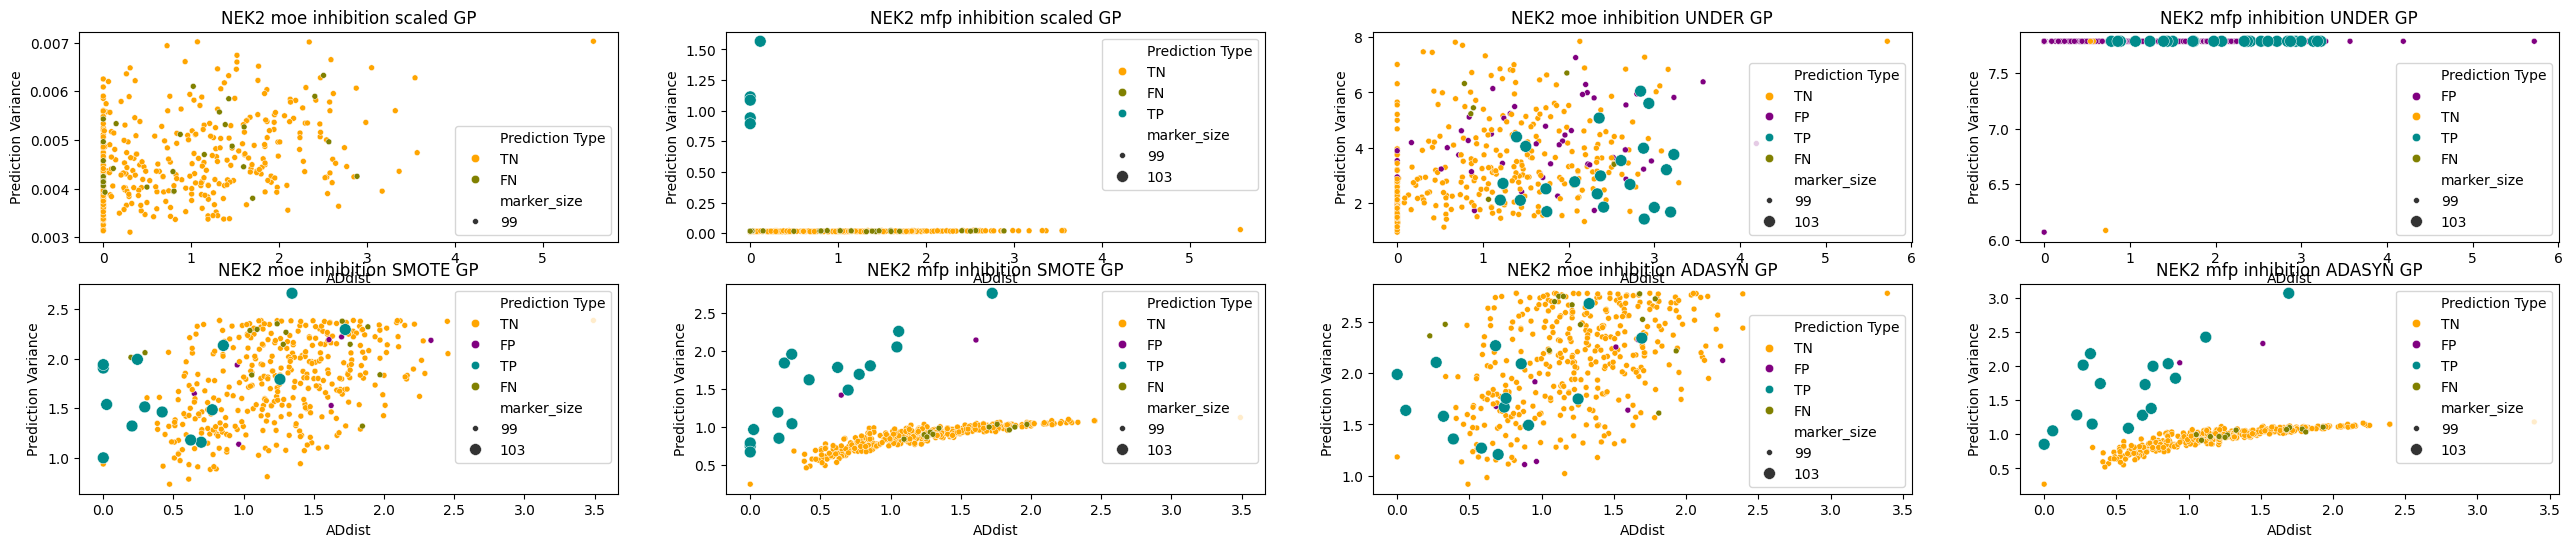

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, filename):
    fig, axes = plt.subplots(2, 4, figsize=(32, 6), sharex=False, sharey=False)
    pred_palette = {'TP': 'darkcyan', 'TN': 'orange', 'FP': 'purple', 'FN': 'olive'}
    pred_sizes = {'TP': 103, 'TN': 99, 'FP': 99, 'FN': 99}

    for i, (df, true_labels, title) in enumerate(zip(df_list, true_labels_list, titles)):
        ax = axes[i // 4, i % 4]  # Correctly place subplots in a 2x4 grid

        tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
        tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
        fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
        fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]

        df['prediction variance'] = np.nan
        df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
        df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
        df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
        df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']

        # Create a new column for marker size based on prediction type
        df['marker_size'] = df['prediction_type'].map(pred_sizes)

        plot_df = pd.DataFrame({
            'prediction variance': df['prediction variance'],
            'Prediction Type': df['prediction_type'],
            'Feature Type': df['feat_type'],
            'ADdist': df['ADdist'],
            'marker_size': df['marker_size']
        })

        sns.scatterplot(x='ADdist', y='prediction variance', data=plot_df, hue='Prediction Type', palette=pred_palette,
                        size='marker_size', legend=True, ax=ax)  # Remove legend for clarity
        ax.set_title(title)
        ax.set_xlabel('ADdist')
        ax.set_ylabel('Prediction Variance')

    plt.tight_layout()
    plt.show()

GPpath = '/Users/radhi/Desktop/CAPSTONE_DATA/GP_results/GP_result_df/'
figure_path = '/Users/radhi/Desktop/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_GP_var/'

nek_list = ["2"]
feat_types = ['mfp', 'moe']
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
k = 7

df_list = []
true_labels_list = []
titles = []

for nek in nek_list:
    for feat in feat_types:
        for samp in samplings:
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/inhib/'
            file_name = f'NEK{nek}_inhibition_{feat}_{samp}_df.csv'
            full_file_path = f'{df_path}{file_name}'

            print(f'Trying to read file: {full_file_path}')
            try:
                full_df = pd.read_csv(full_file_path)
            except FileNotFoundError:
                print(f'File not found: {full_file_path}')
                continue

            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_inhibition_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_inhibition_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp'

            df_list.extend([moe_df, mfp_df])
            true_labels_list.extend([true_labels, true_labels])
            titles.extend([
                f'NEK{nek} moe inhibition {samp} GP', 
                f'NEK{nek} mfp inhibition {samp} GP'
            ])
    custom_filename = f'NEK{nek}_inhibition_GP_AD_{samp}'
    scatter_ad_GP_subplot(df_list, true_labels_list, titles, figure_path, custom_filename)
    plt.show()


In [70]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

In [71]:
def histogram_ad_dist(df, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['ADdist'], bins=30, kde=False)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('ADdist')
    plt.show()

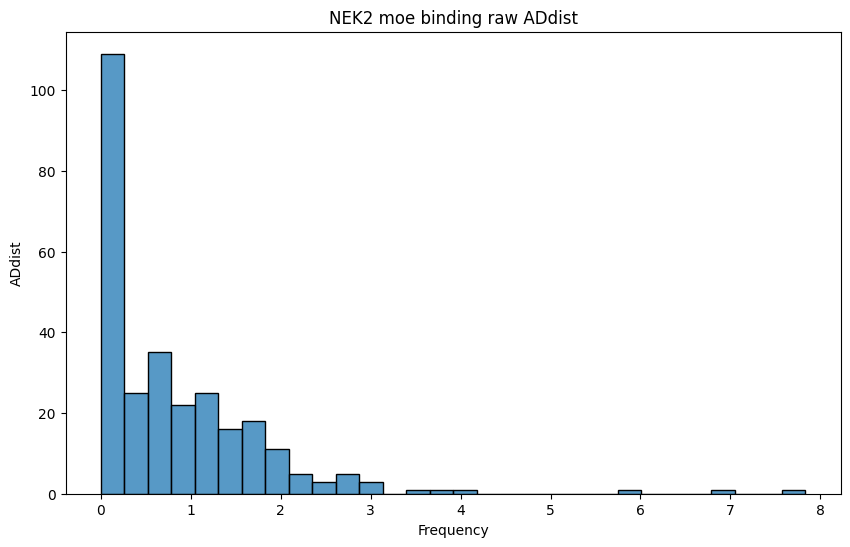

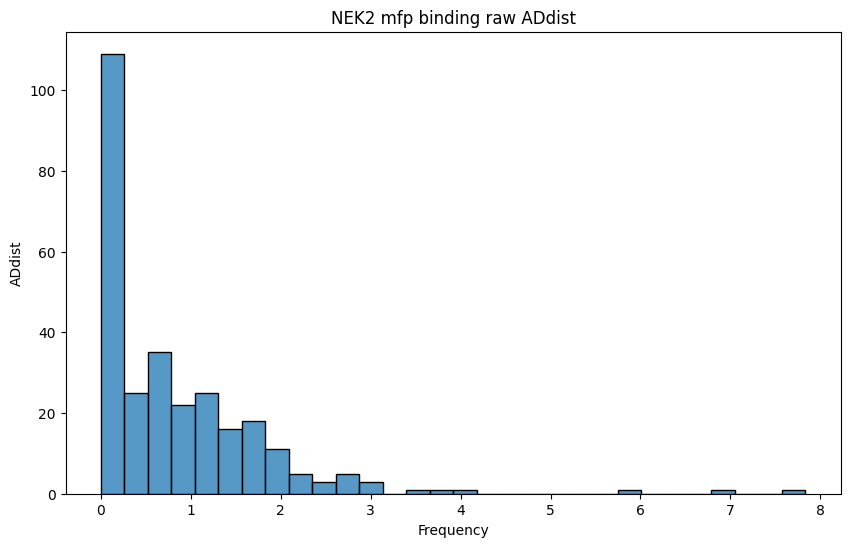

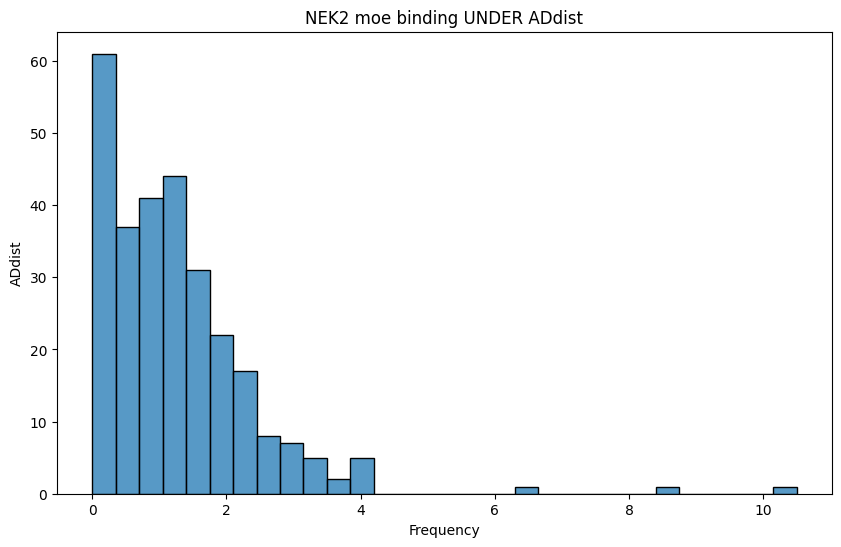

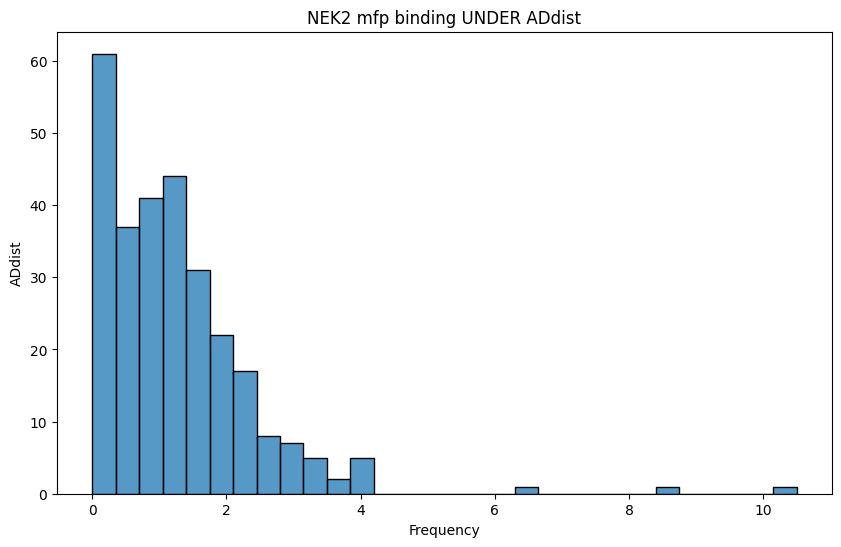

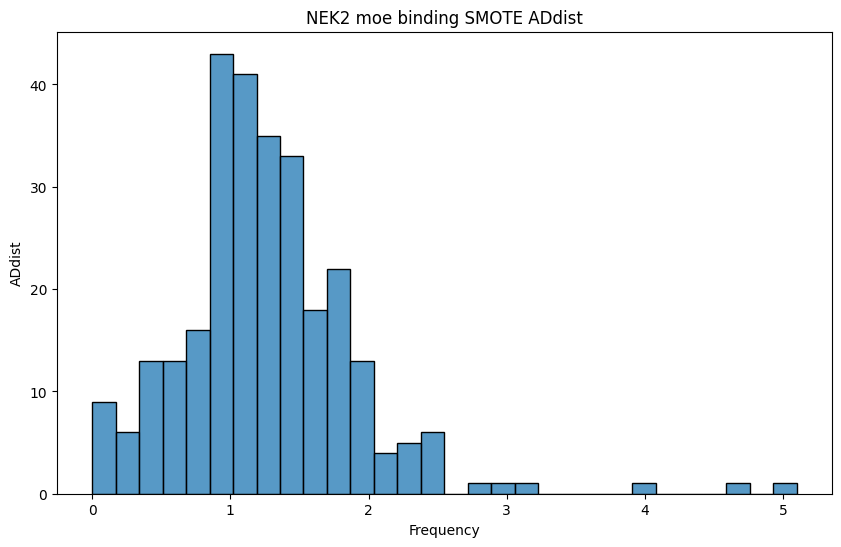

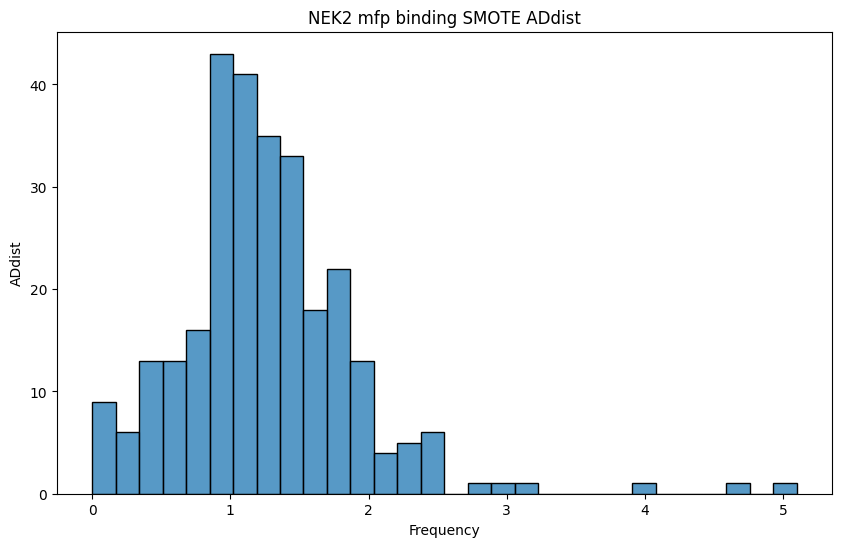

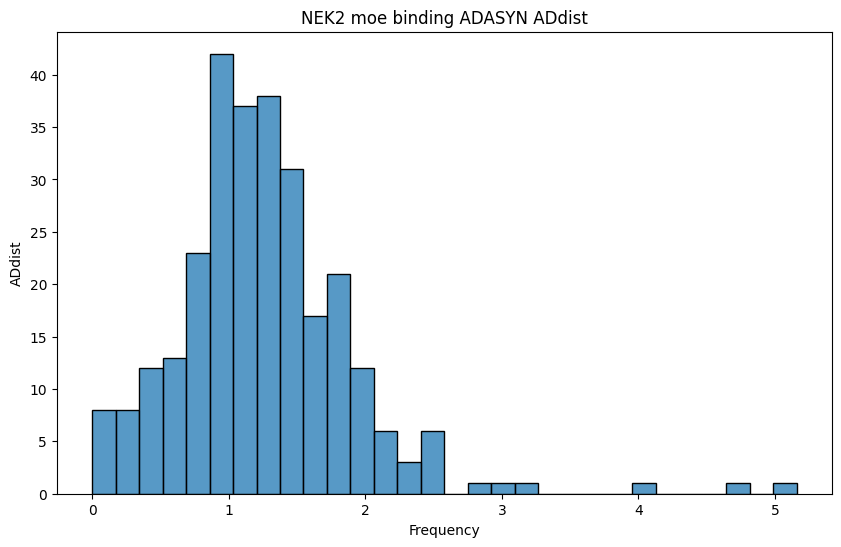

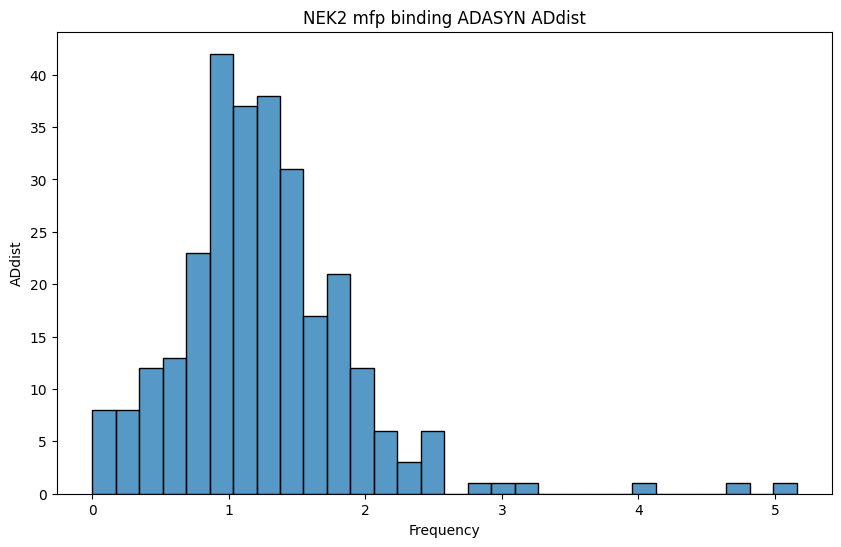

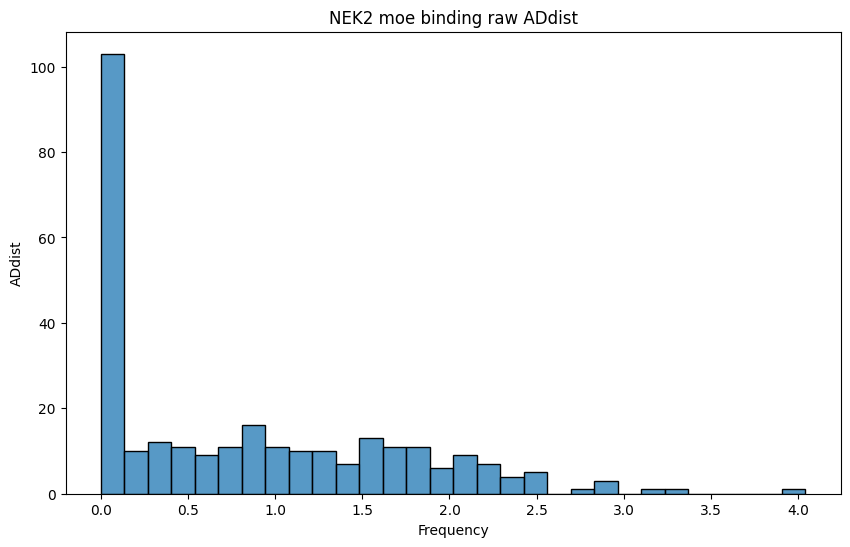

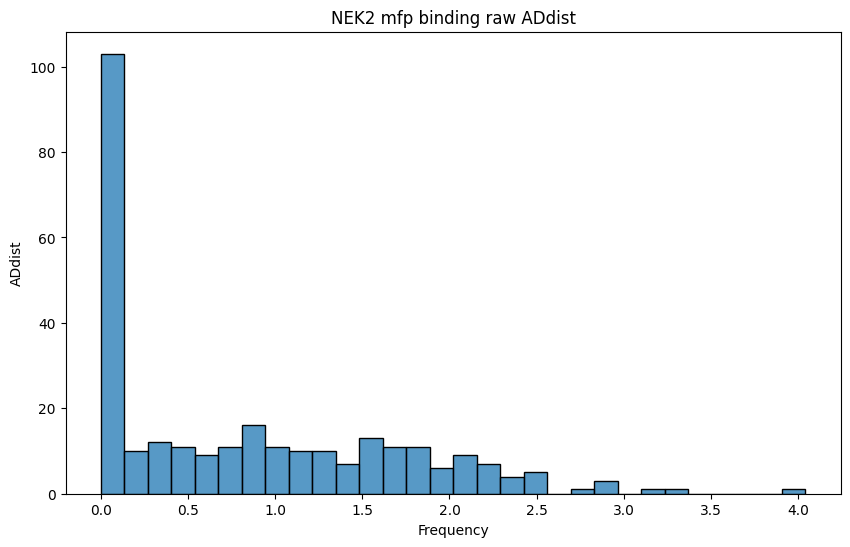

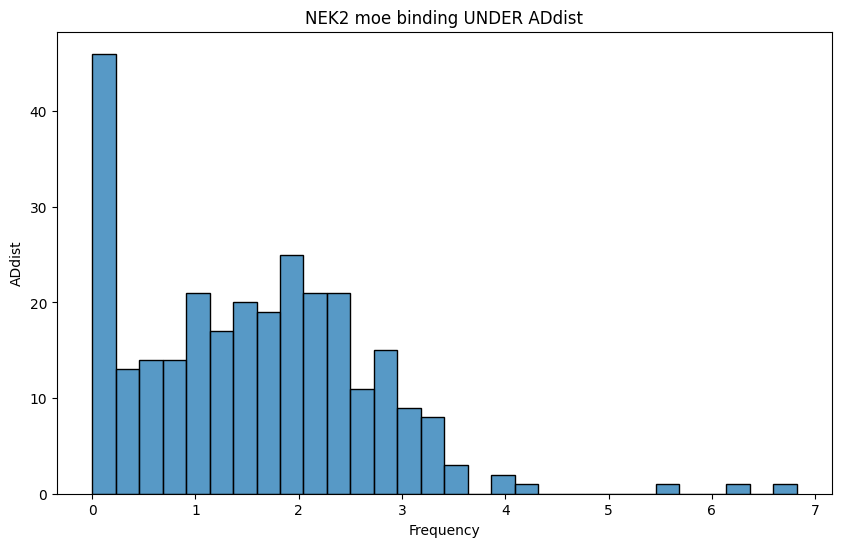

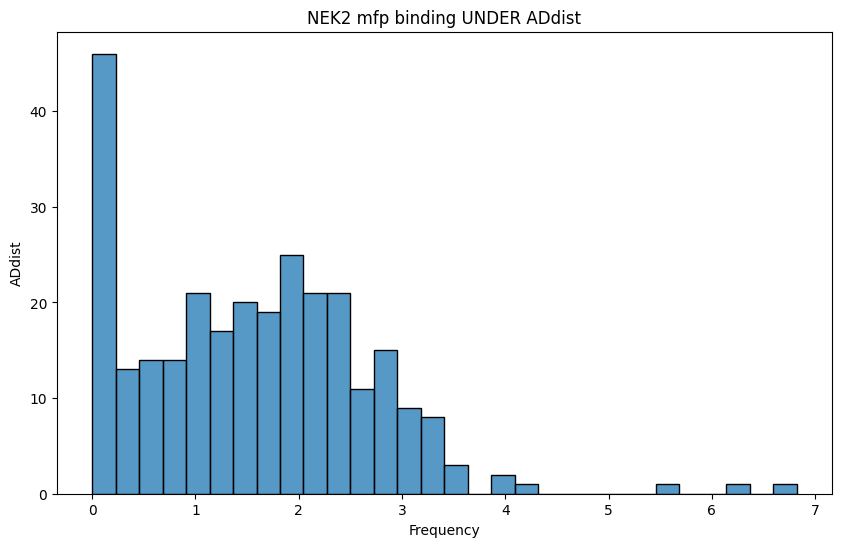

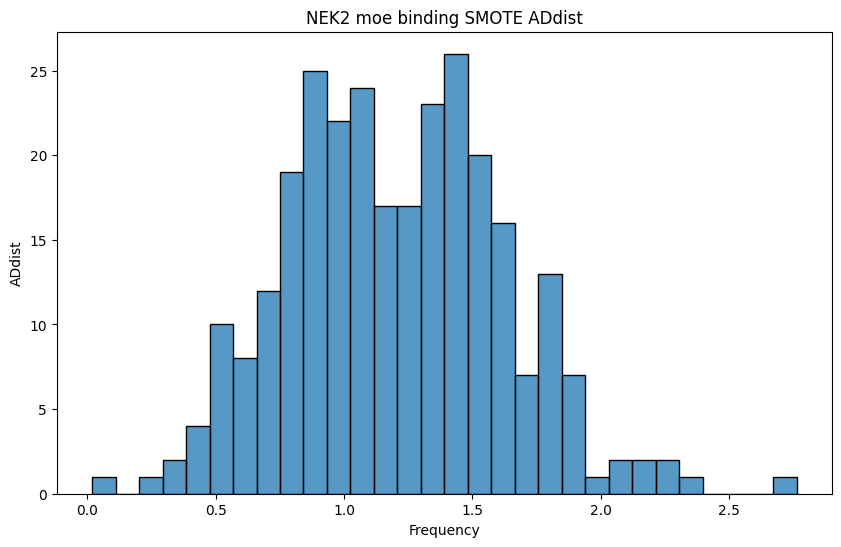

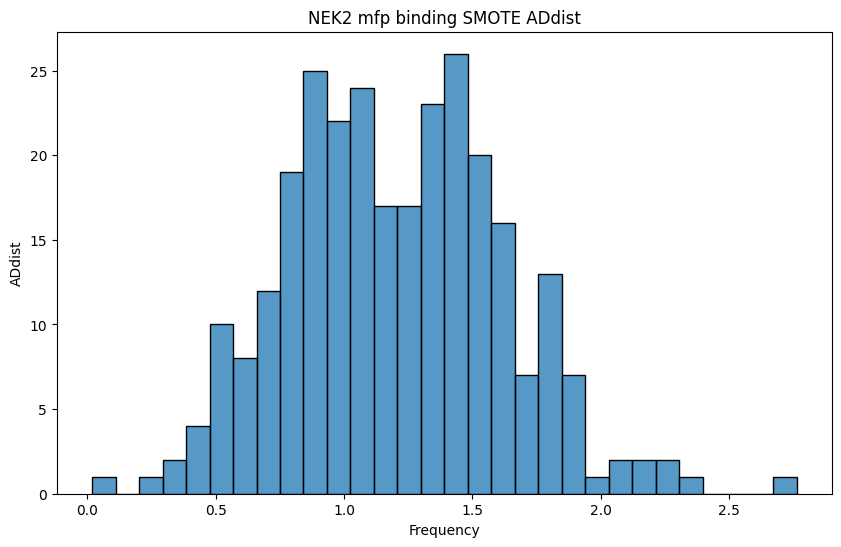

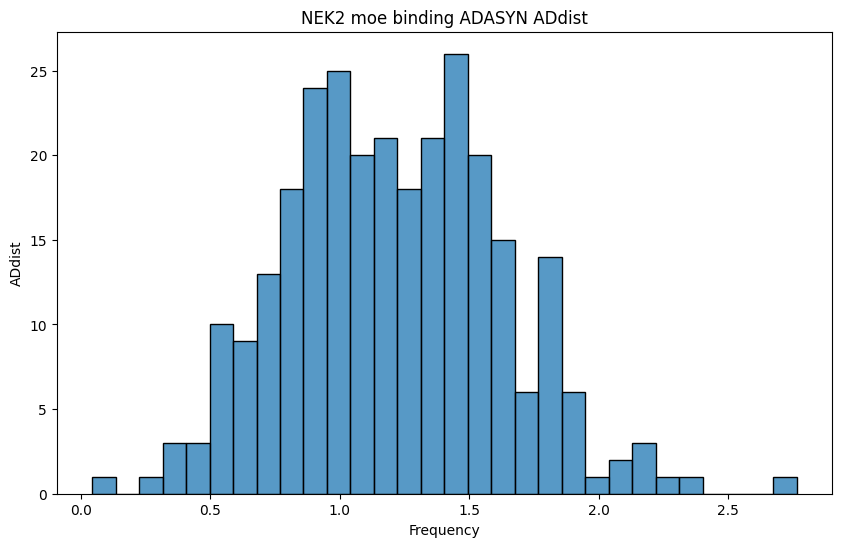

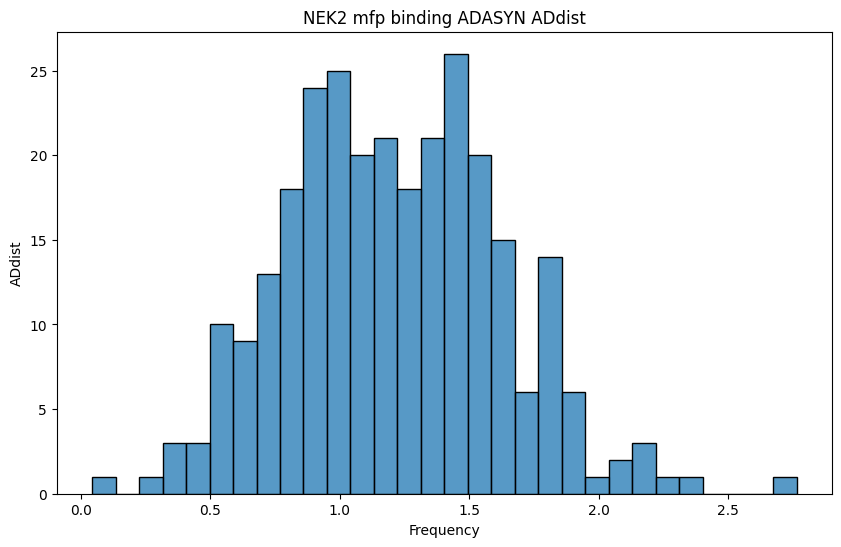

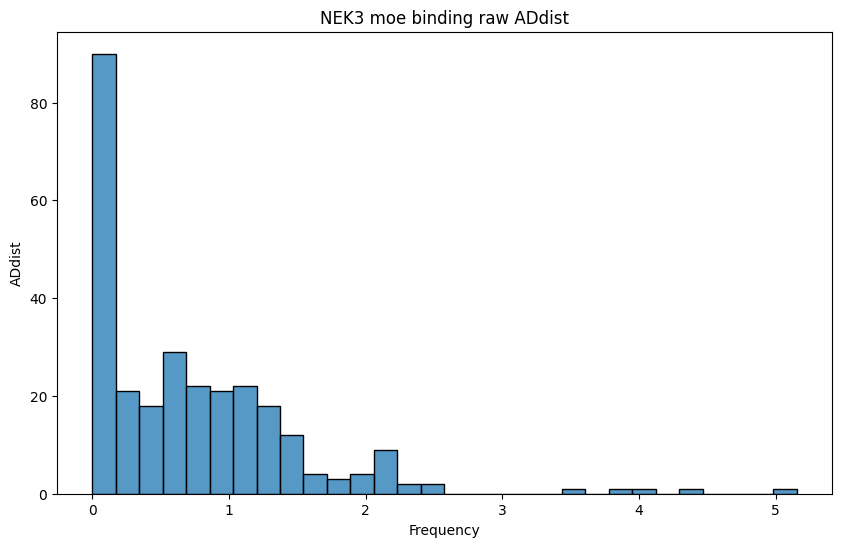

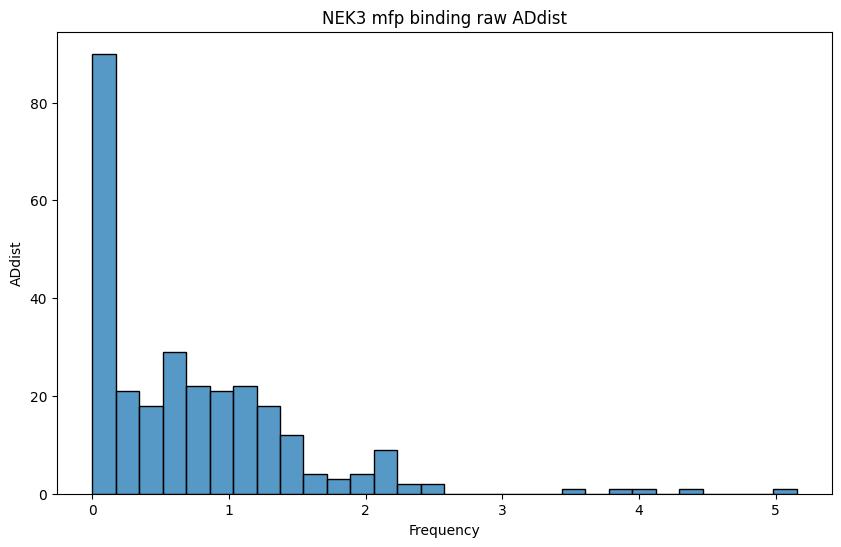

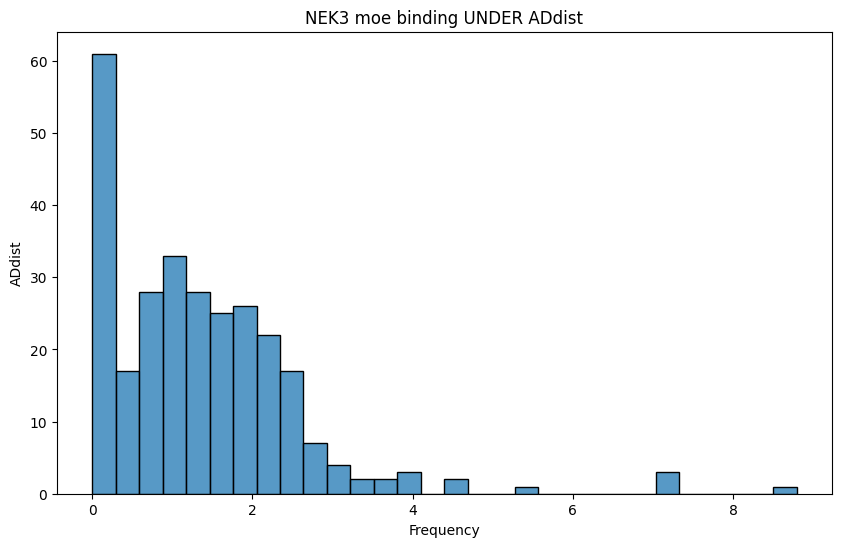

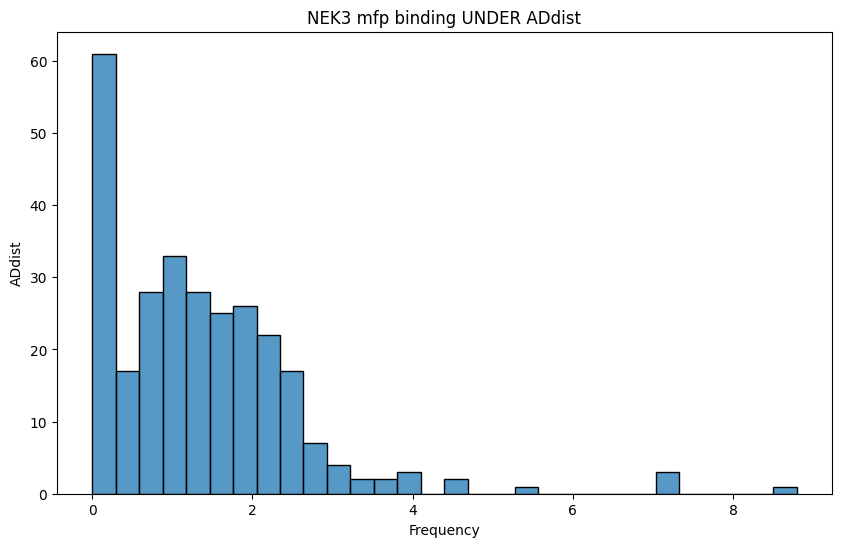

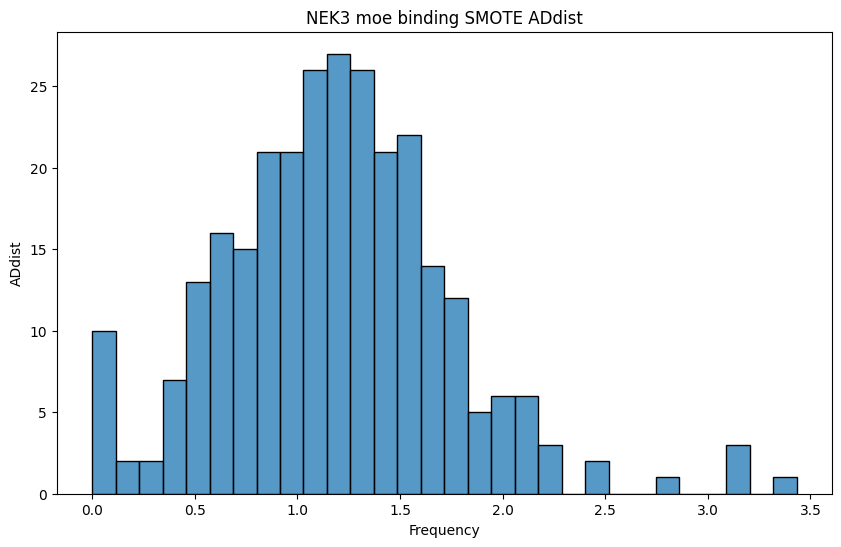

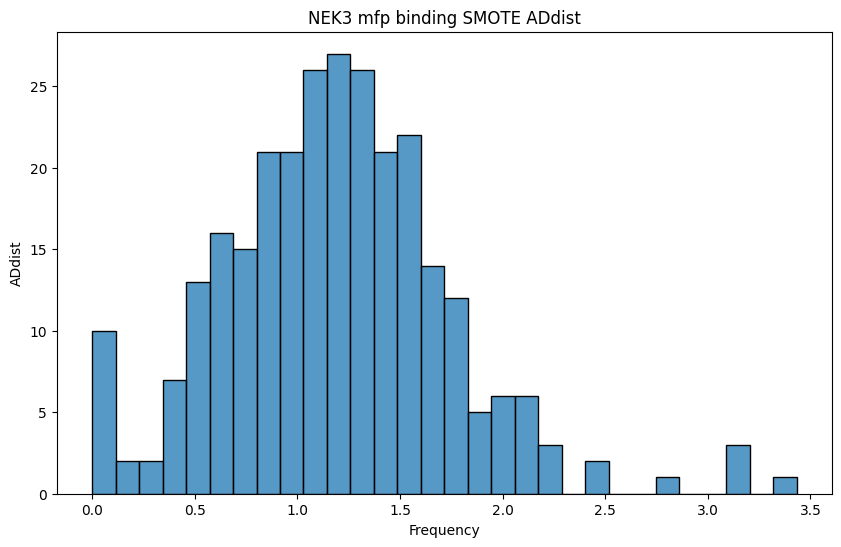

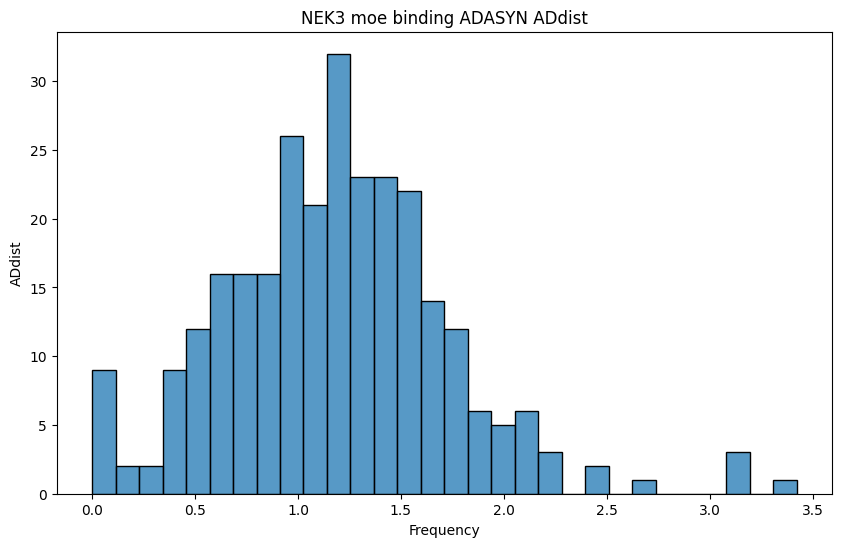

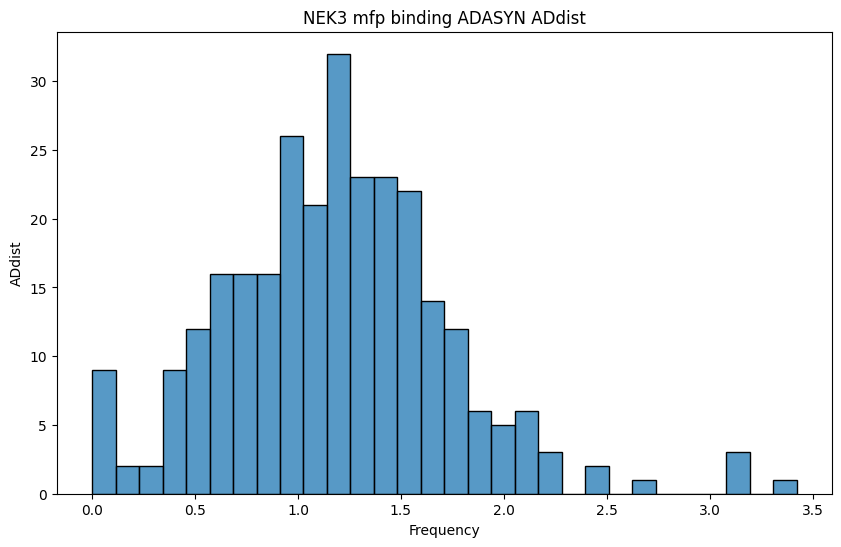

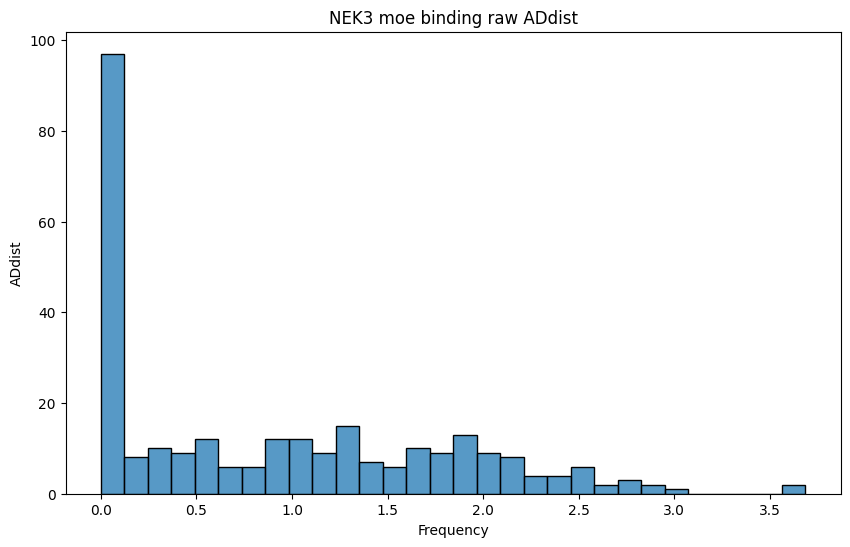

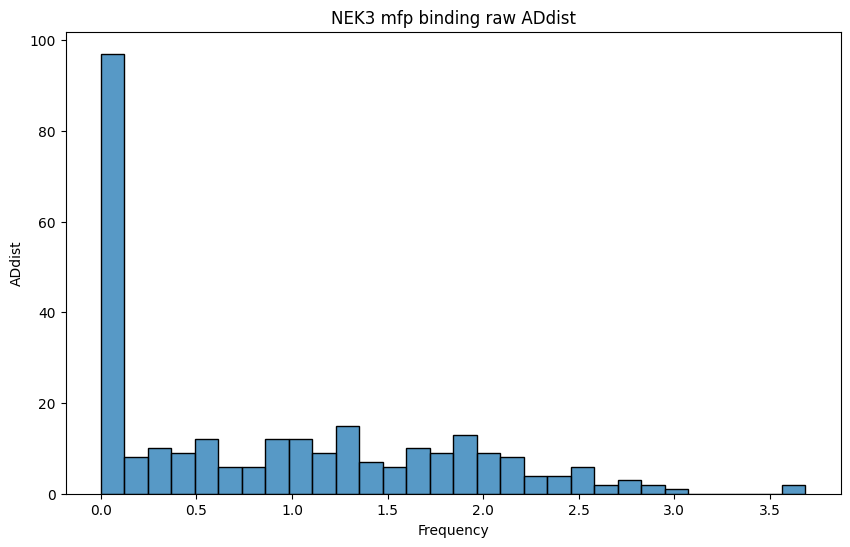

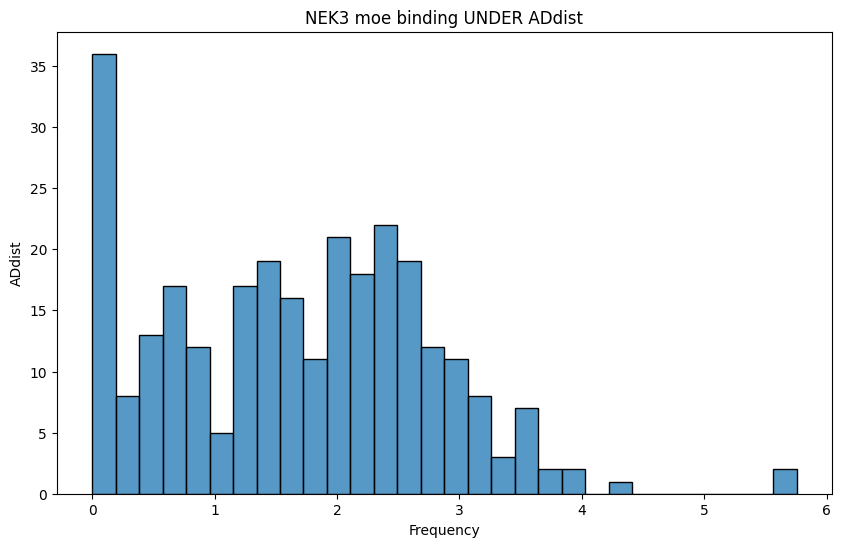

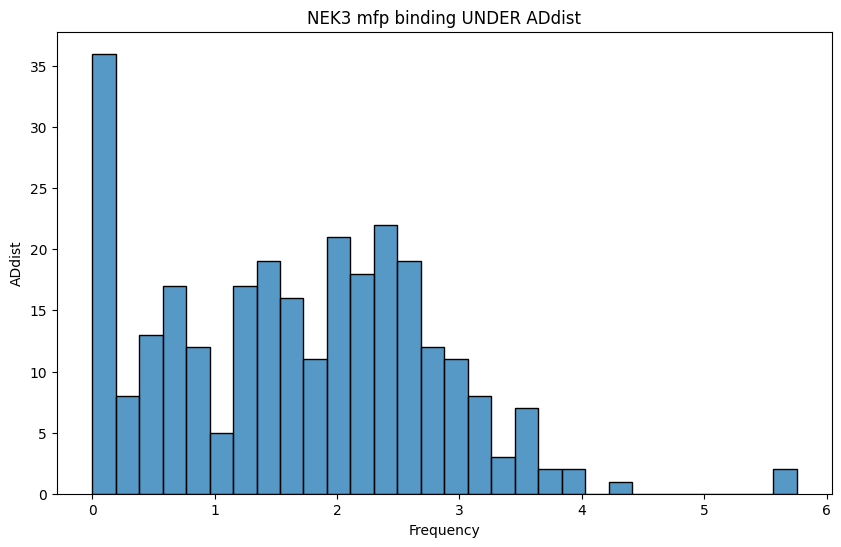

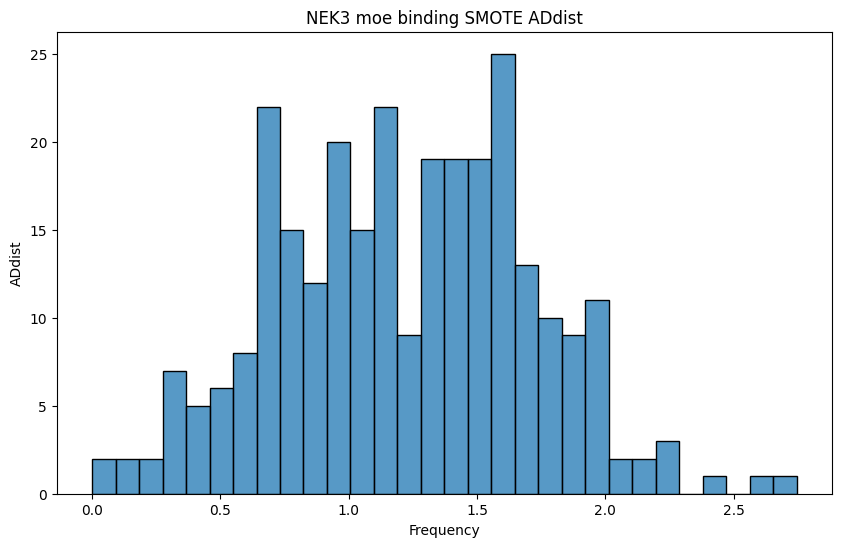

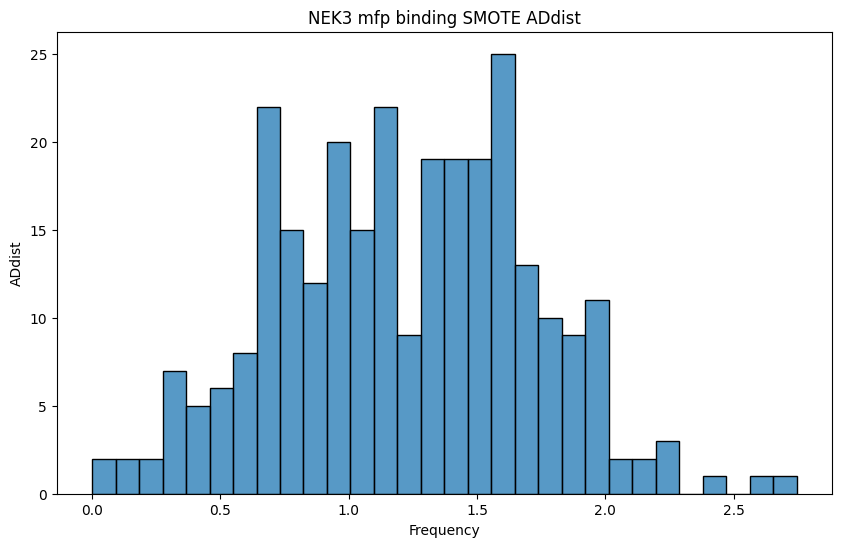

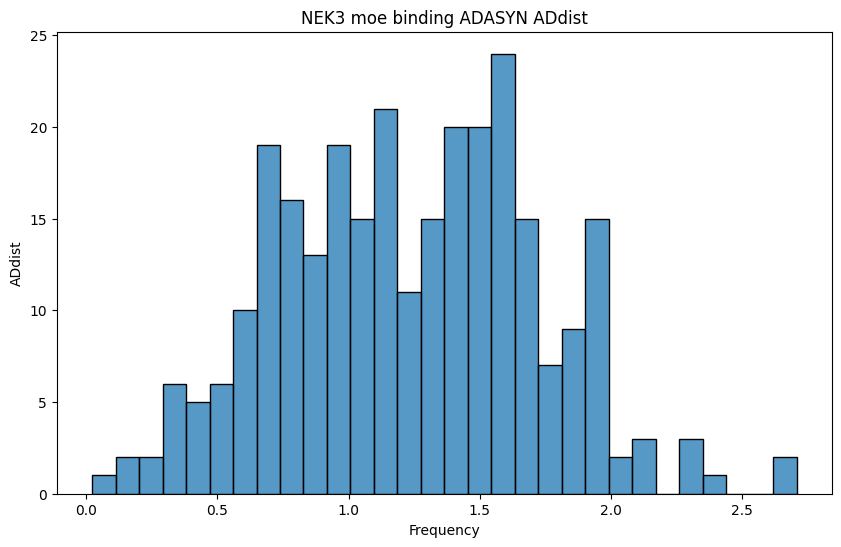

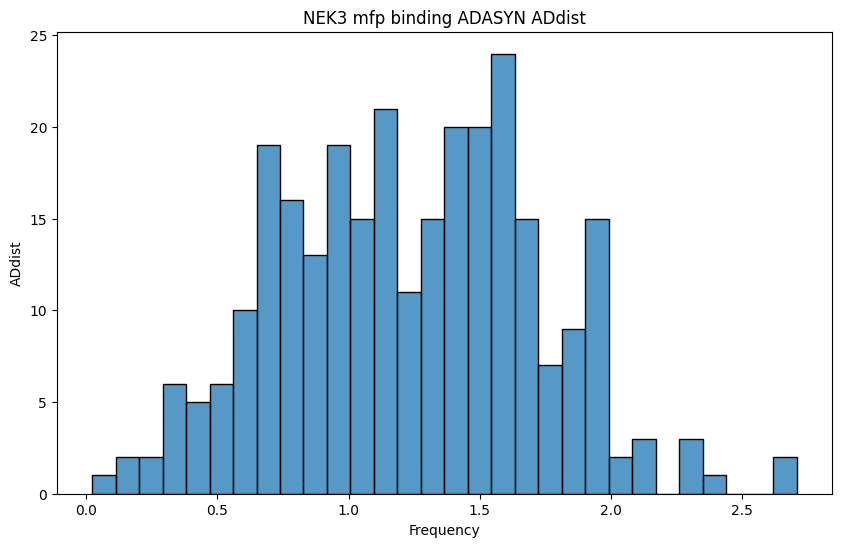

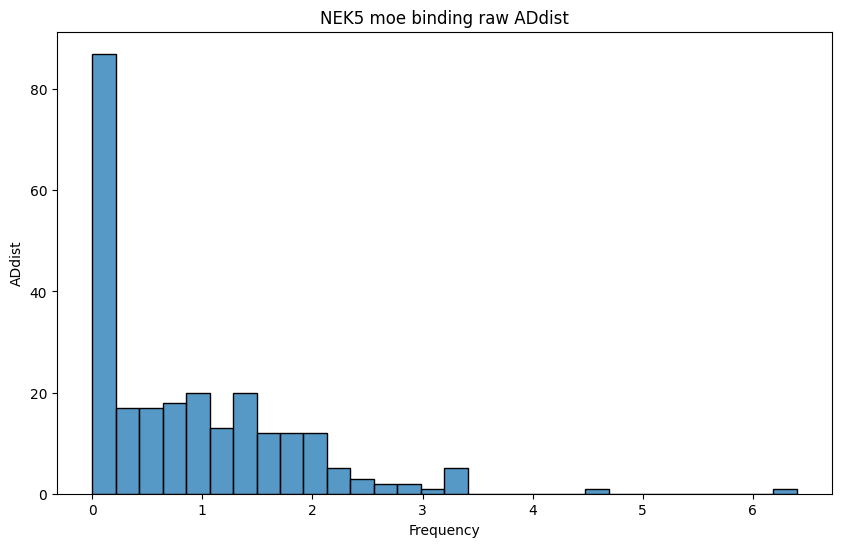

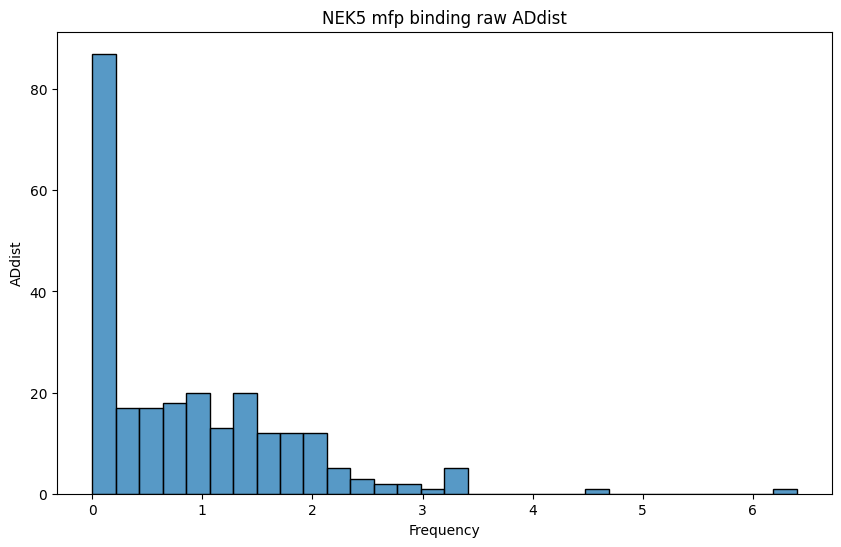

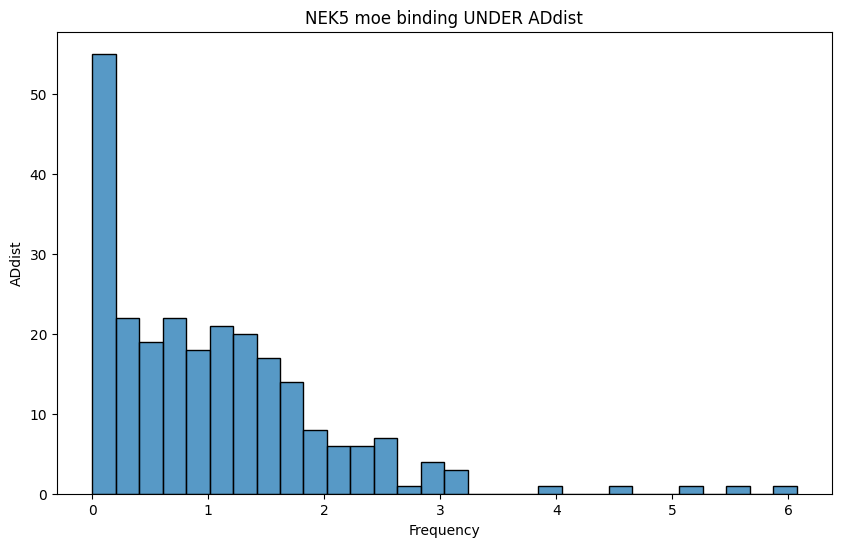

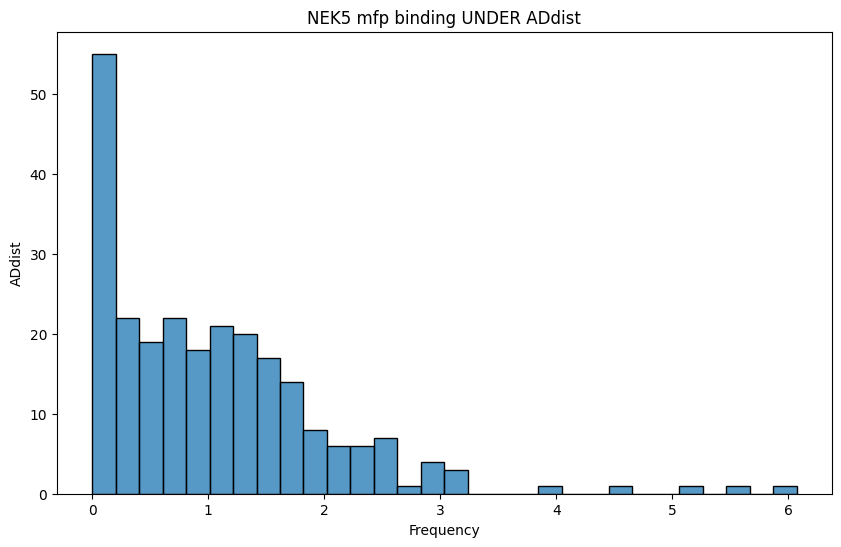

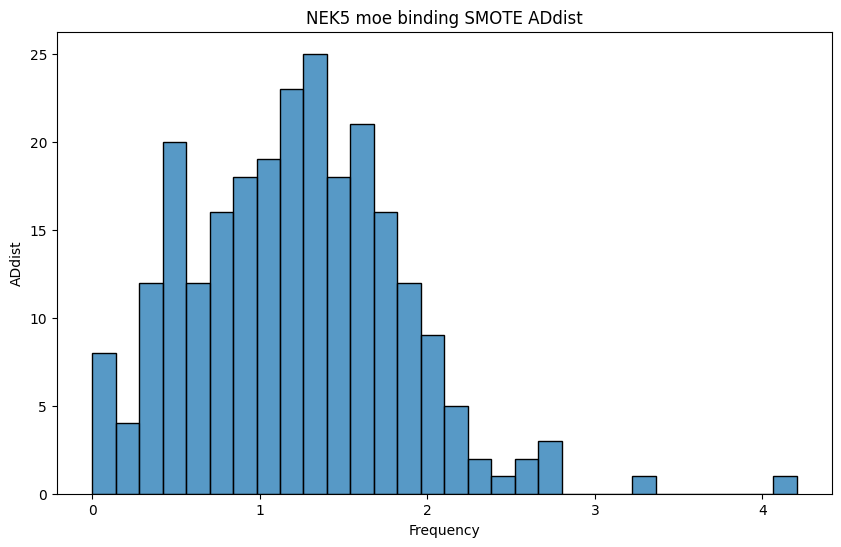

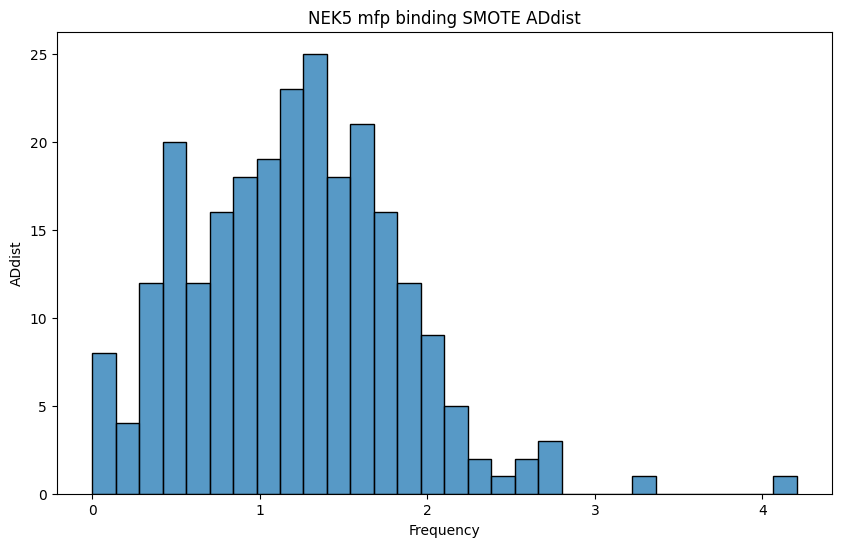

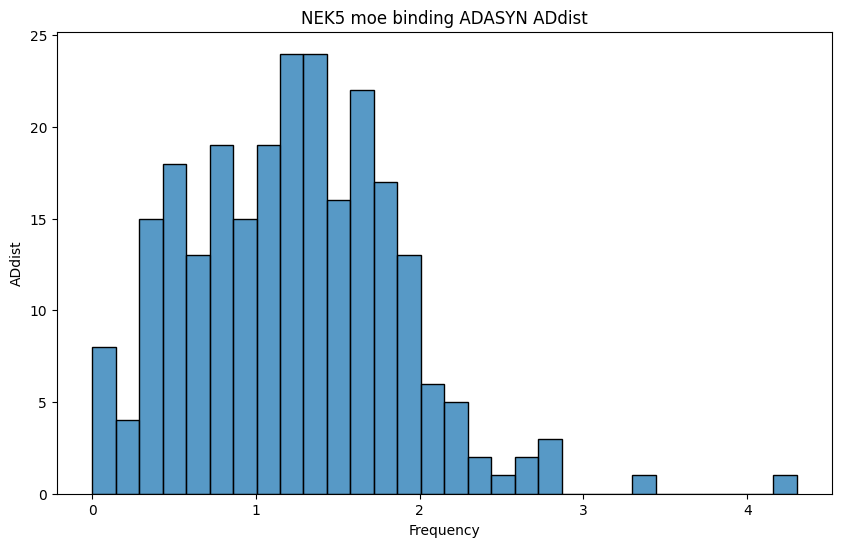

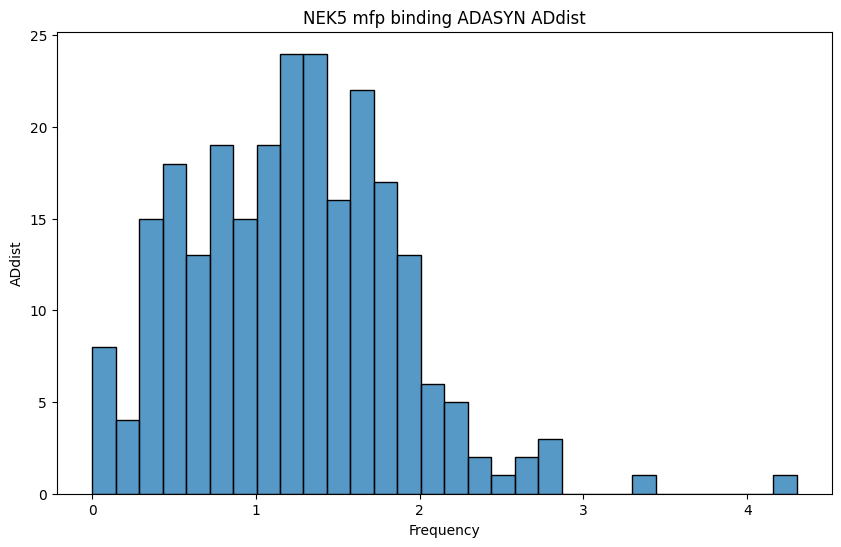

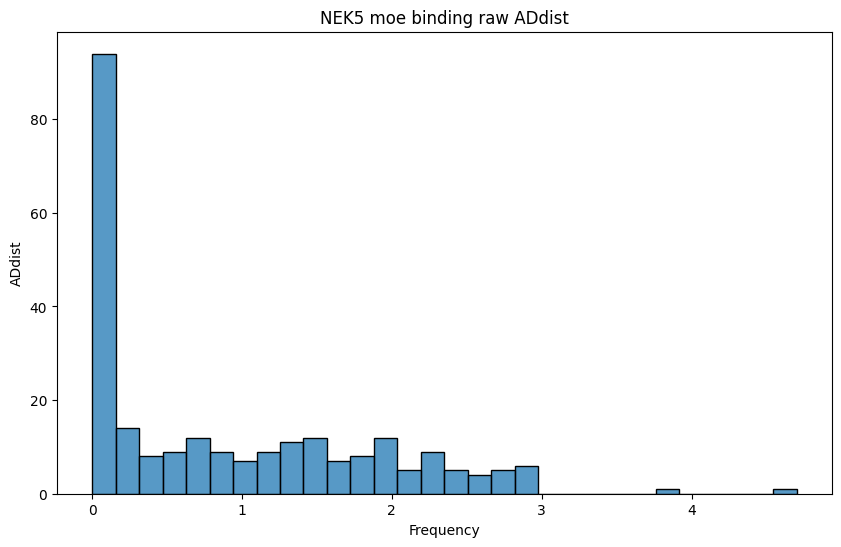

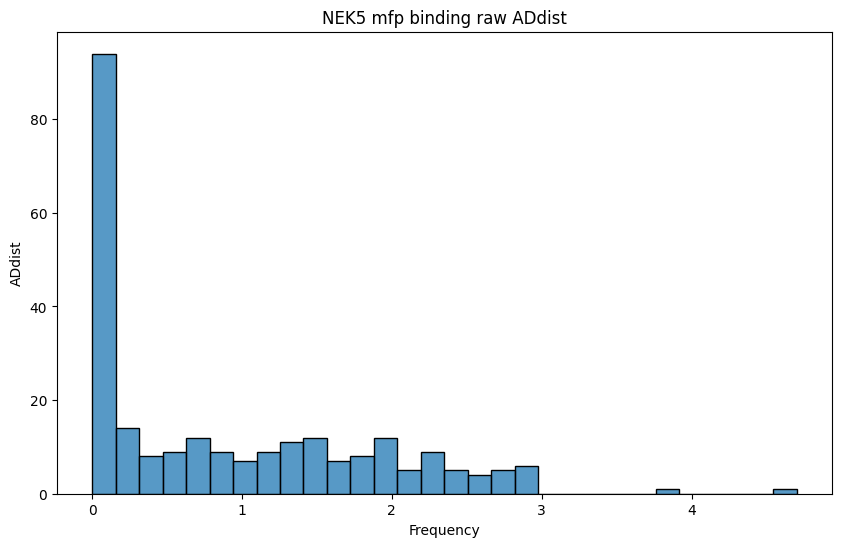

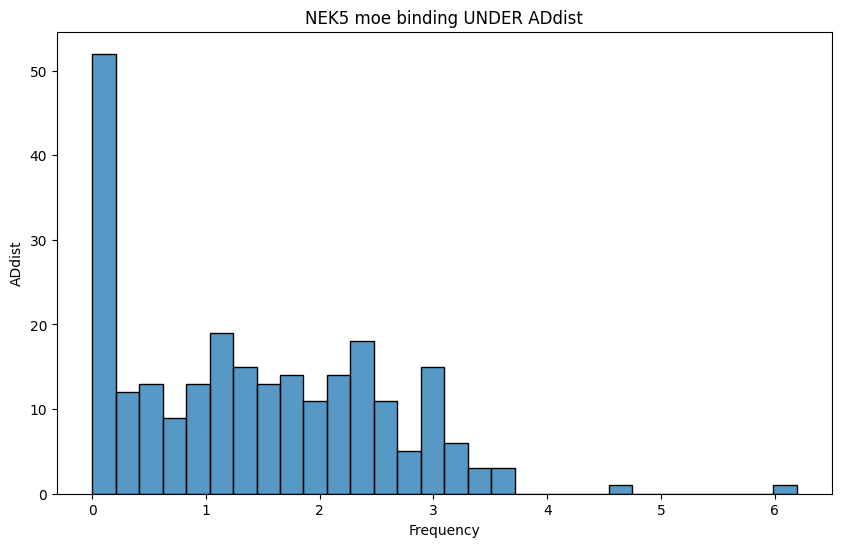

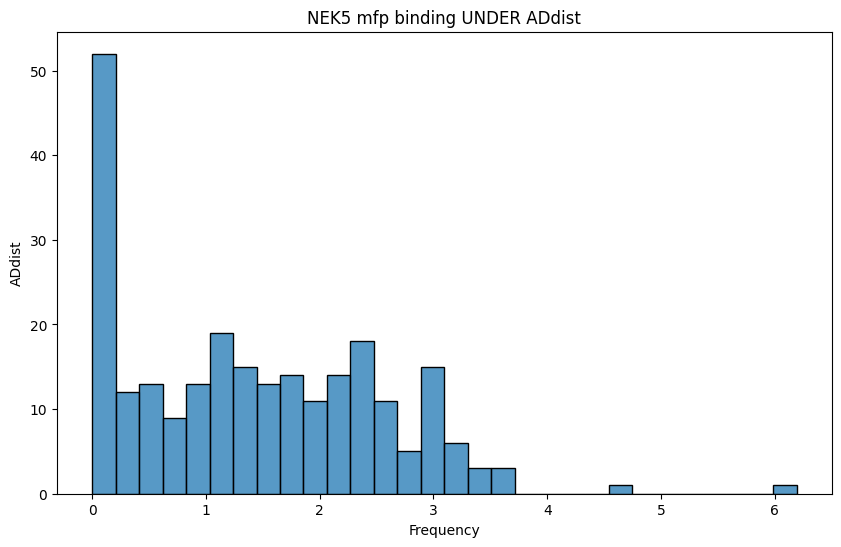

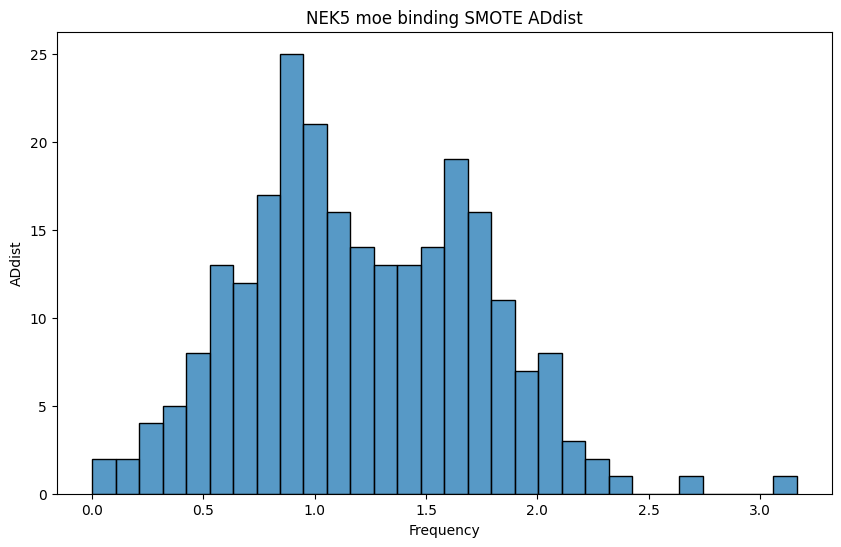

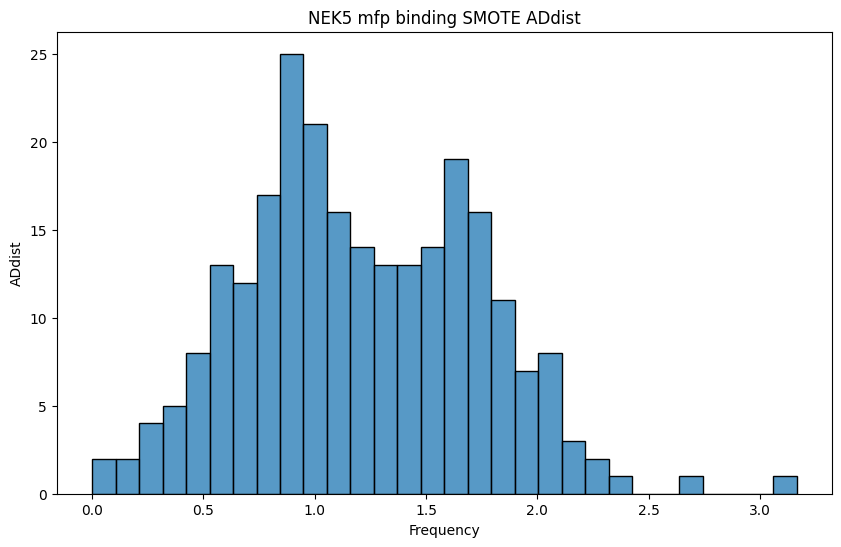

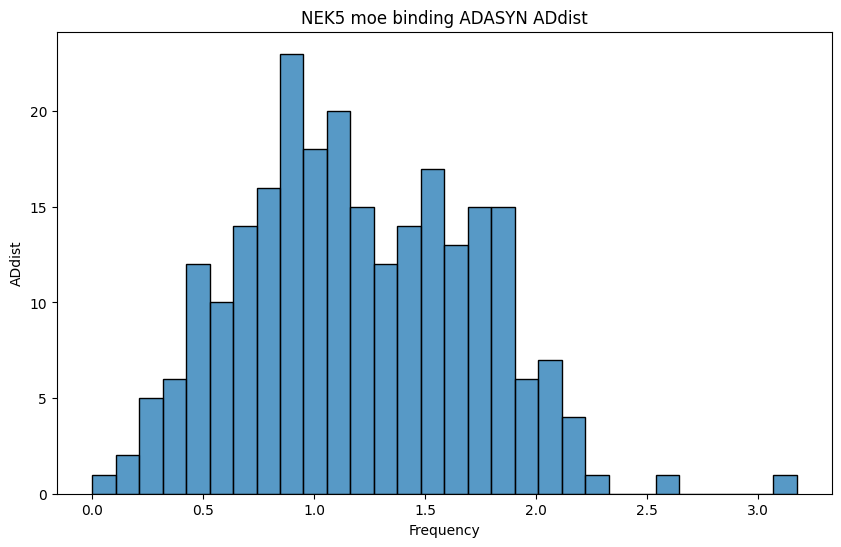

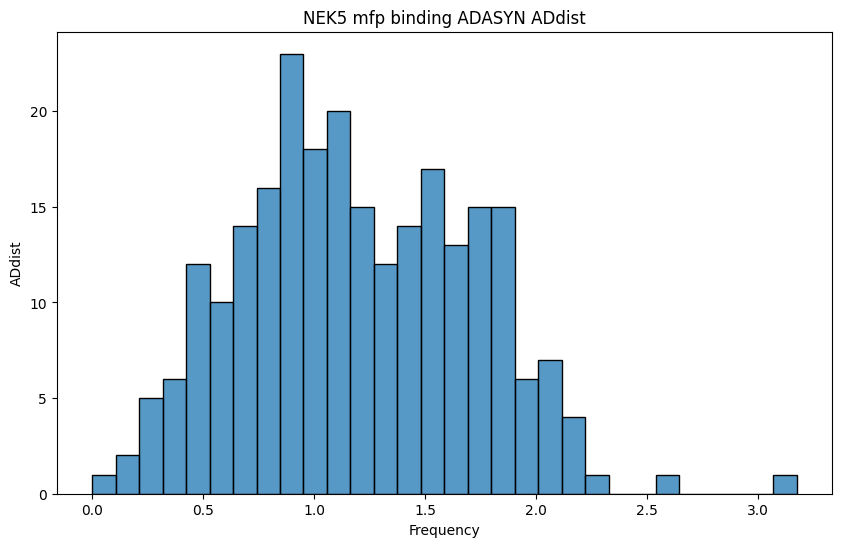

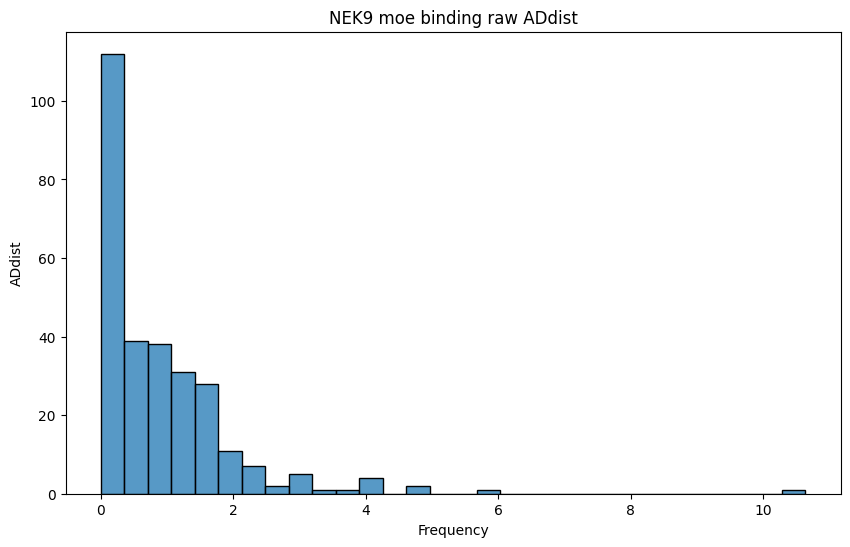

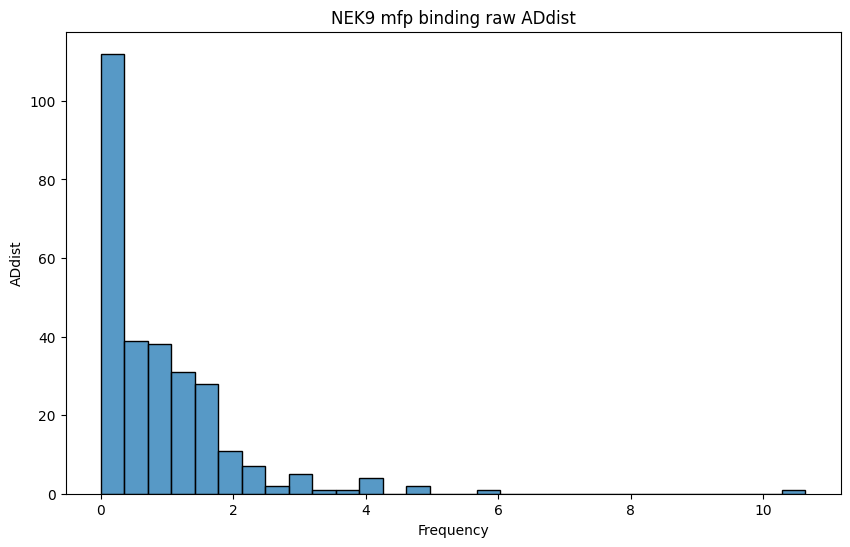

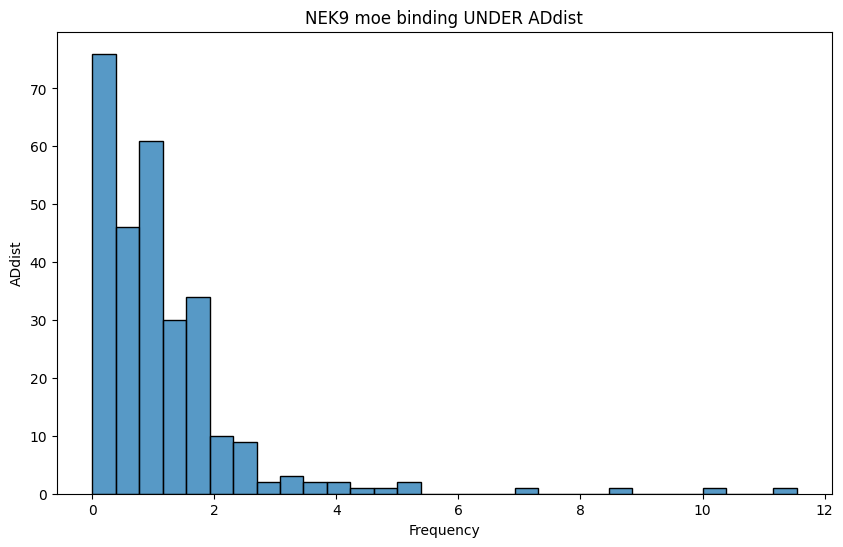

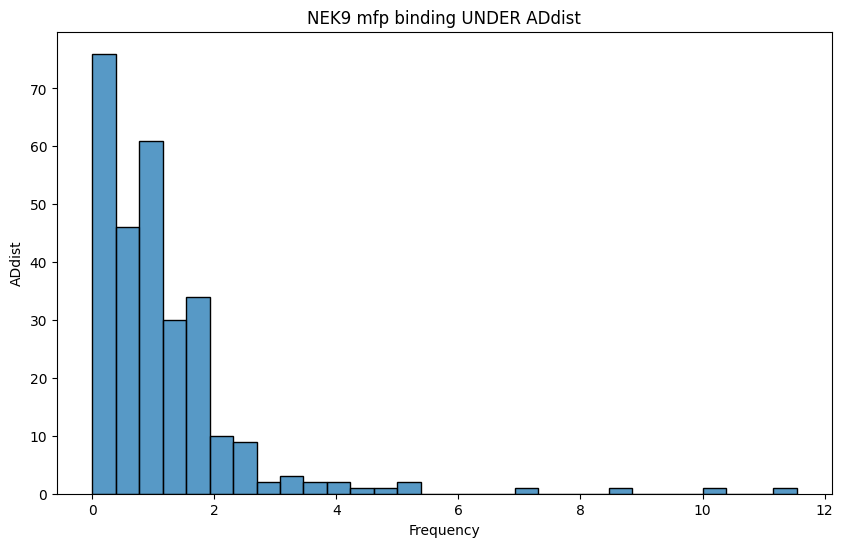

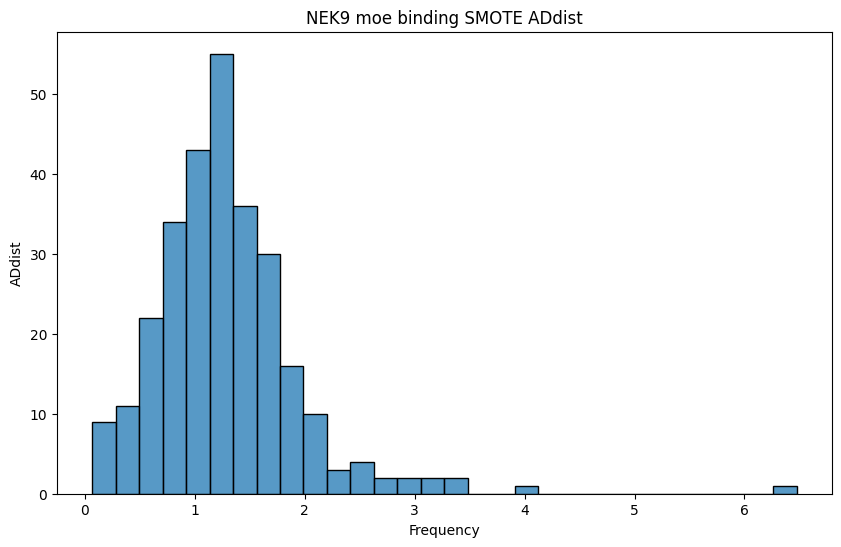

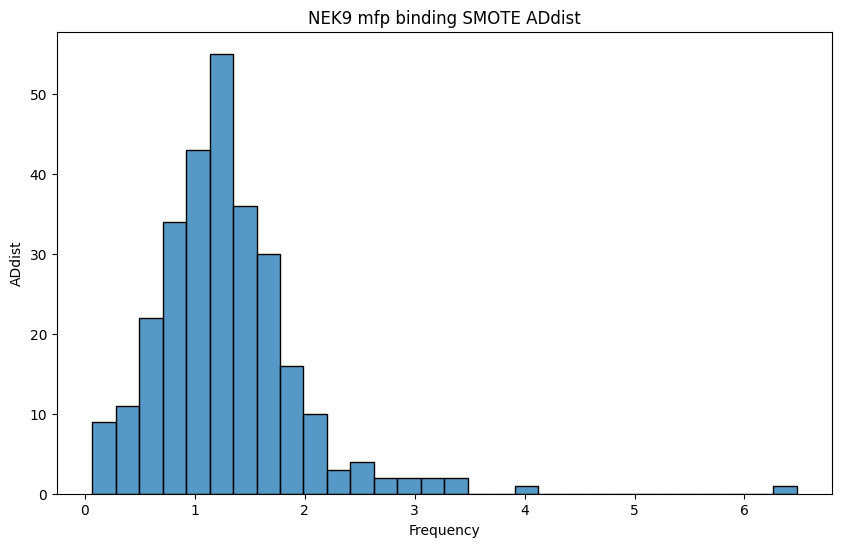

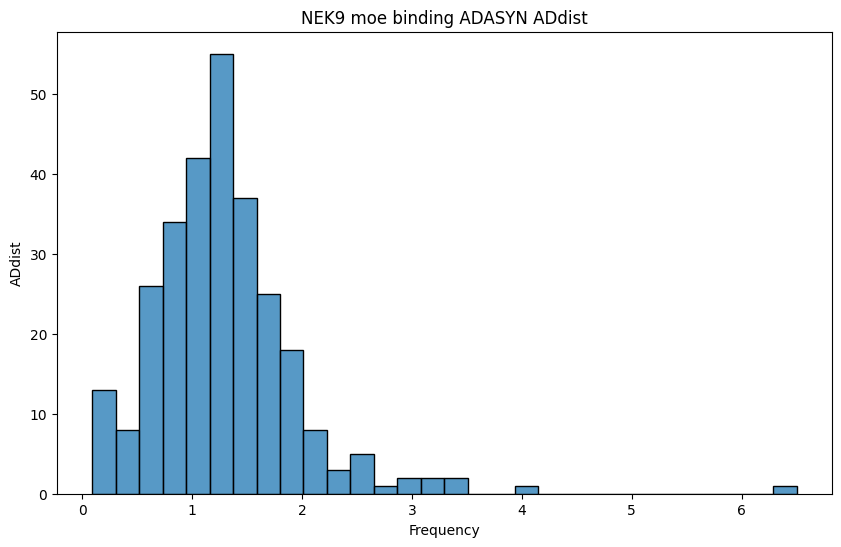

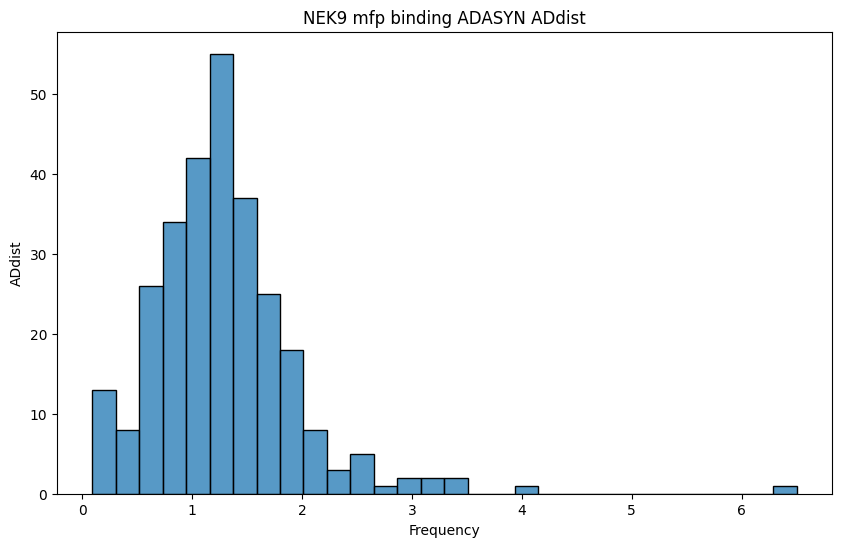

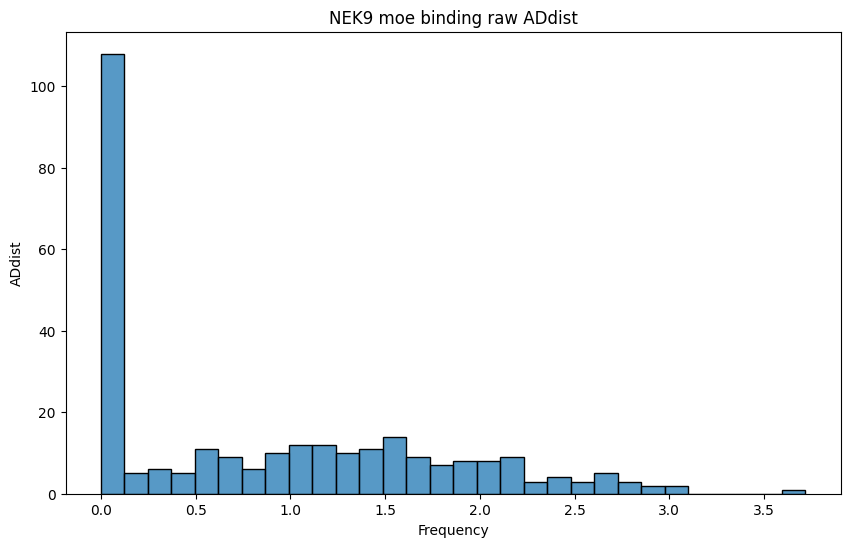

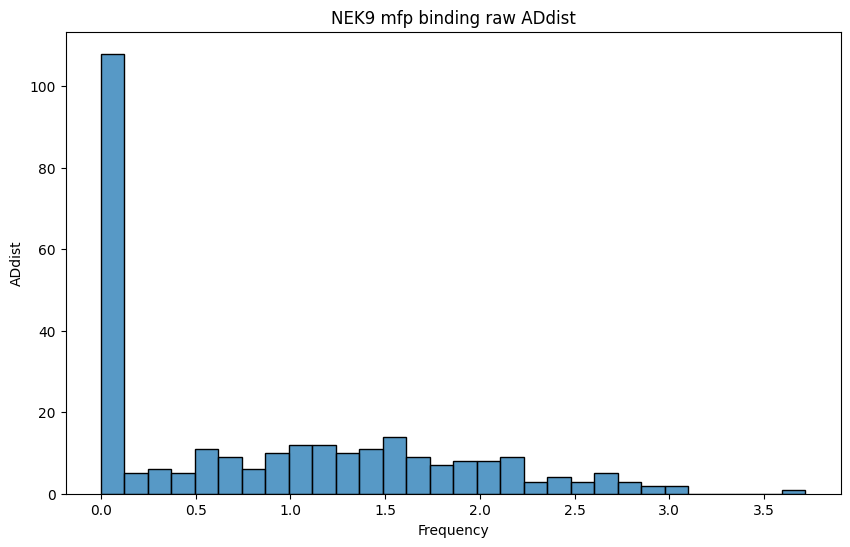

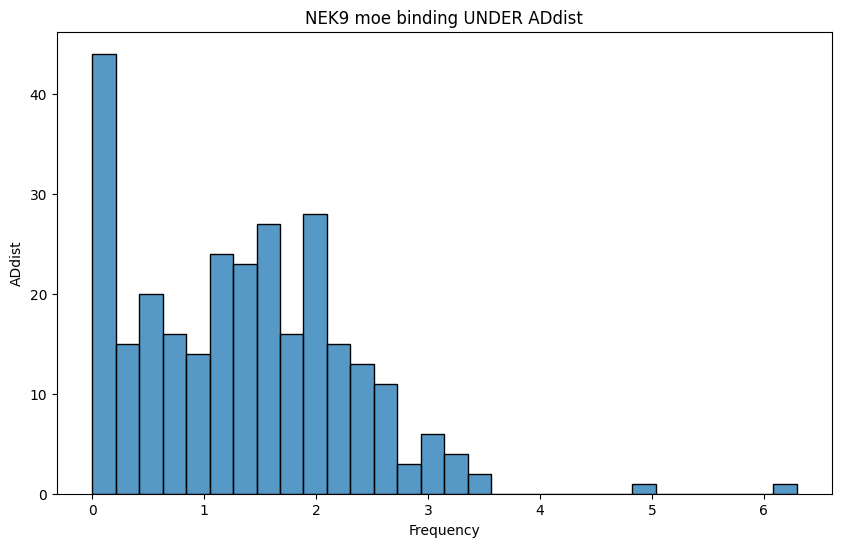

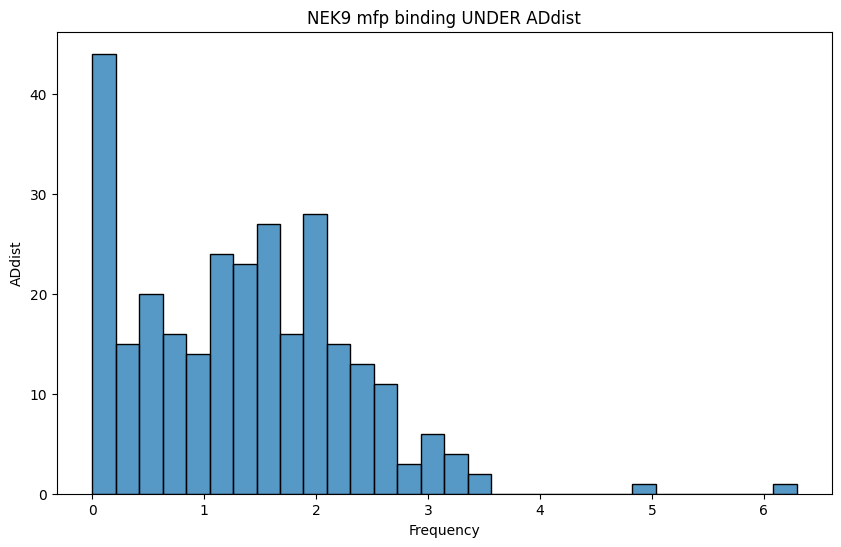

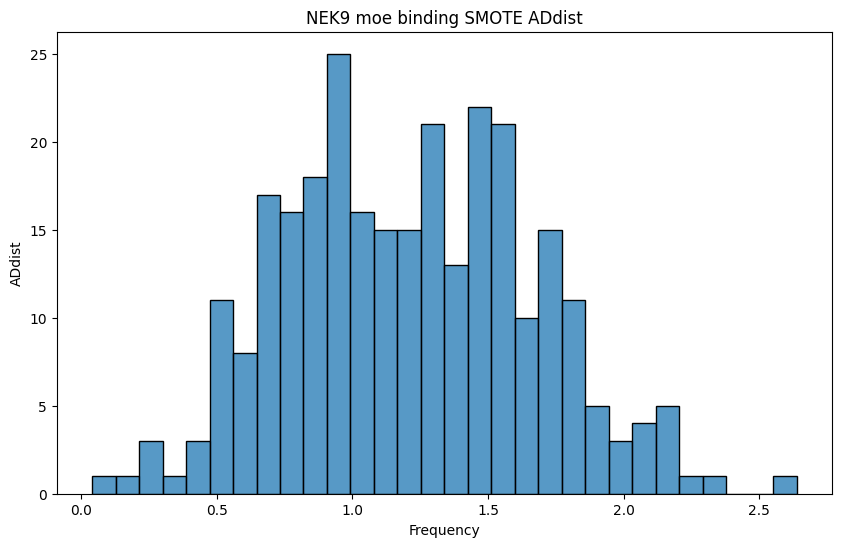

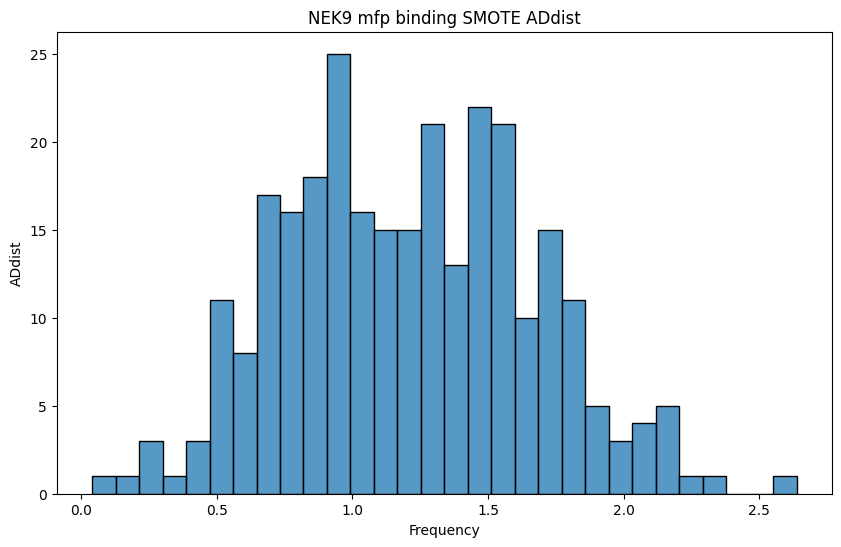

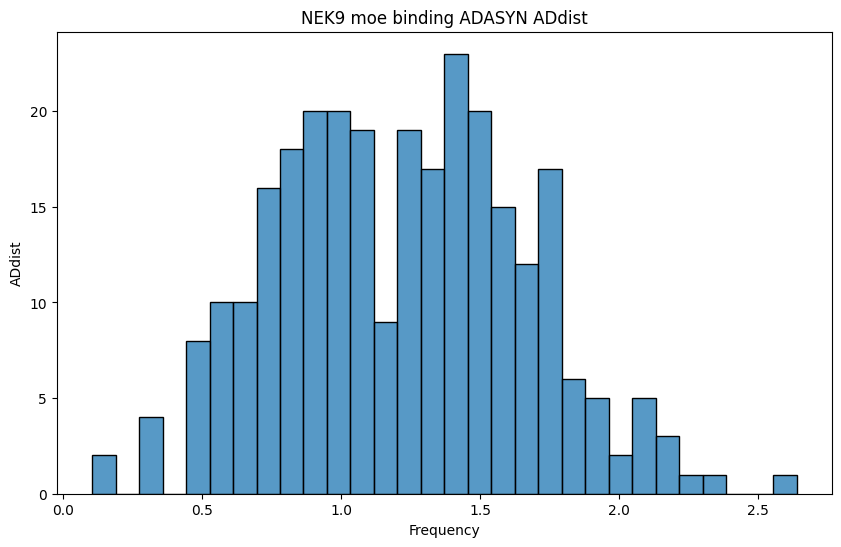

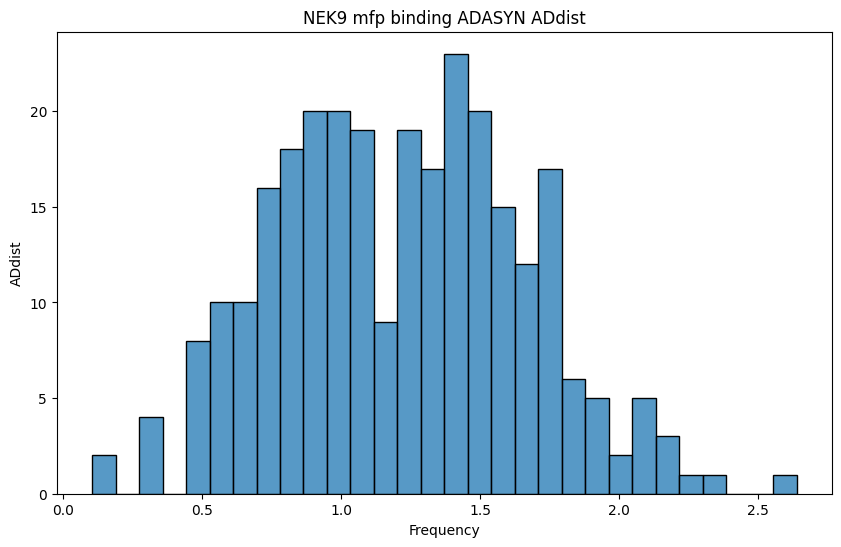

In [72]:
for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
            mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            if samp == 'scaled': 
                samp = 'raw'
            
            # Create histograms for ADdist
            histogram_ad_dist(moe_df, f'NEK{nek} moe binding {samp} ADdist', figure_path, f'NEK{nek}_binding_moe_{samp}_ADdist_hist')
            histogram_ad_dist(mfp_df, f'NEK{nek} mfp binding {samp} ADdist', figure_path, f'NEK{nek}_binding_mfp_{samp}_ADdist_hist')

            if samp == 'raw': 
                samp = 'scaled'


In [74]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

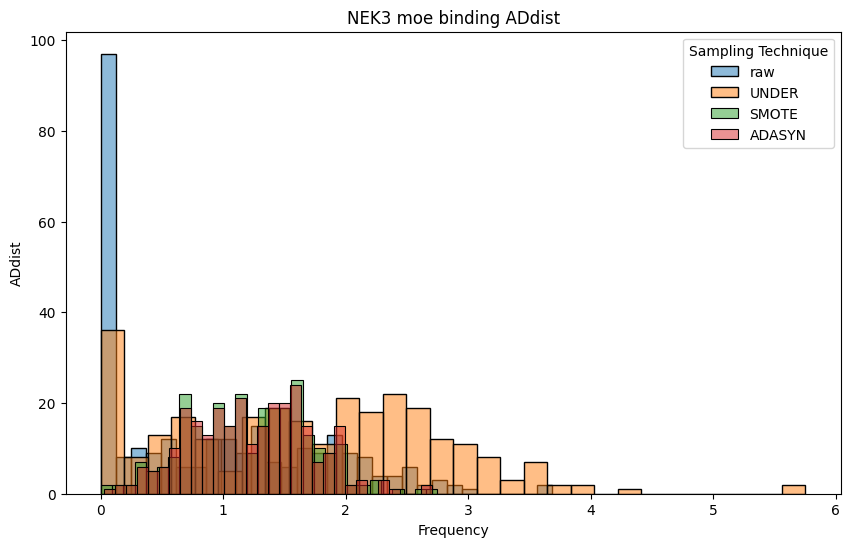

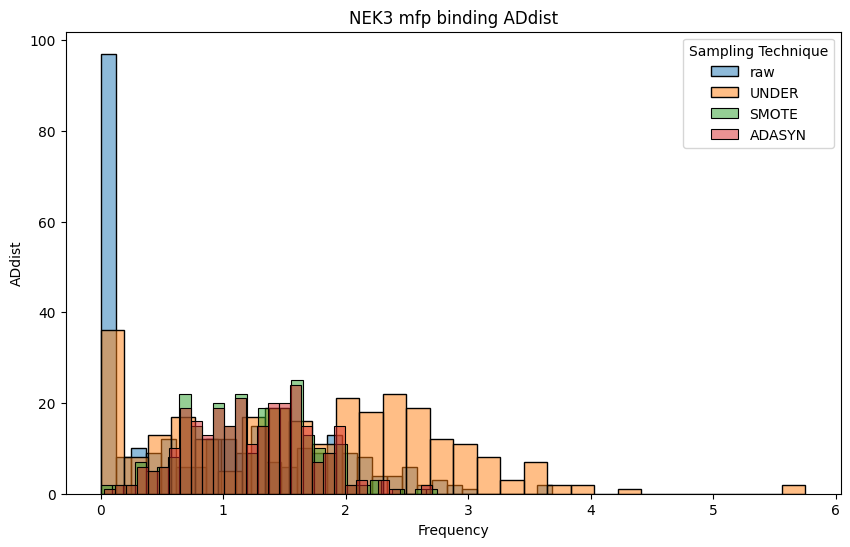

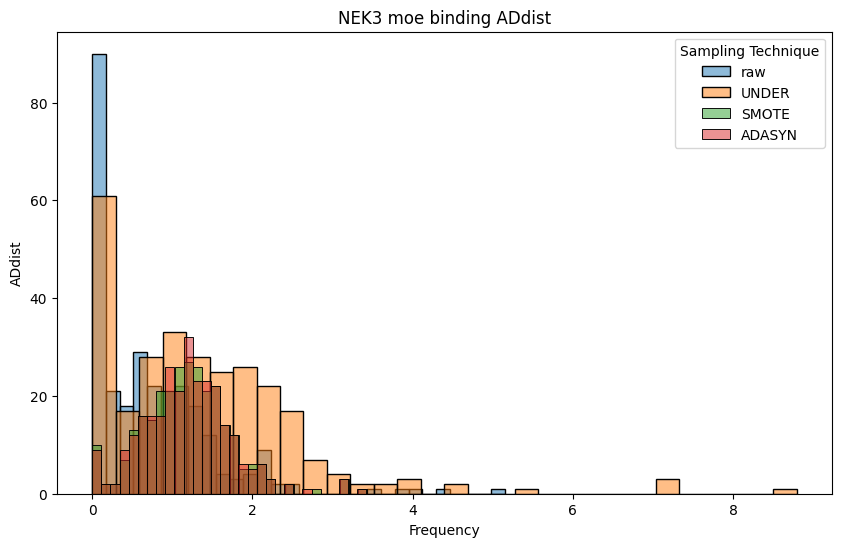

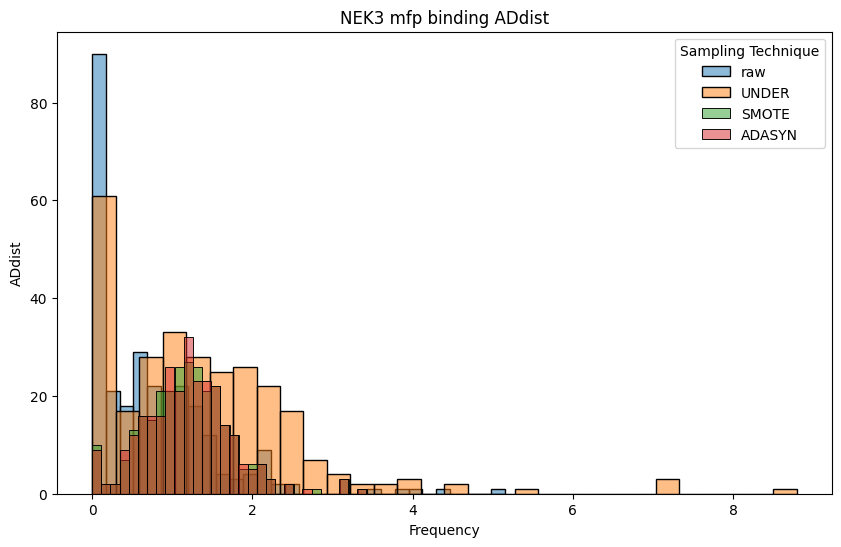

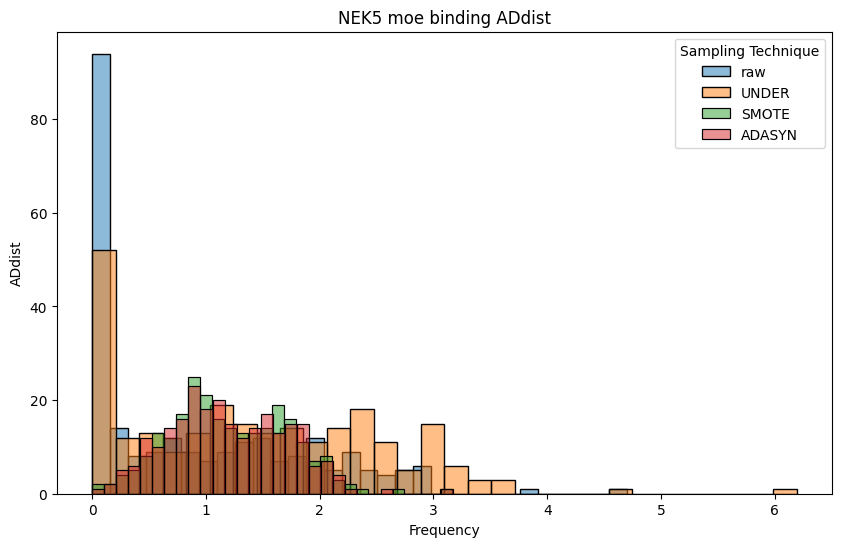

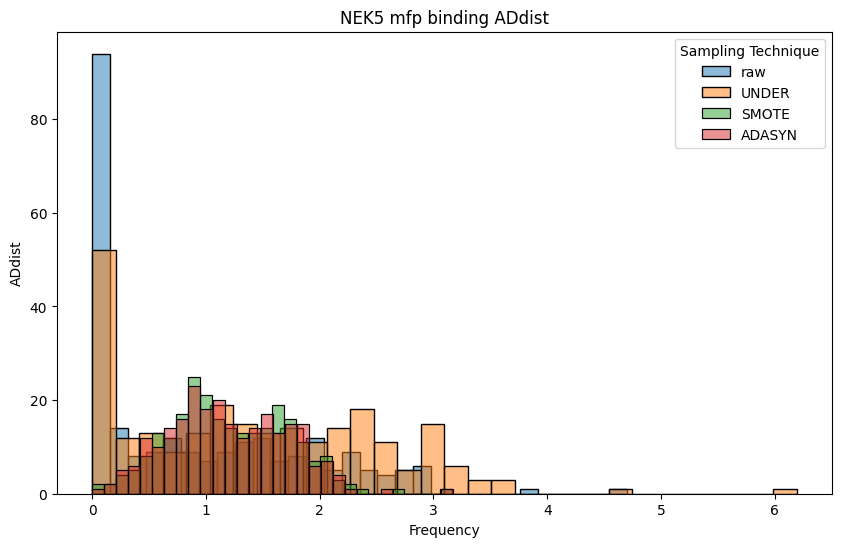

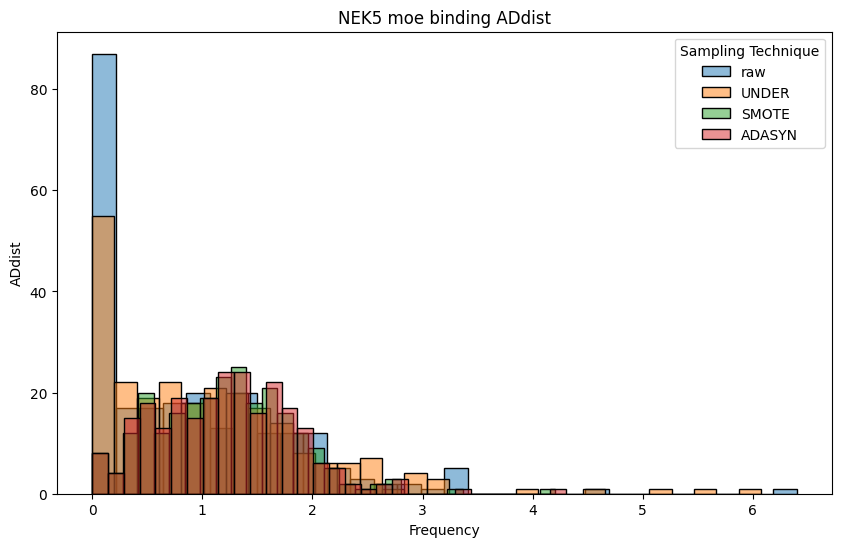

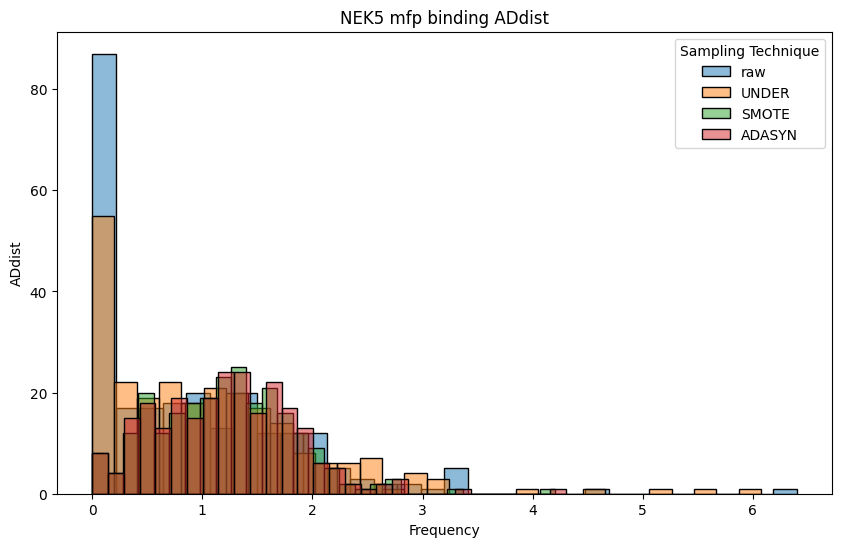

In [82]:
def layered_histogram_ad_dist(dfs, sampling_labels, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dfs, sampling_labels):
        sns.histplot(df['ADdist'], bins=30, kde=False, label=label, alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('ADdist')
    plt.legend(title='Sampling Technique')
    plt.show()

# for nek in nek_list:
#     for feat in feat_types: 
#         dfs = []
#         labels = []
        
#         for samp in samplings: 
#             df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
#             full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
#             train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
#             test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
#             test_dist = calc_AD_kmean_dist(train_df, test_df, k)
#             train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
#             moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
#             var0_moe = moe_pred['var_pred_class0'].to_numpy()
#             var1_moe = moe_pred['var_pred_class1'].to_numpy()
#             moe_preds = moe_pred['y_pred']
    
#             true_labels = moe_pred['y'].to_numpy()

#             moe_df = pd.DataFrame({'prediction': moe_preds, 'prediction_type': moe_pred['prediction_type'], 'var0': var0_moe, 'var1': var1_moe, 'ADdist': test_dist})
#             mfp_df = pd.DataFrame({'prediction': mfp_preds, 'prediction_type': mfp_pred['prediction_type'], 'var0': var0_mfp, 'var1': var1_mfp, 'ADdist': test_dist})
#             moe_df['feat_type'] = 'moe'
#             mfp_df['feat_type'] = 'mfp'
            
#             dfs.append(moe_df)
#             labels.append(samp if samp != 'scaled' else 'raw')
        
#         # Create layered histograms for ADdist after the loop populates dfs and labels
#         layered_histogram_ad_dist(dfs, labels, f'NEK{nek} moe binding ADdist', figure_path, f'NEK{nek}_binding_moe_ADdist_hist')
#         layered_histogram_ad_dist(dfs, labels, f'NEK{nek} mfp binding ADdist', figure_path, f'NEK{nek}_binding_mfp_ADdist_hist')

for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')

            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp = mfp_pred['var_pred_class1'].to_numpy()

            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            # Ensure all arrays are the same length
            min_length = min(len(moe_preds), len(var0_moe), len(var1_moe), len(test_dist),
                             len(mfp_preds), len(var0_mfp), len(var1_mfp))

            moe_df = pd.DataFrame({
                'prediction': moe_preds[:min_length],
                'prediction_type': moe_pred['prediction_type'][:min_length],
                'var0': var0_moe[:min_length],
                'var1': var1_moe[:min_length],
                'ADdist': test_dist[:min_length]
            })
            moe_df['feat_type'] = 'moe'

            mfp_df = pd.DataFrame({
                'prediction': mfp_preds[:min_length],
                'prediction_type': mfp_pred['prediction_type'][:min_length],
                'var0': var0_mfp[:min_length],
                'var1': var1_mfp[:min_length],
                'ADdist': test_dist[:min_length]
            })
            mfp_df['feat_type'] = 'mfp'
            
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered histograms for ADdist after the loop populates dfs and labels
        layered_histogram_ad_dist(dfs_moe, labels, f'NEK{nek} moe binding ADdist', figure_path, f'NEK{nek}_binding_moe_ADdist_hist')
        layered_histogram_ad_dist(dfs_mfp, labels, f'NEK{nek} mfp binding ADdist', figure_path, f'NEK{nek}_binding_mfp_ADdist_hist')


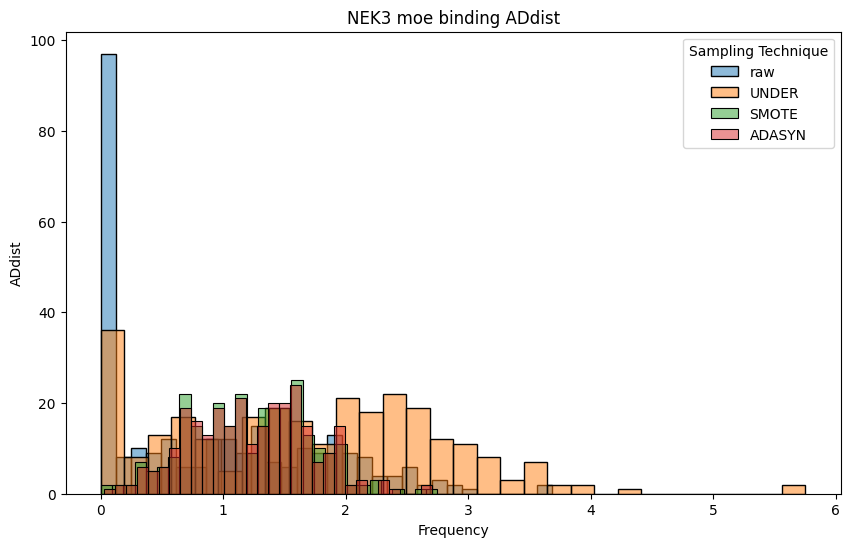

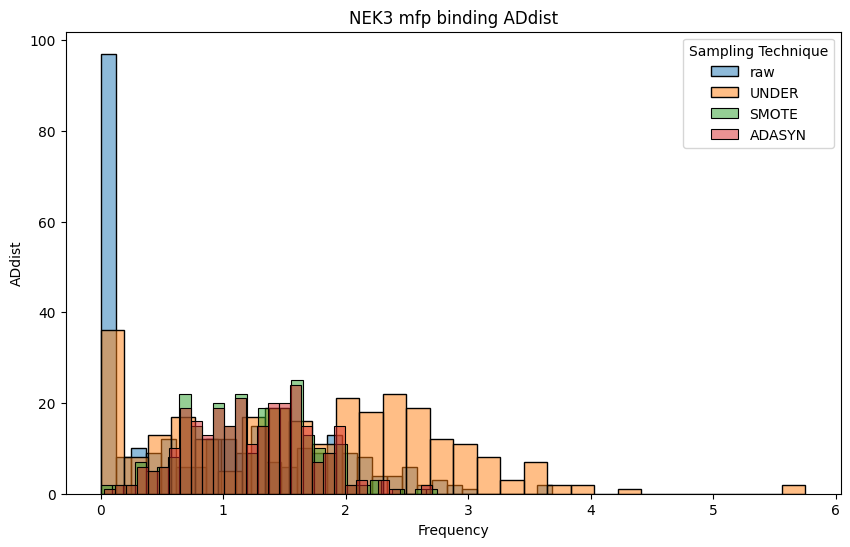

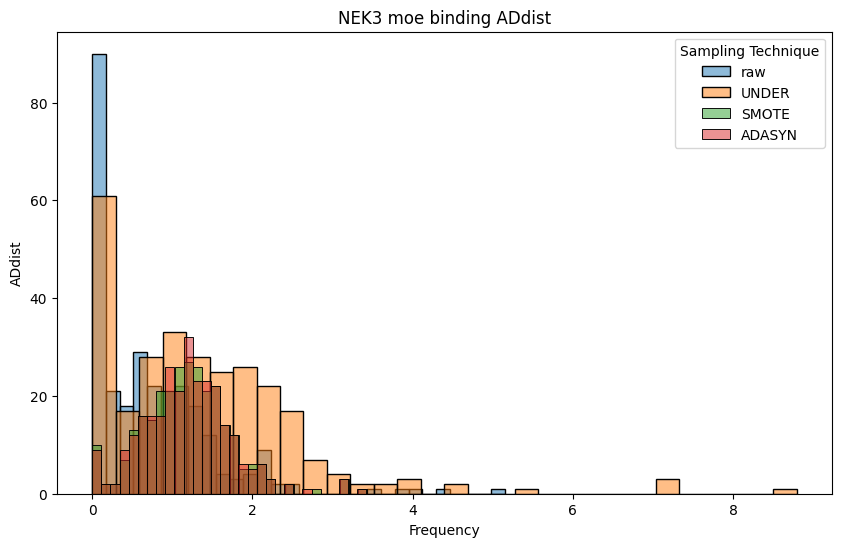

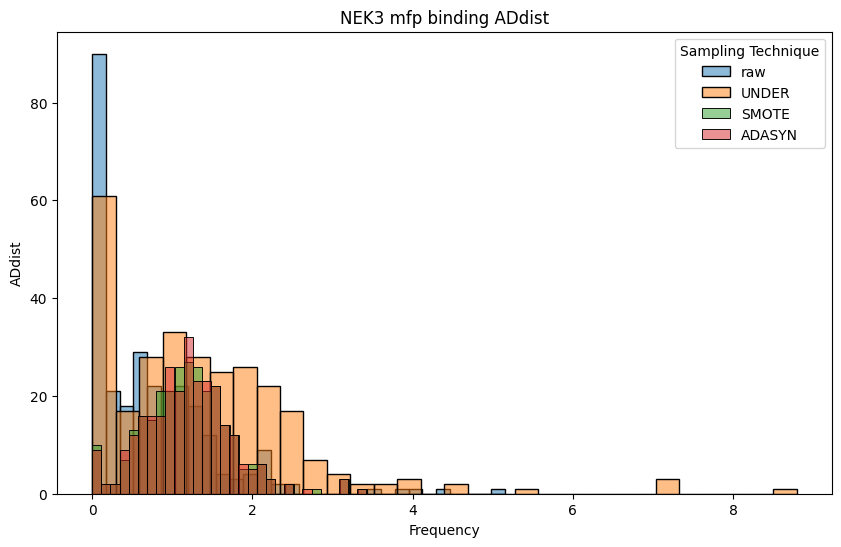

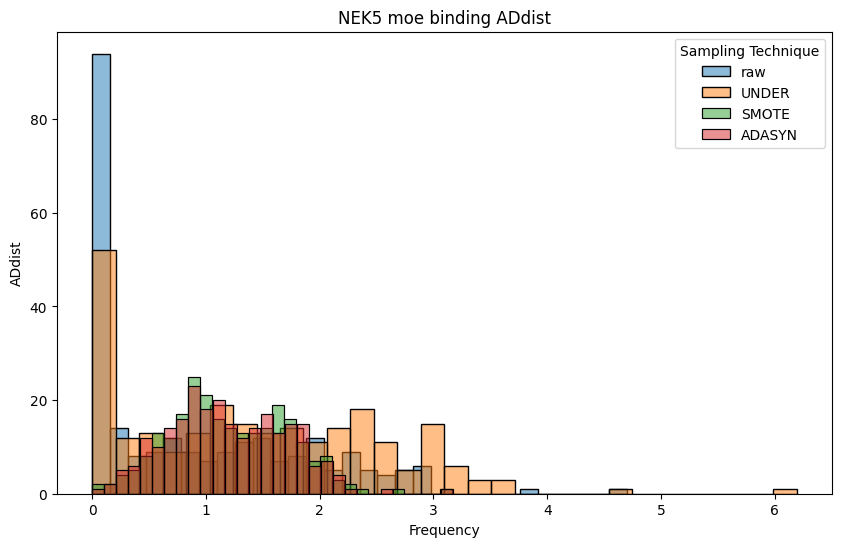

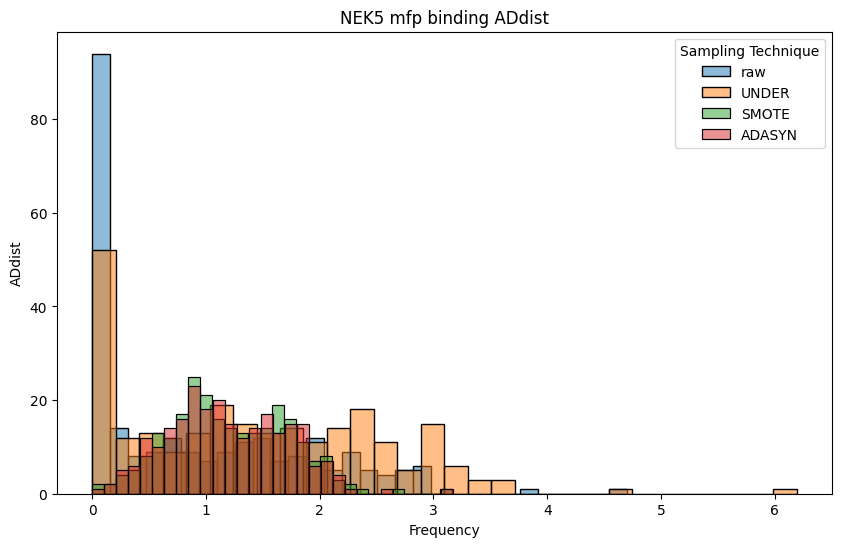

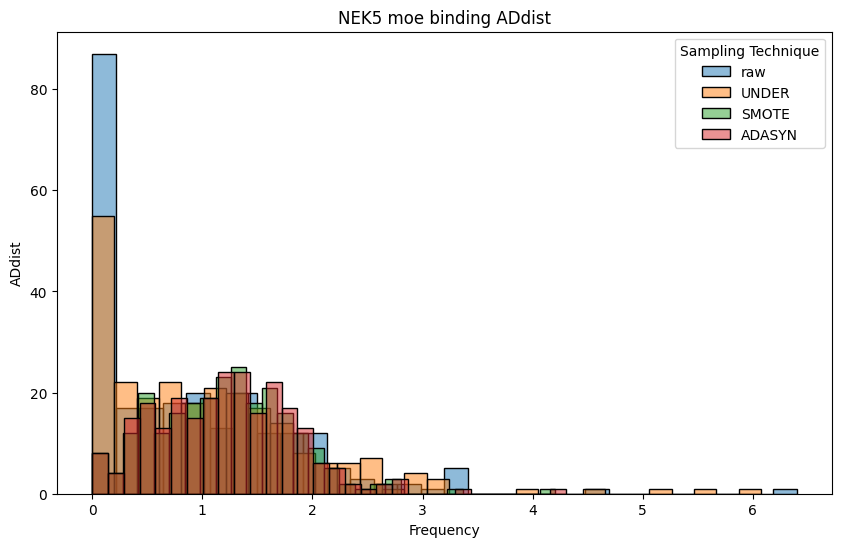

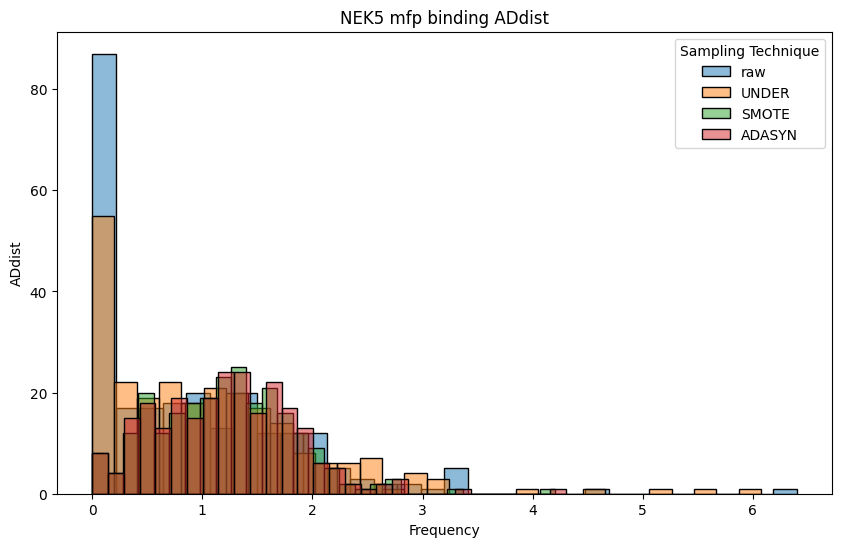

In [84]:


for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')

            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp = mfp_pred['var_pred_class1'].to_numpy()

            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            # Ensure all arrays are the same length
            min_length = min(len(moe_preds), len(var0_moe), len(var1_moe), len(test_dist),
                             len(mfp_preds), len(var0_mfp), len(var1_mfp))

            moe_df = pd.DataFrame({
                'prediction': moe_preds[:min_length],
                'prediction_type': moe_pred['prediction_type'][:min_length],
                'var0': var0_moe[:min_length],
                'var1': var1_moe[:min_length],
                'ADdist': test_dist[:min_length]
            })
            moe_df['feat_type'] = 'moe'

            mfp_df = pd.DataFrame({
                'prediction': mfp_preds[:min_length],
                'prediction_type': mfp_pred['prediction_type'][:min_length],
                'var0': var0_mfp[:min_length],
                'var1': var1_mfp[:min_length],
                'ADdist': test_dist[:min_length]
            })
            mfp_df['feat_type'] = 'mfp'
            
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered histograms for ADdist after the loop populates dfs and labels
        layered_histogram_ad_dist(dfs_moe, labels, f'NEK{nek} moe binding ADdist', figure_path, f'NEK{nek}_binding_moe_ADdist_hist')
        layered_histogram_ad_dist(dfs_mfp, labels, f'NEK{nek} mfp binding ADdist', figure_path, f'NEK{nek}_binding_mfp_ADdist_hist')


In [89]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
col_names = ['prediction_type', 'ADdist', 'model_type']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category_order = ['TP', 'TN', 'FP', 'FN']
k=7

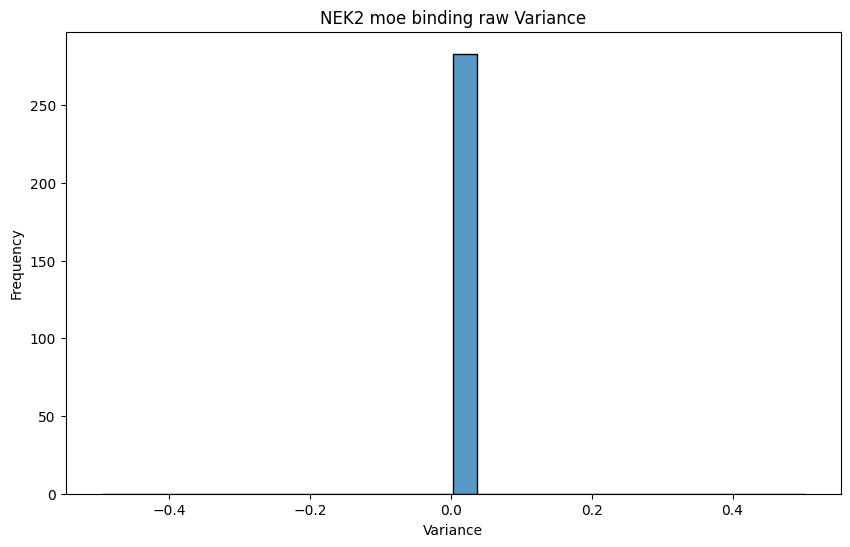

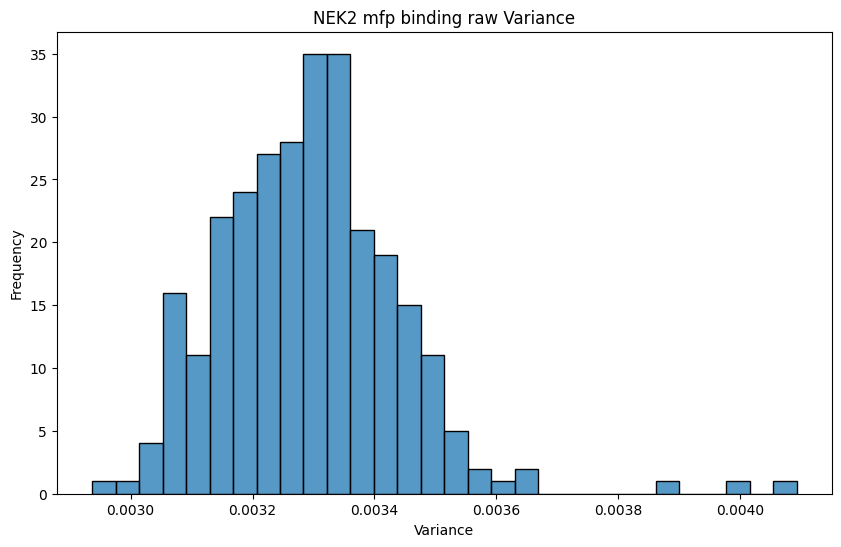

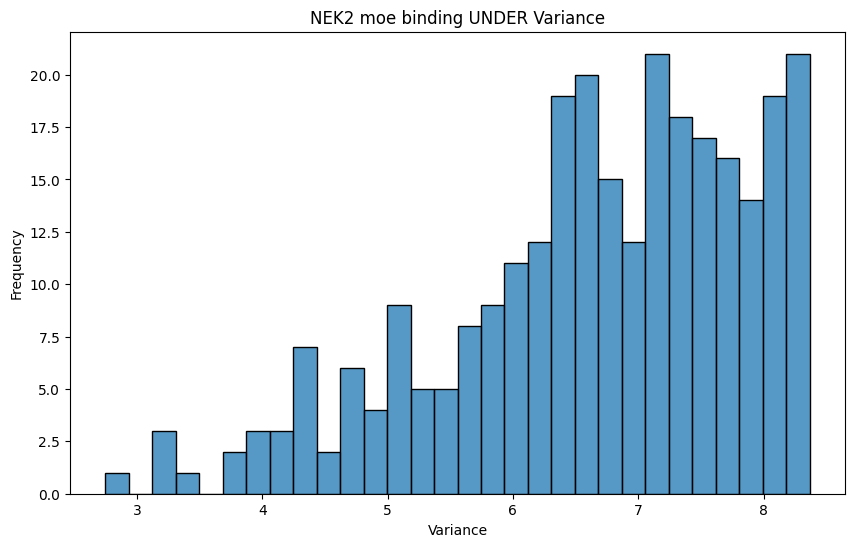

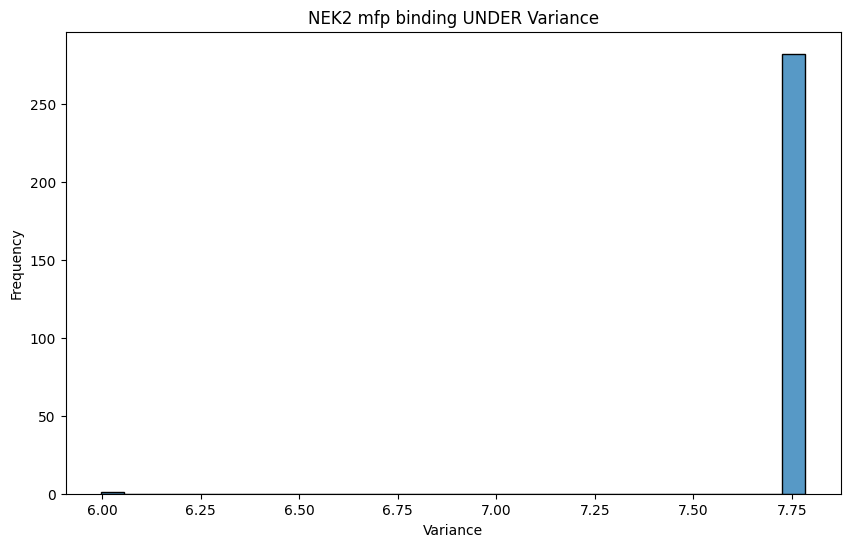

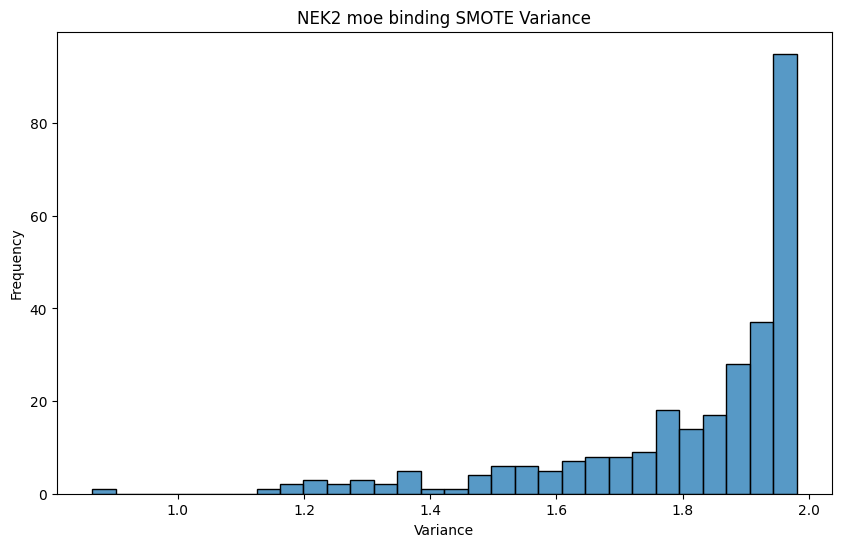

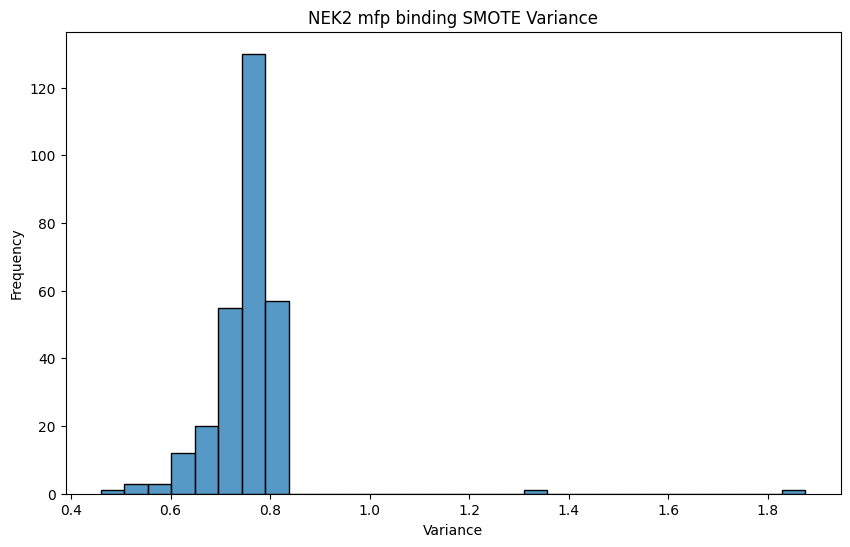

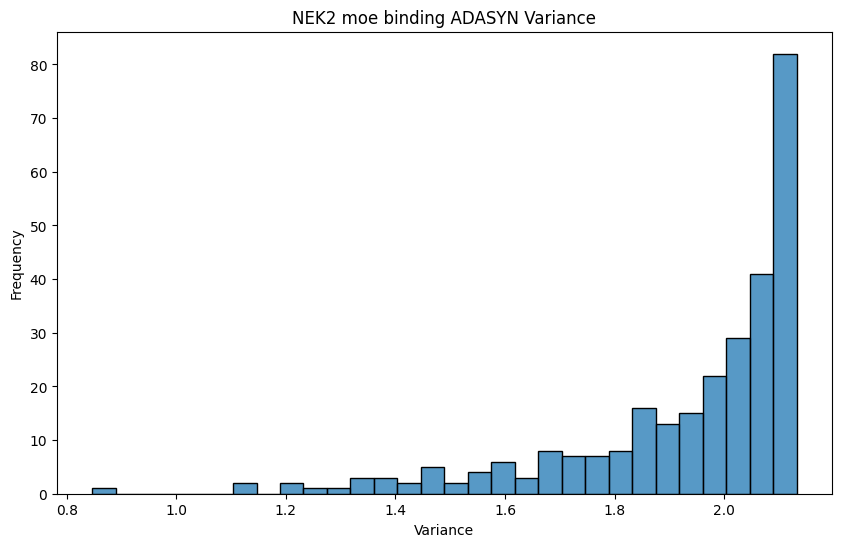

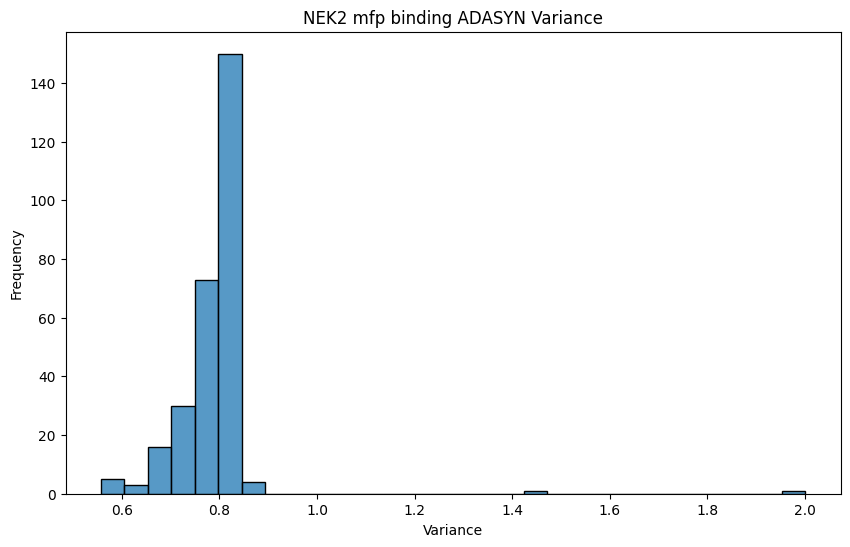

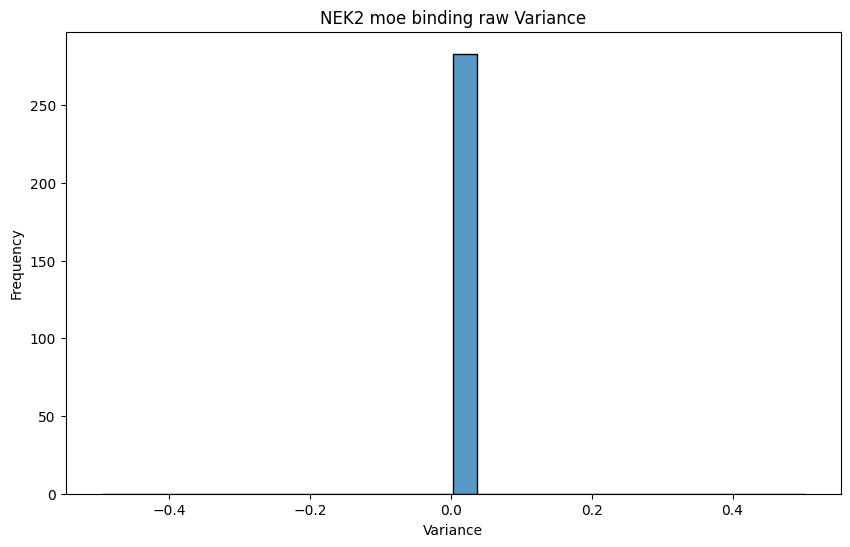

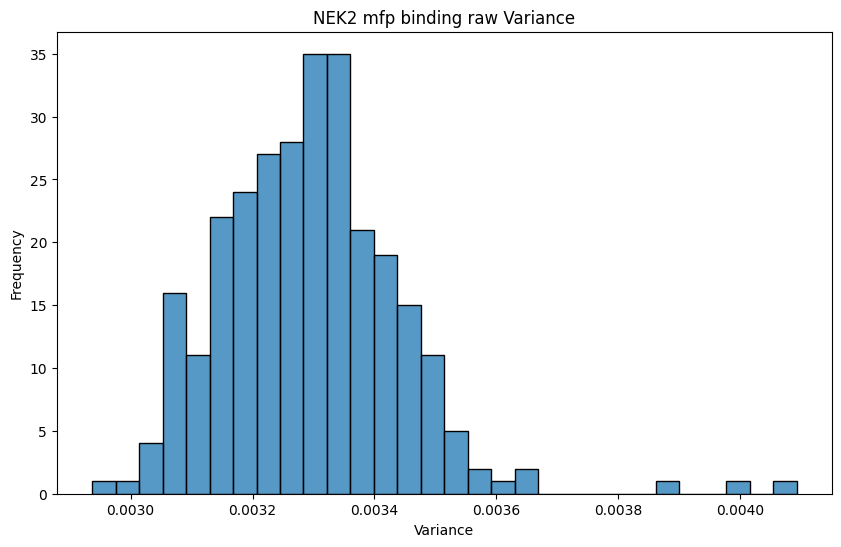

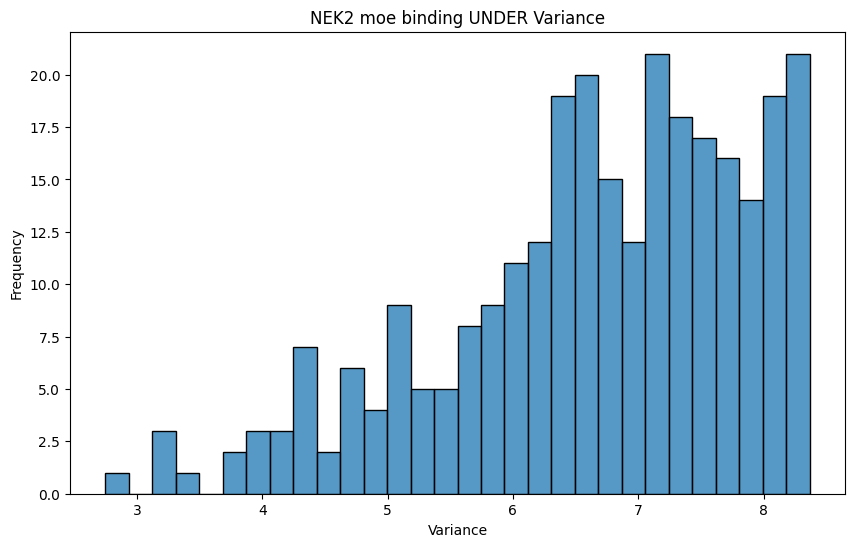

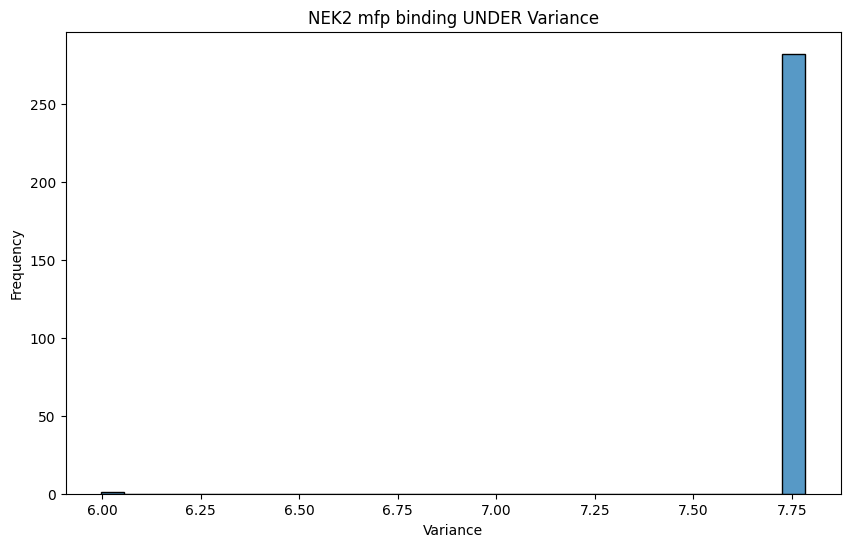

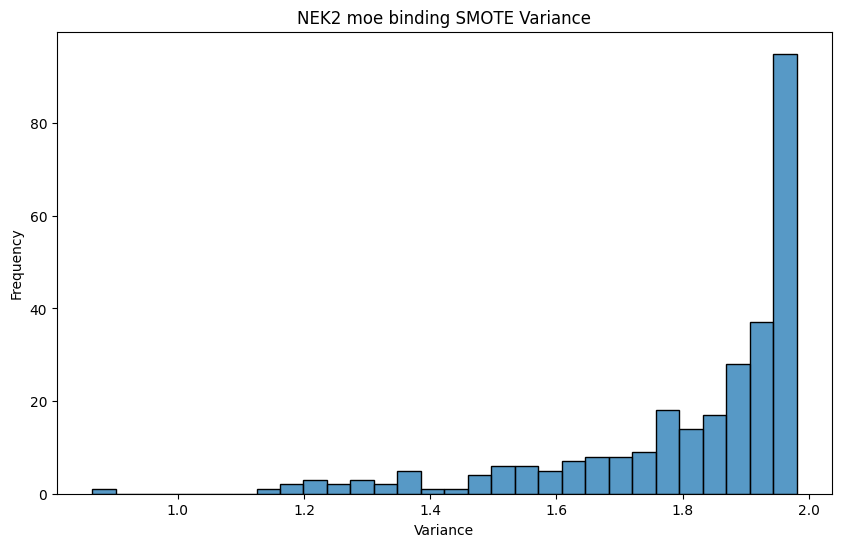

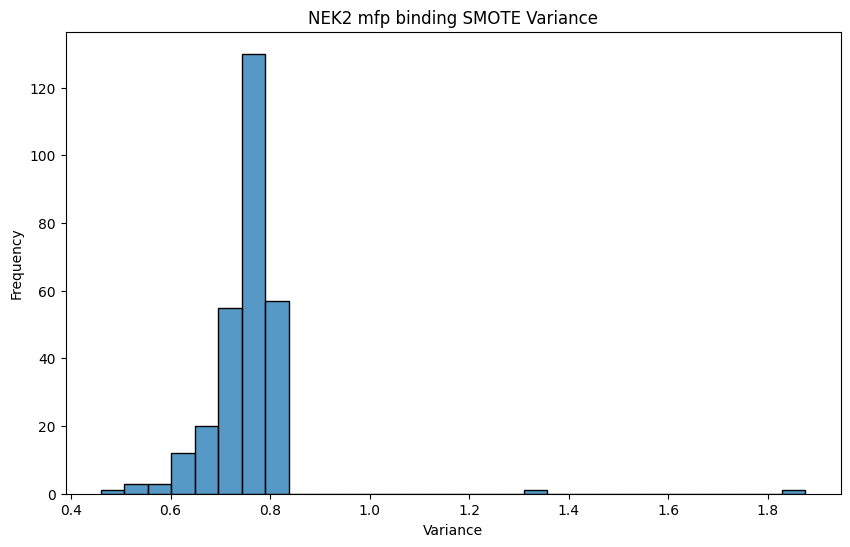

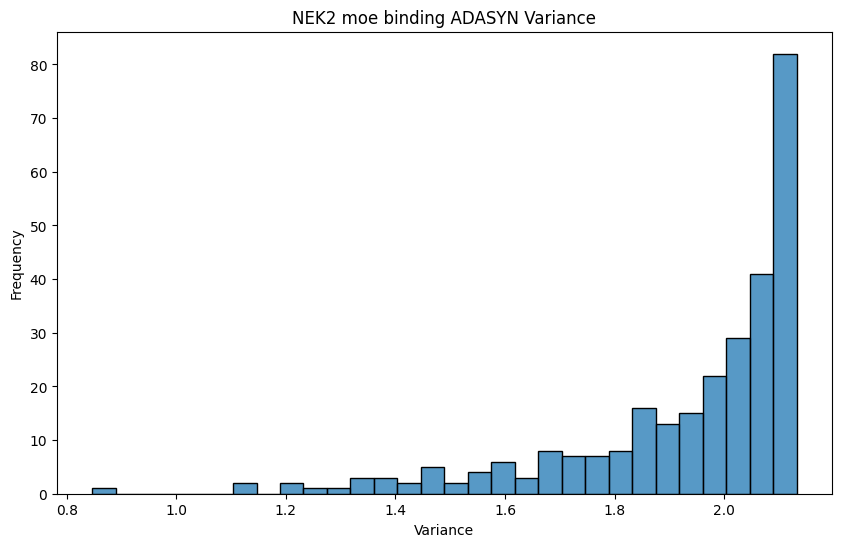

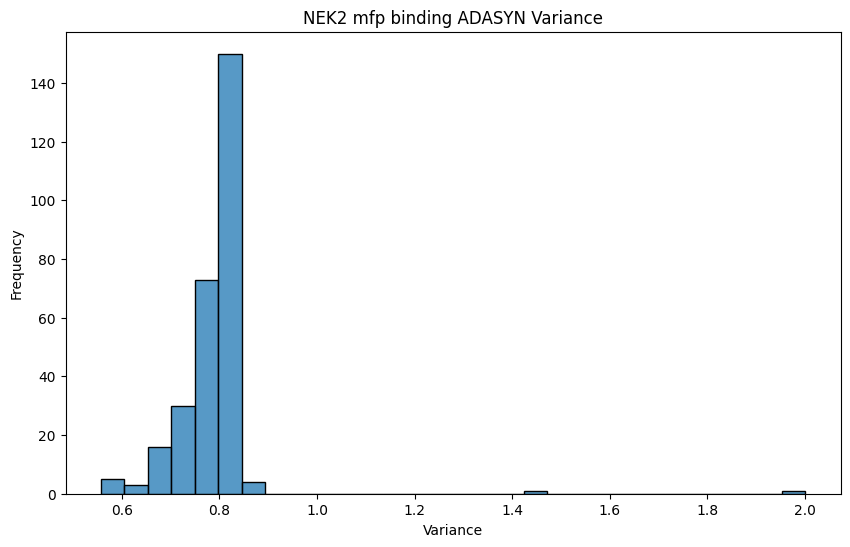

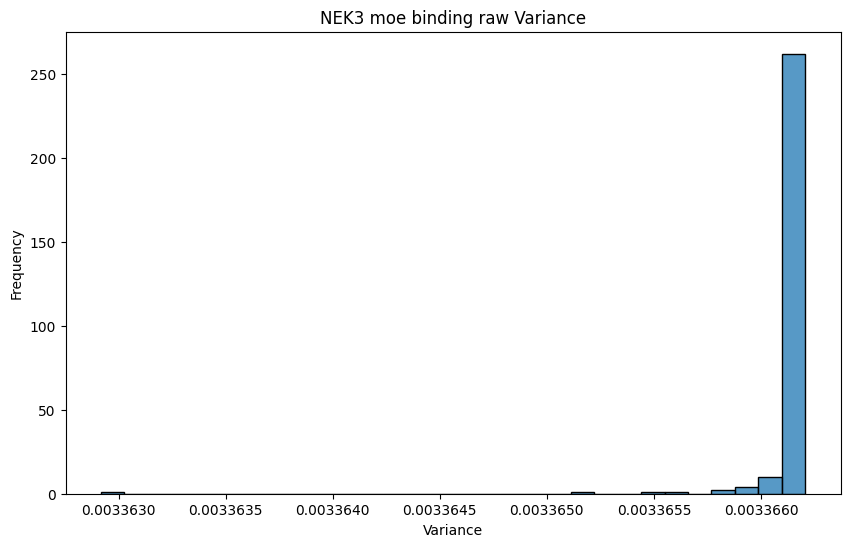

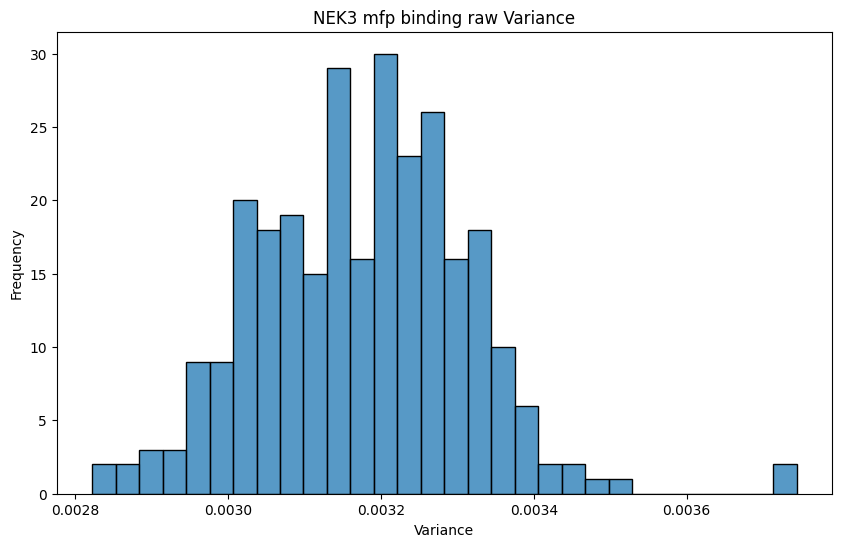

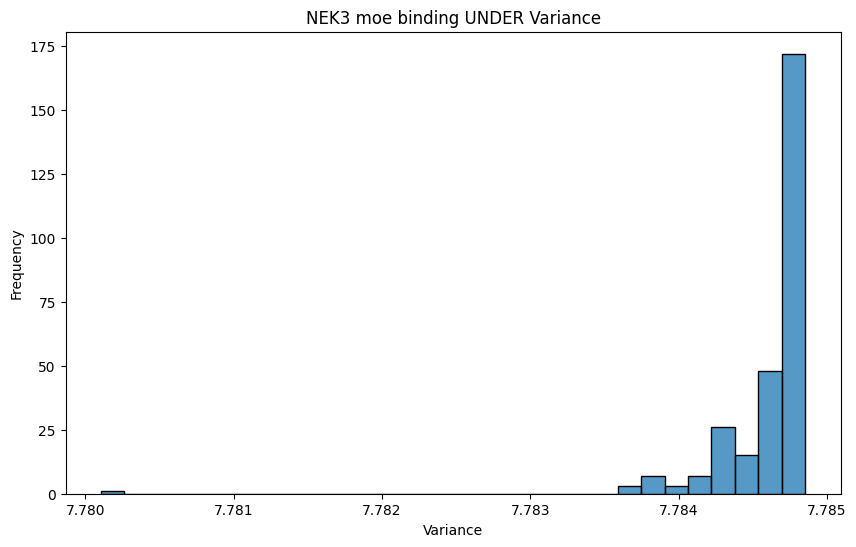

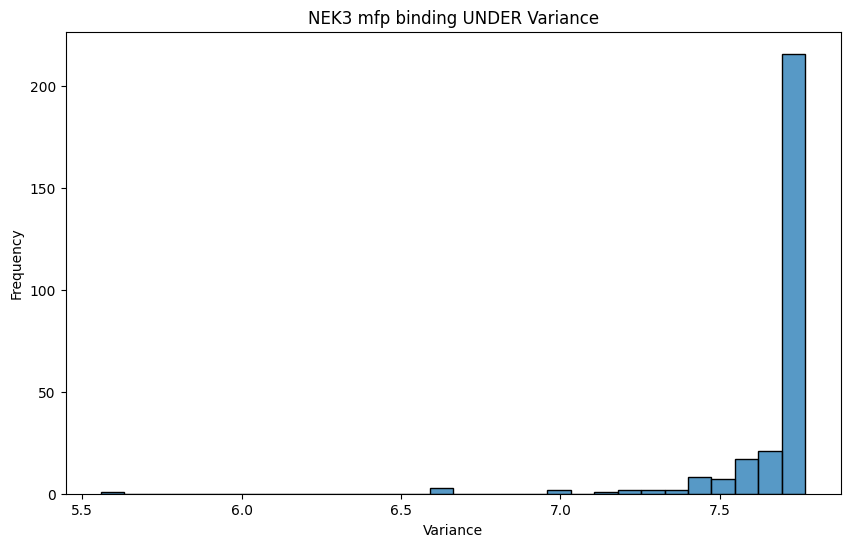

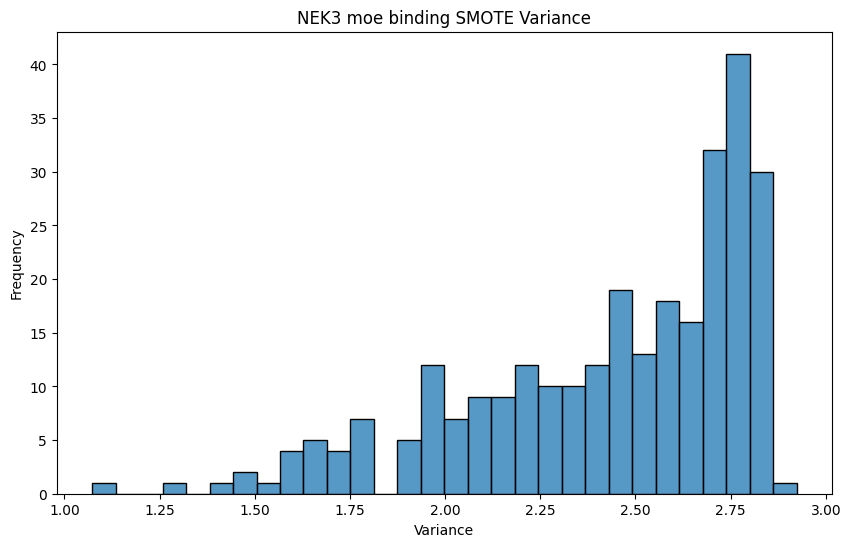

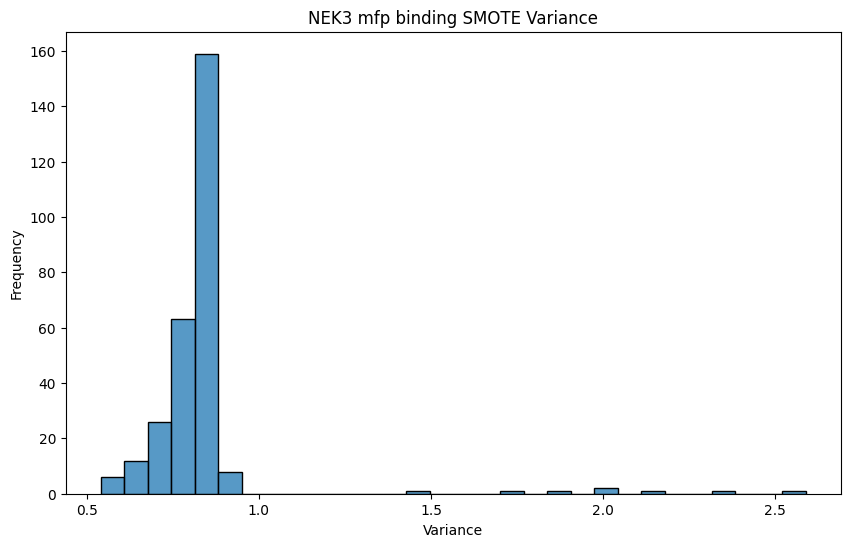

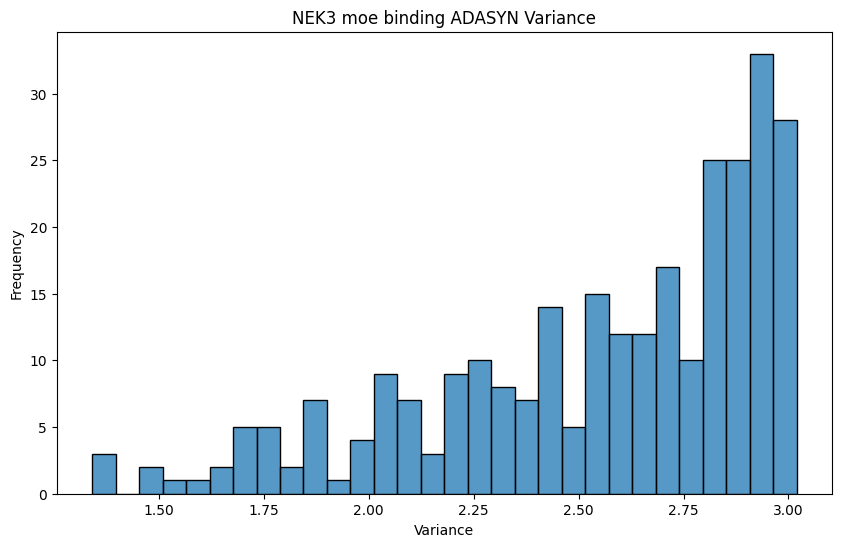

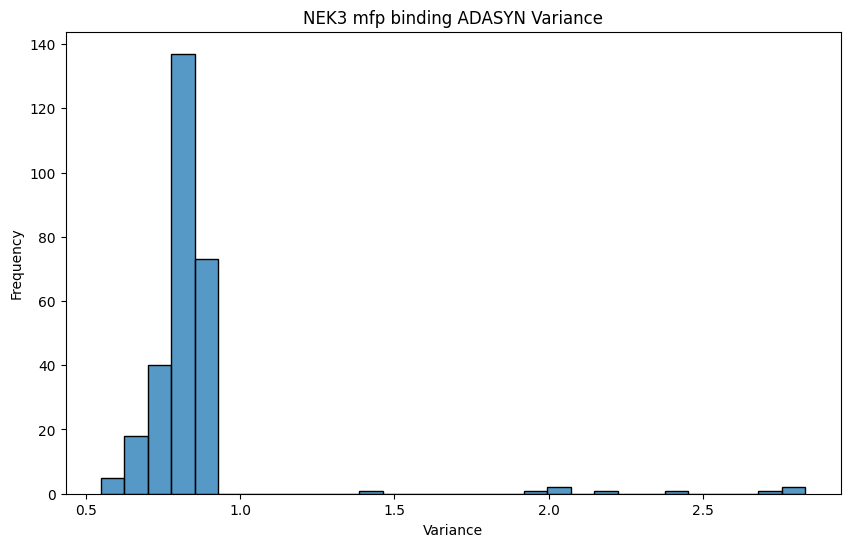

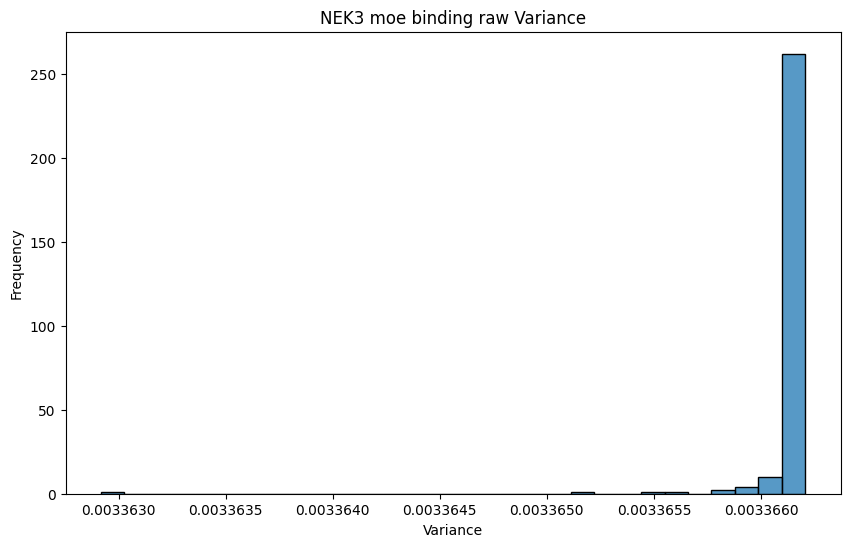

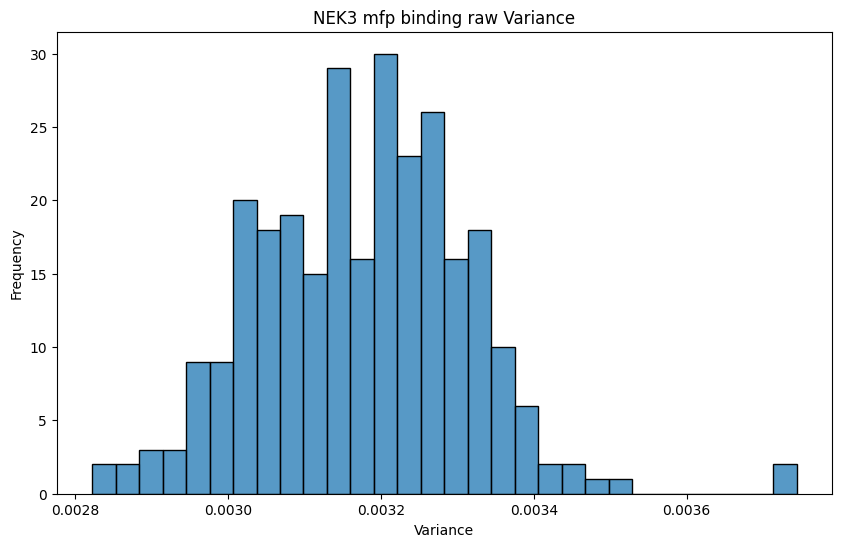

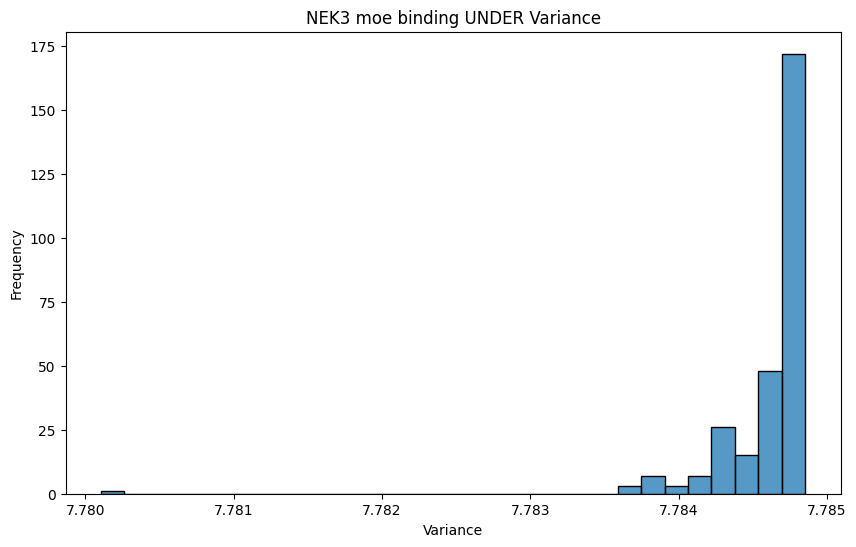

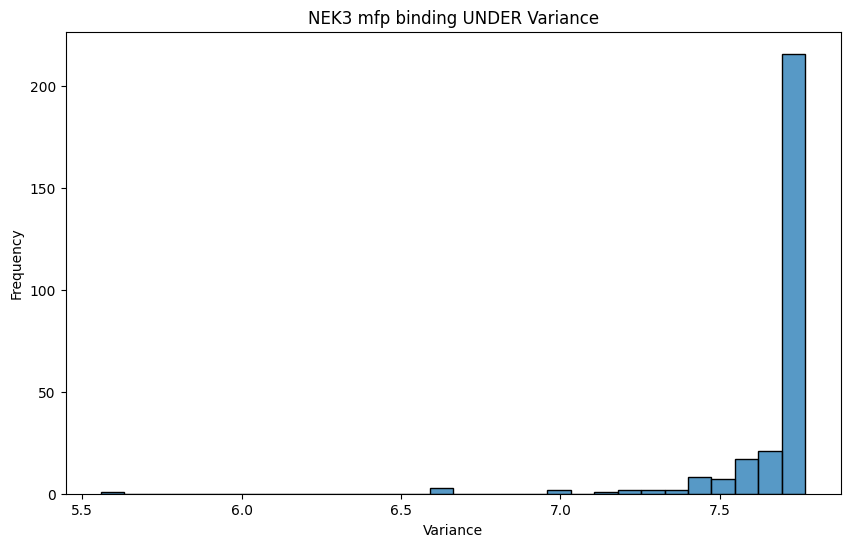

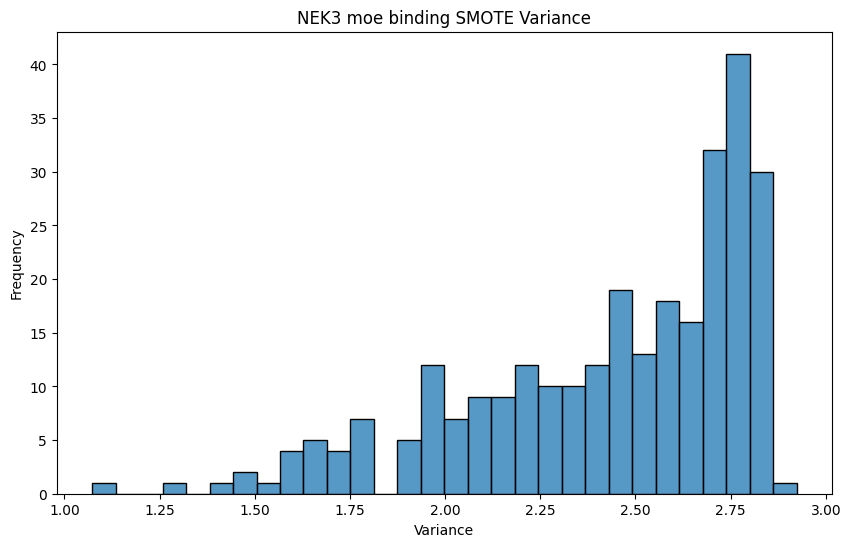

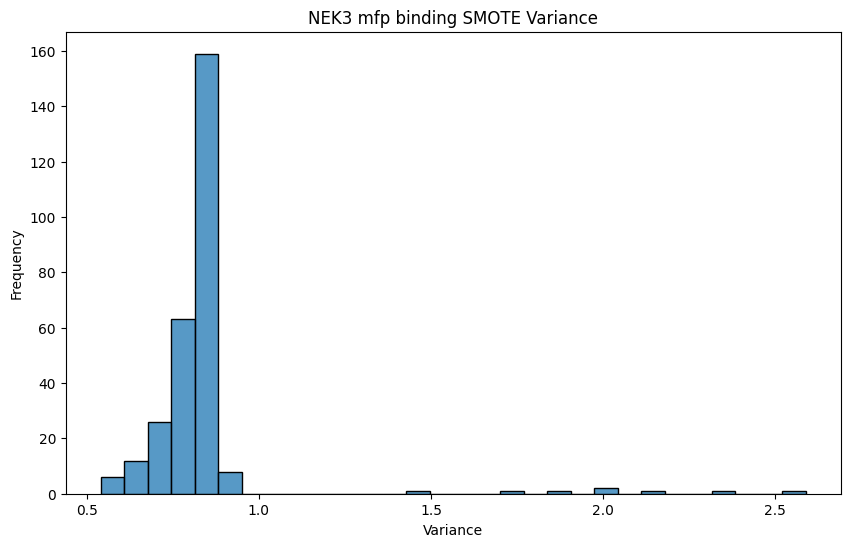

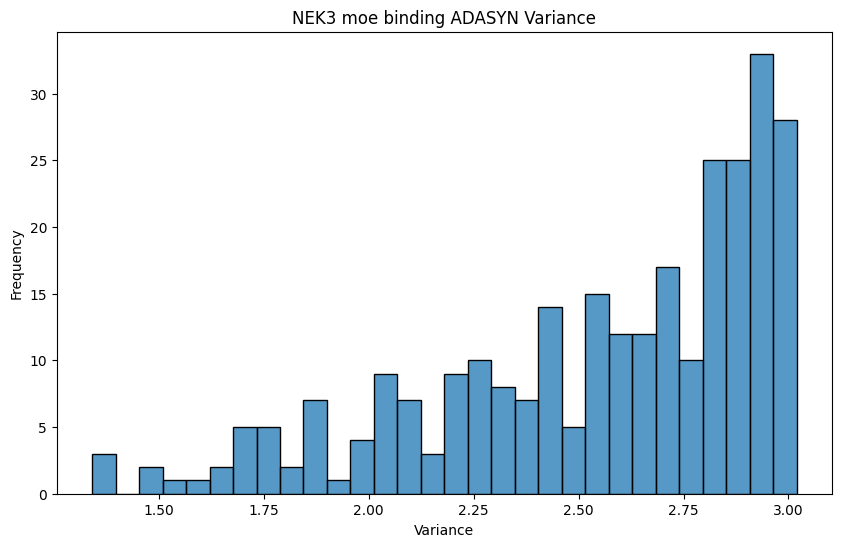

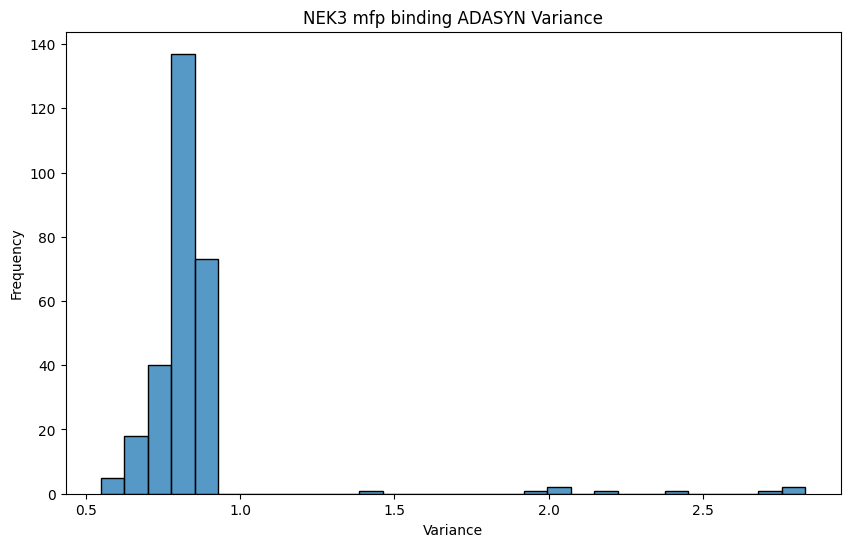

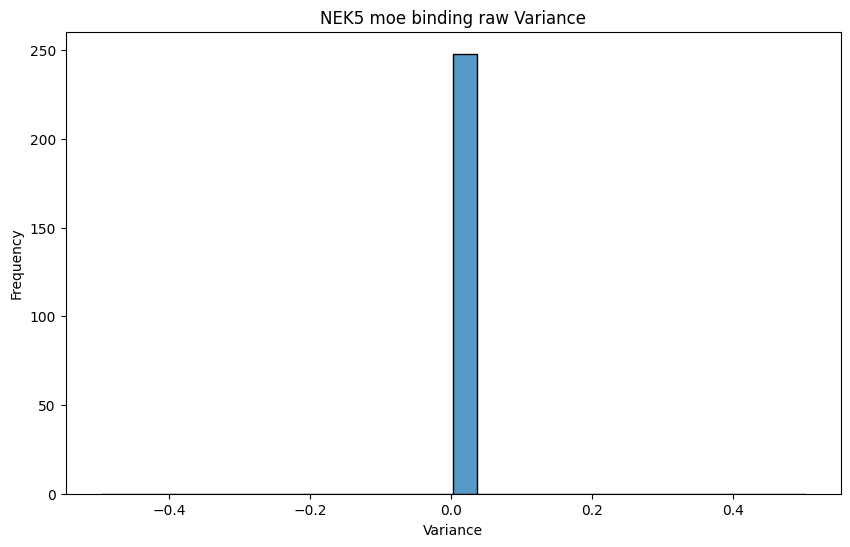

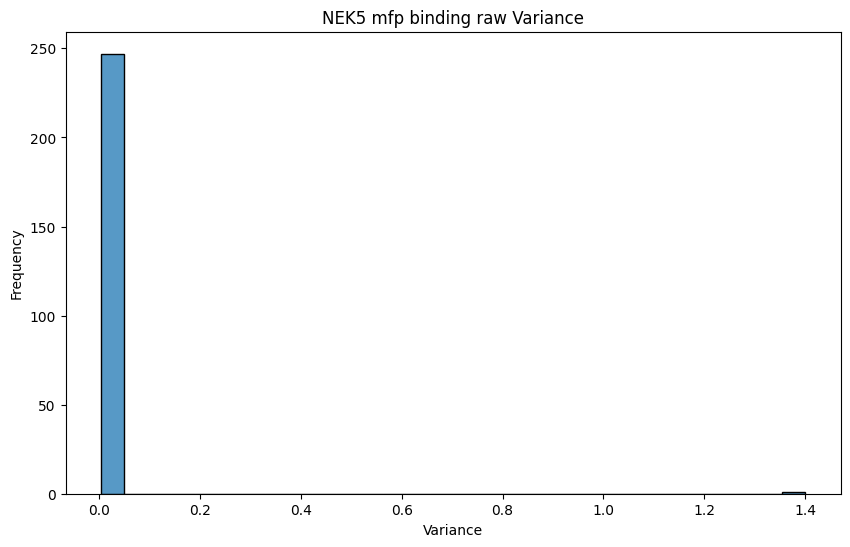

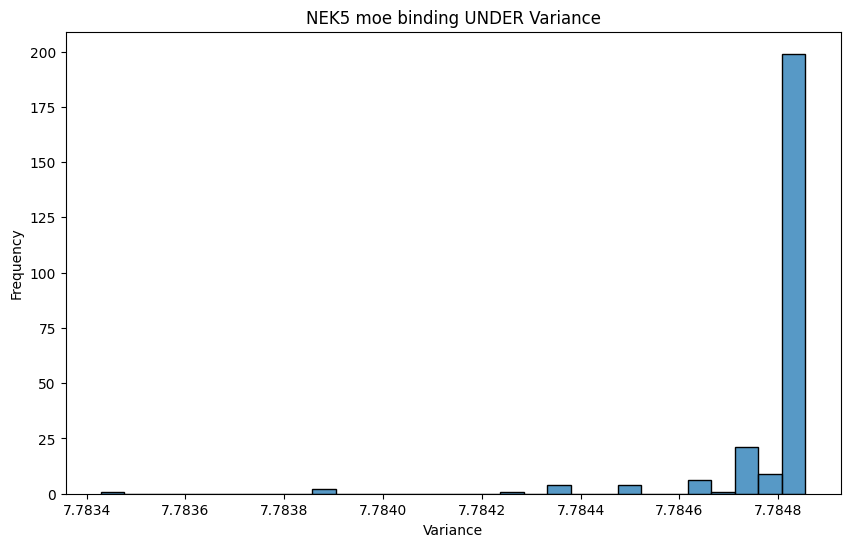

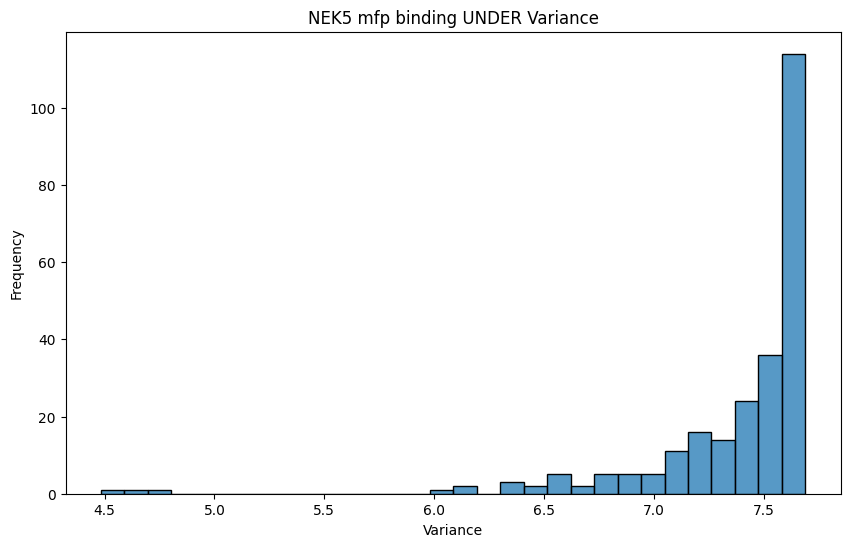

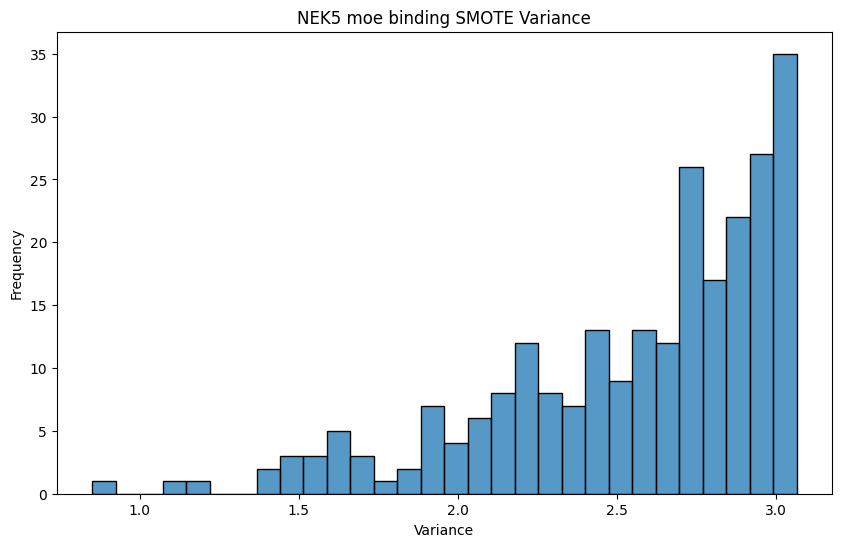

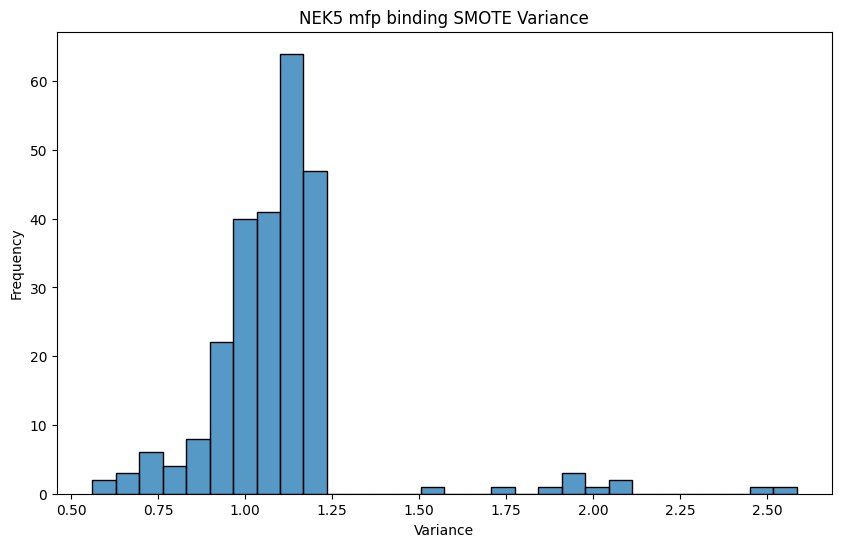

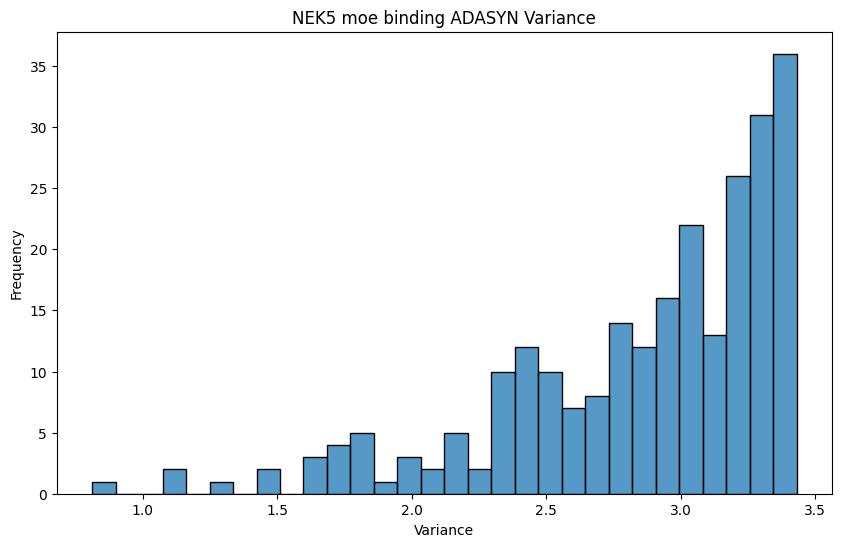

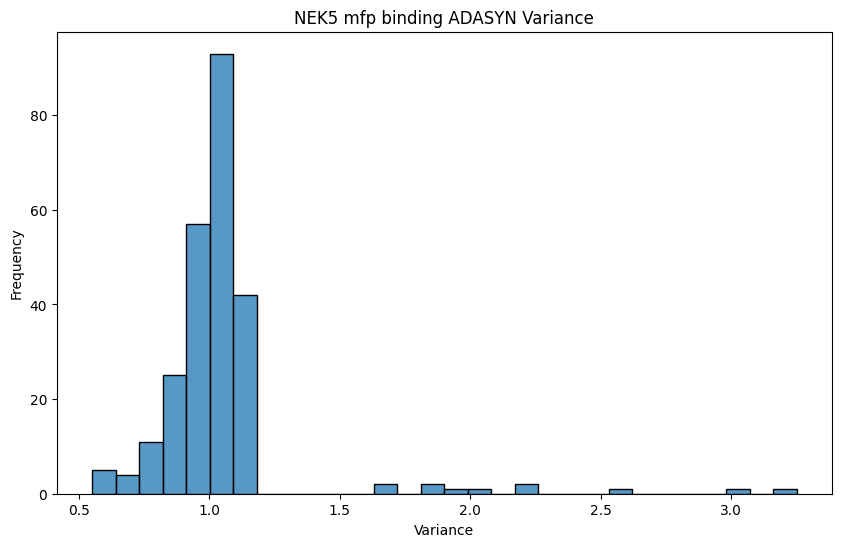

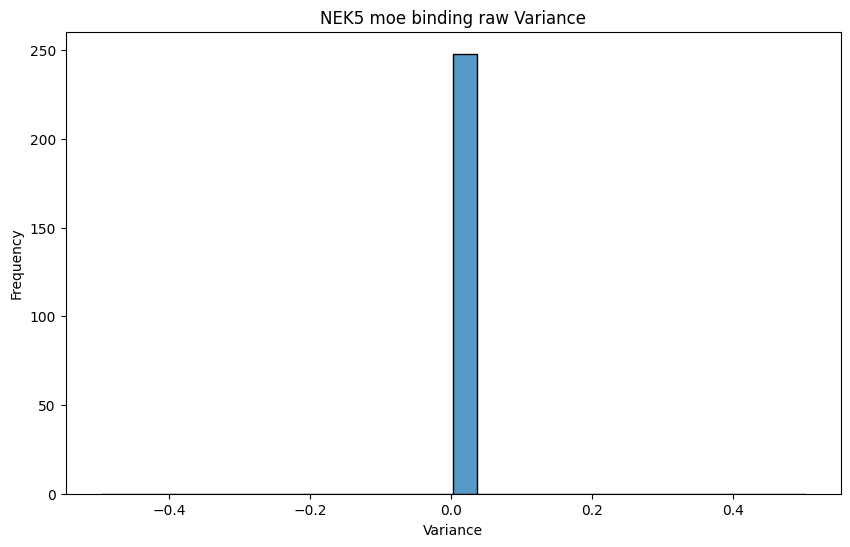

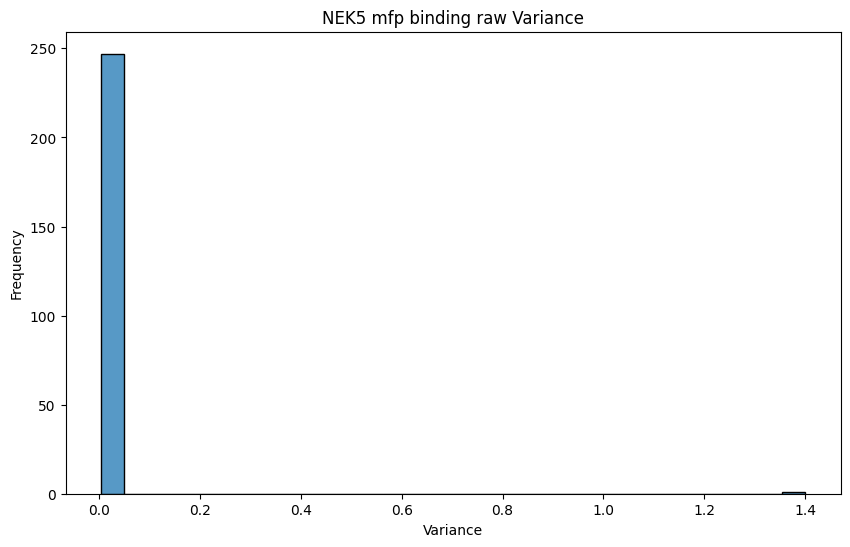

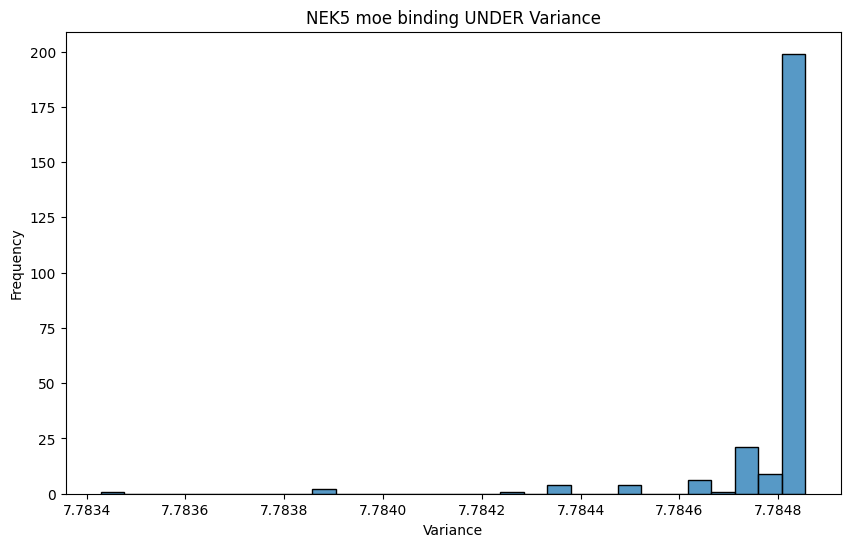

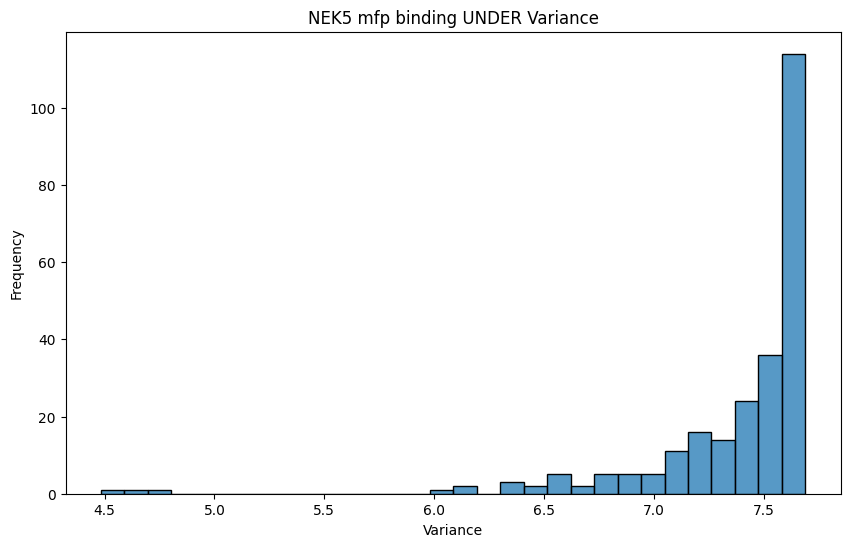

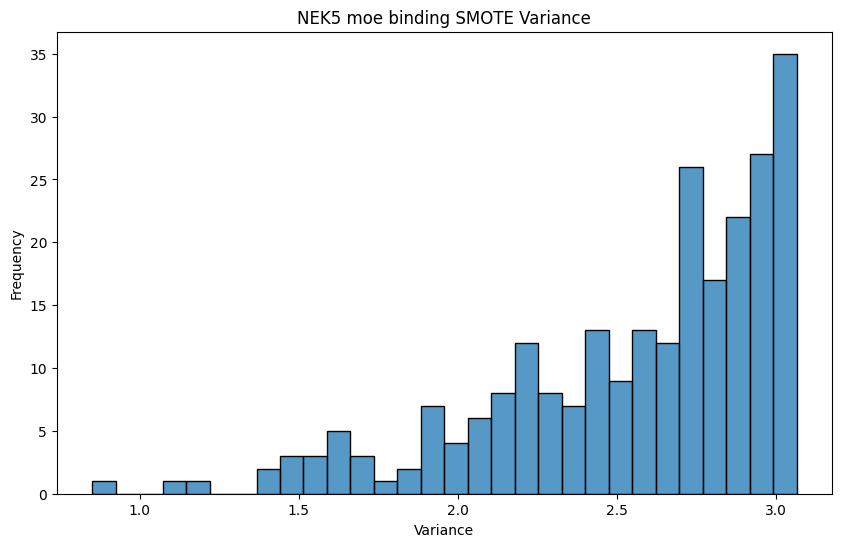

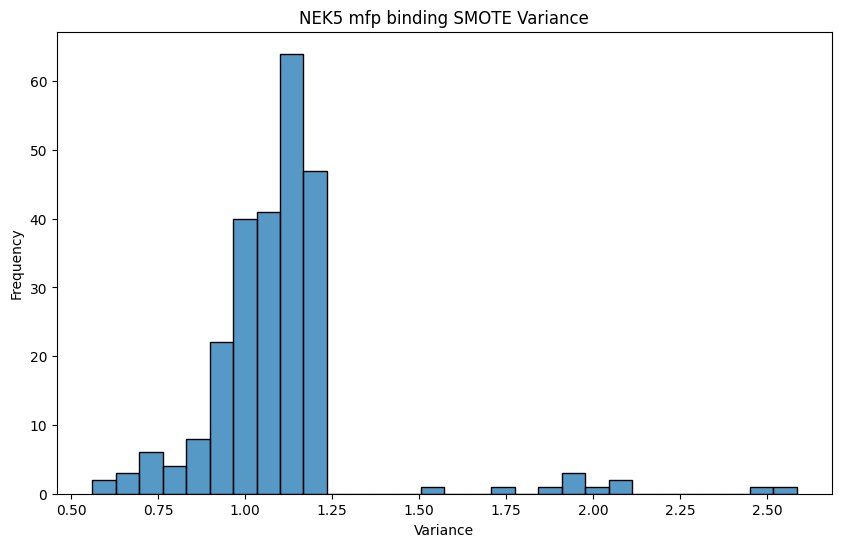

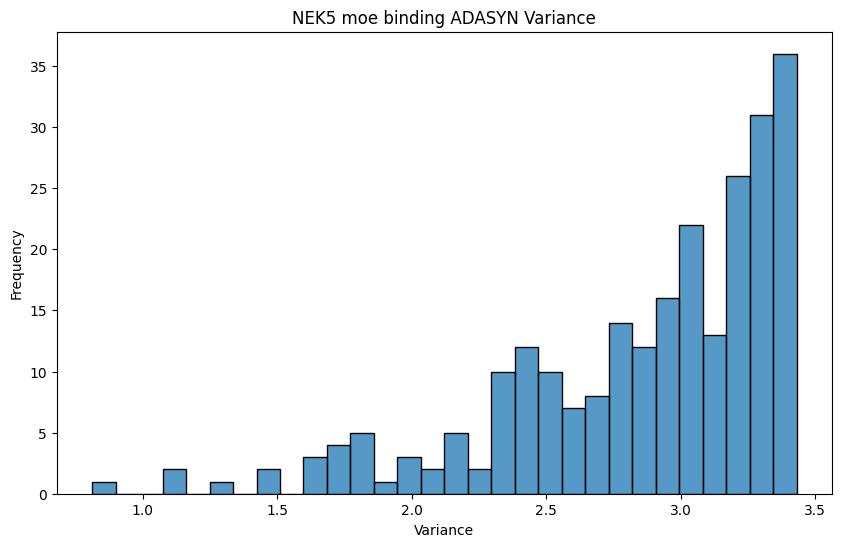

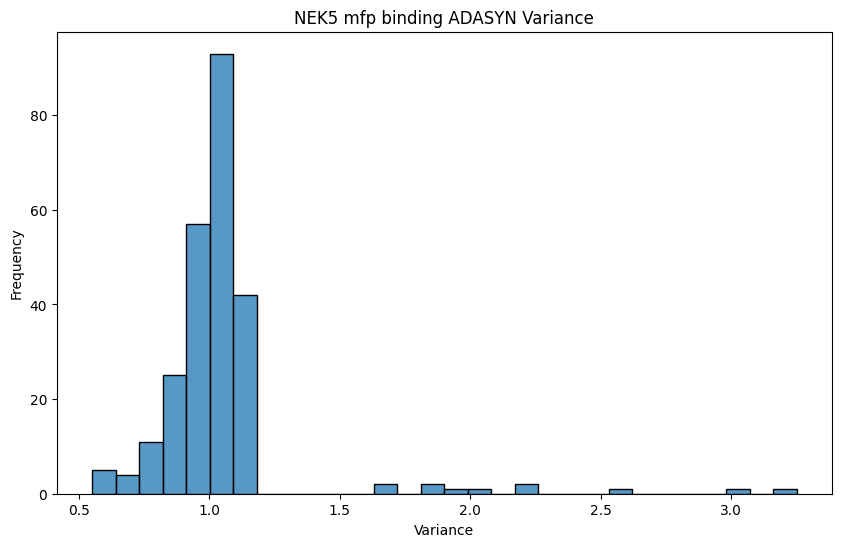

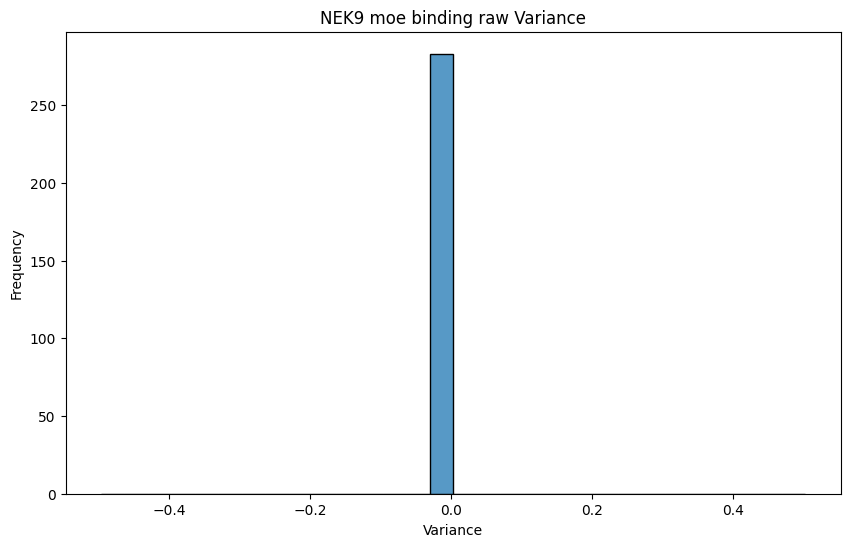

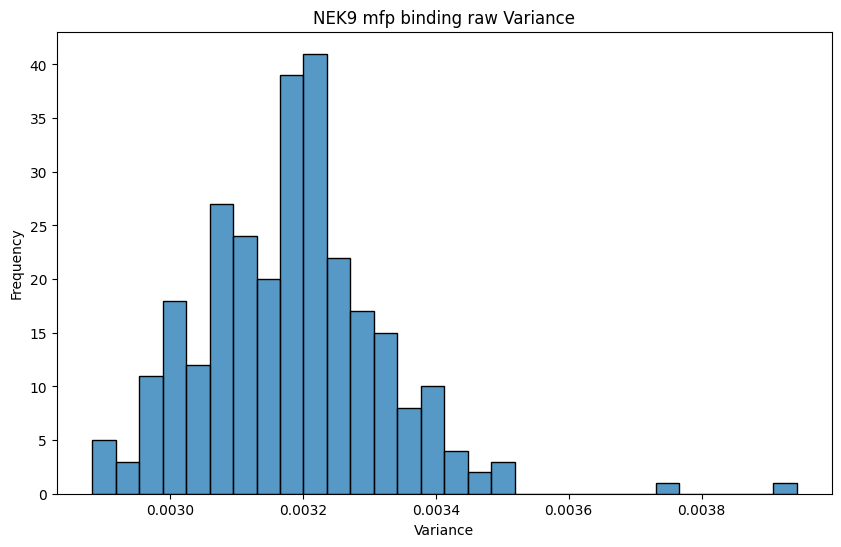

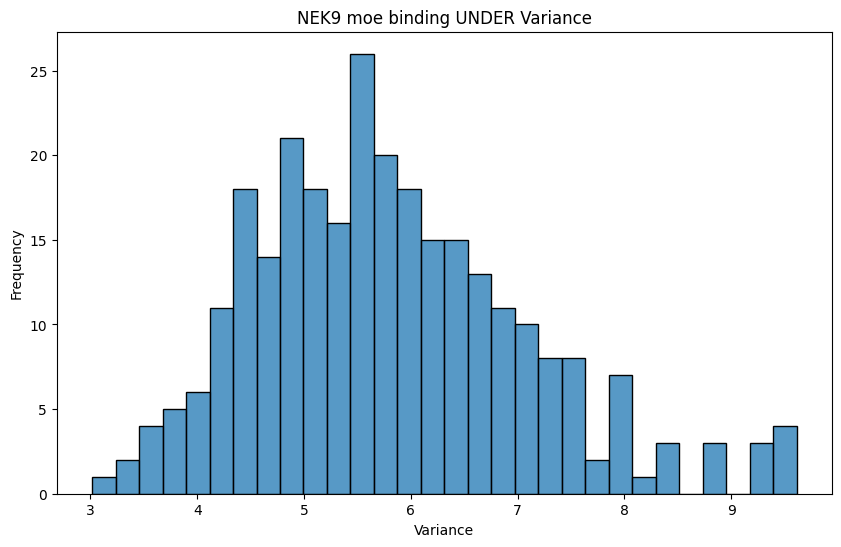

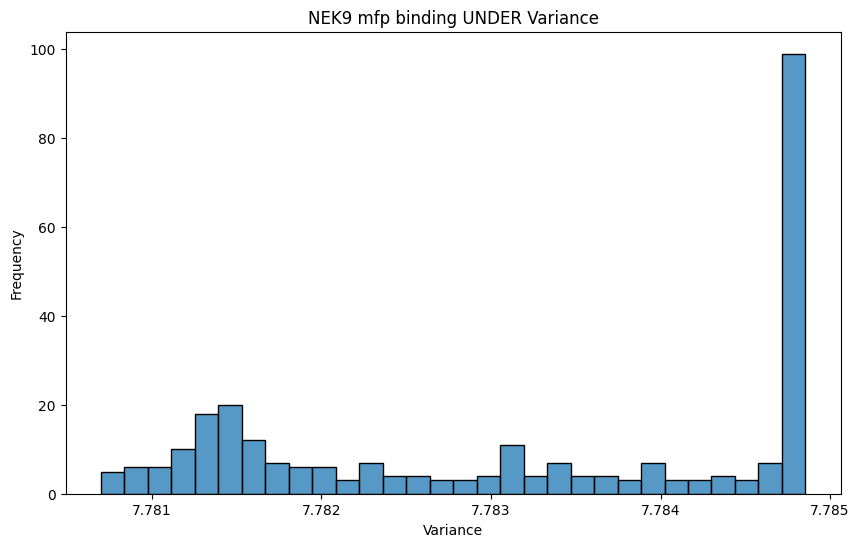

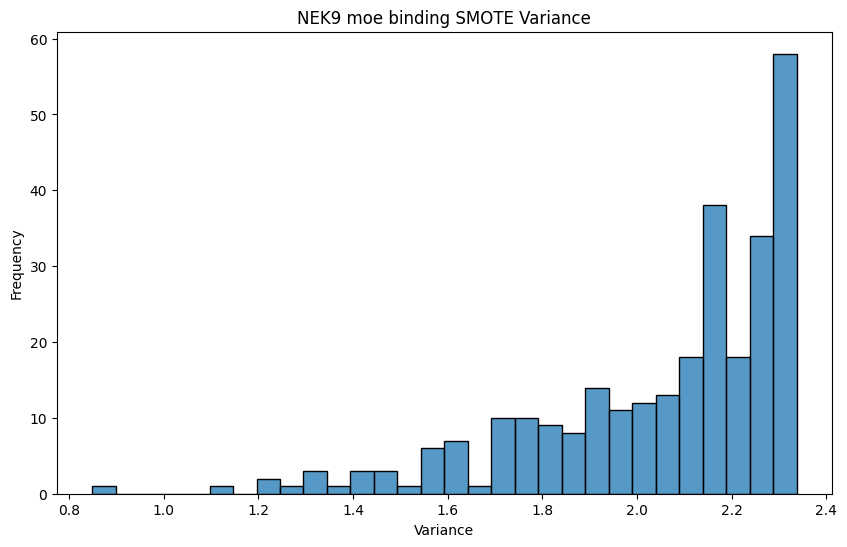

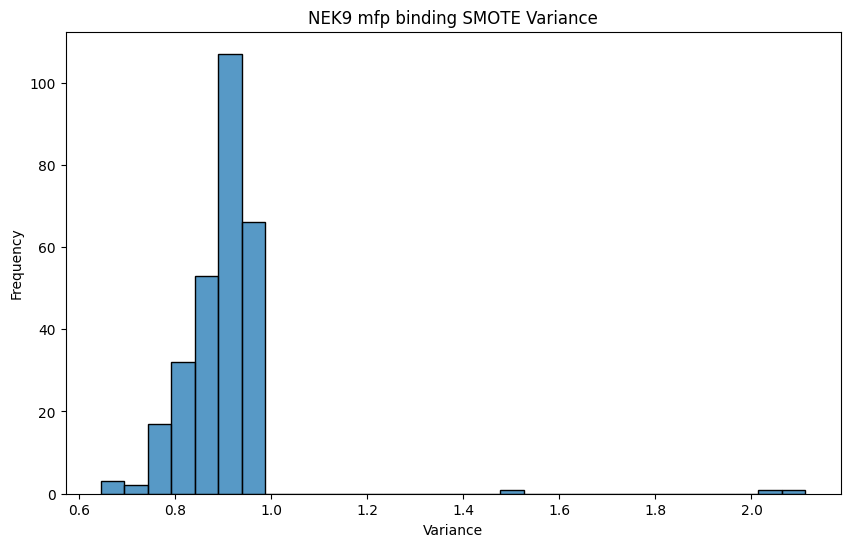

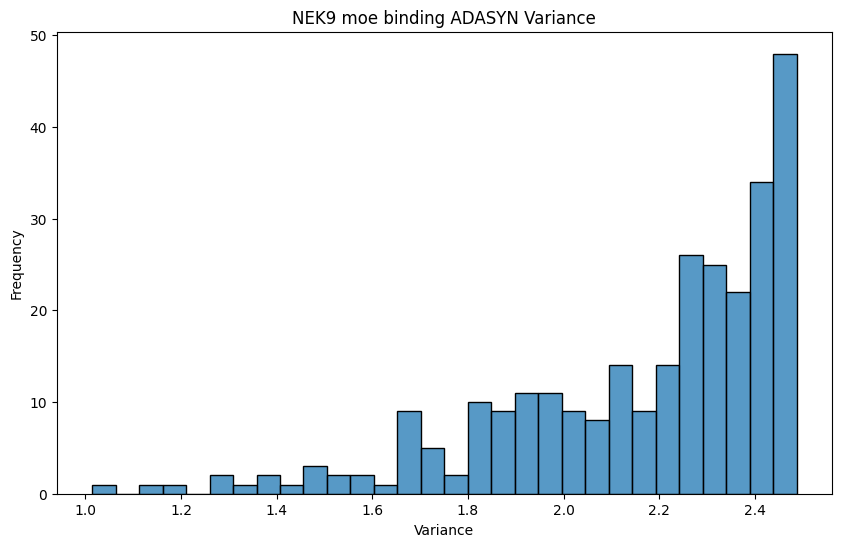

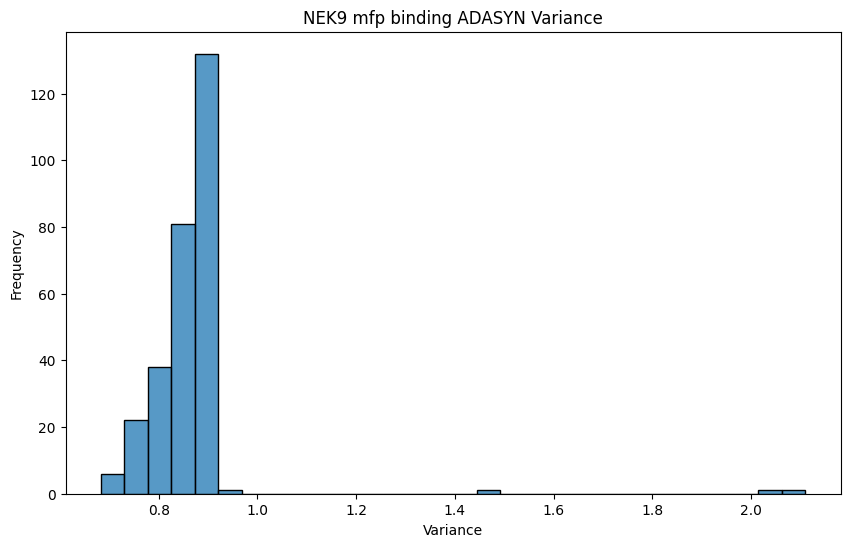

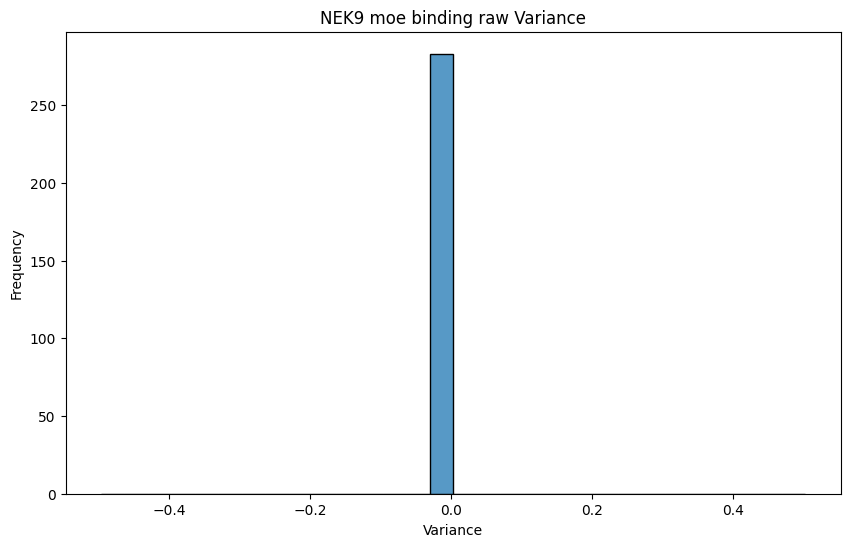

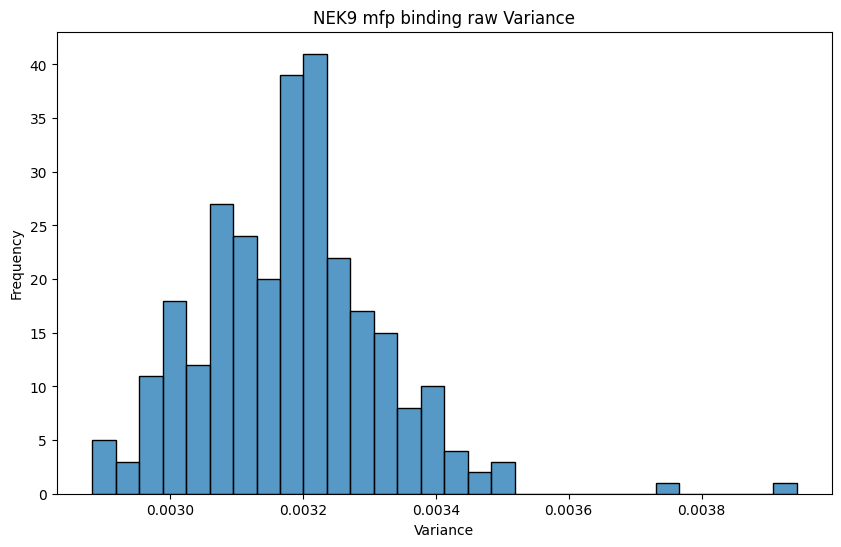

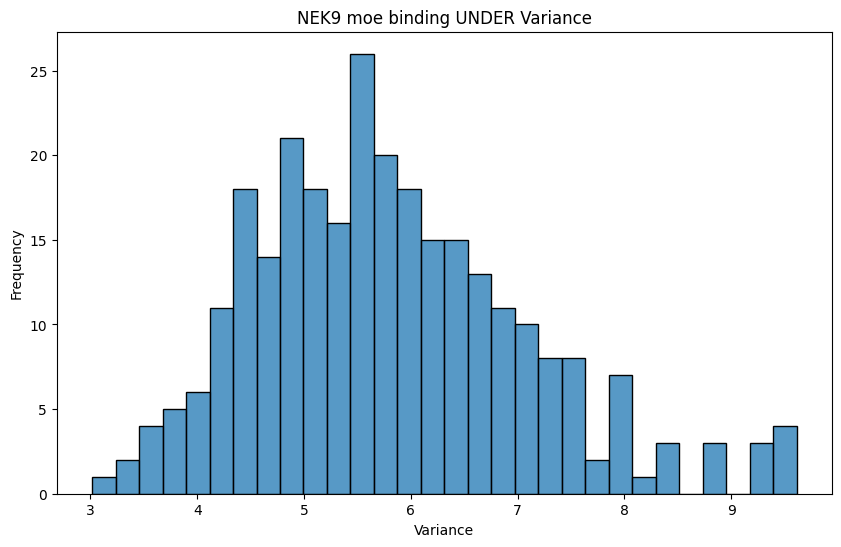

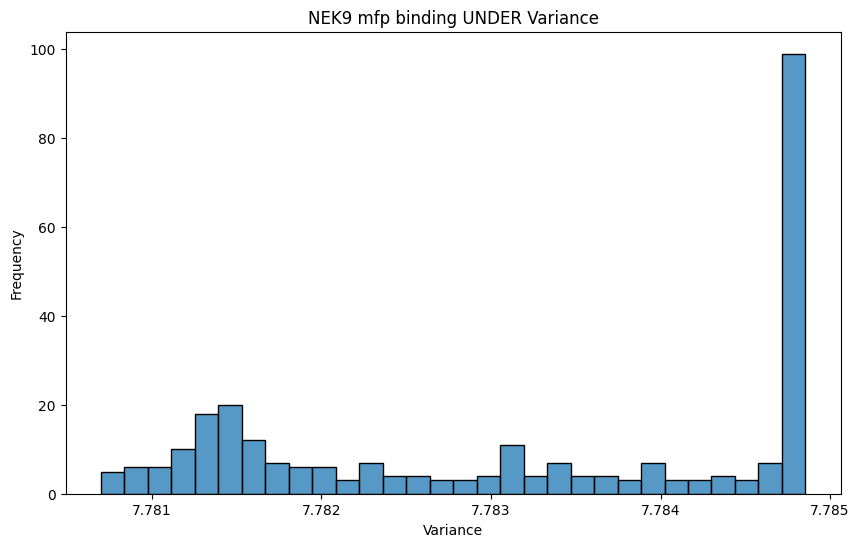

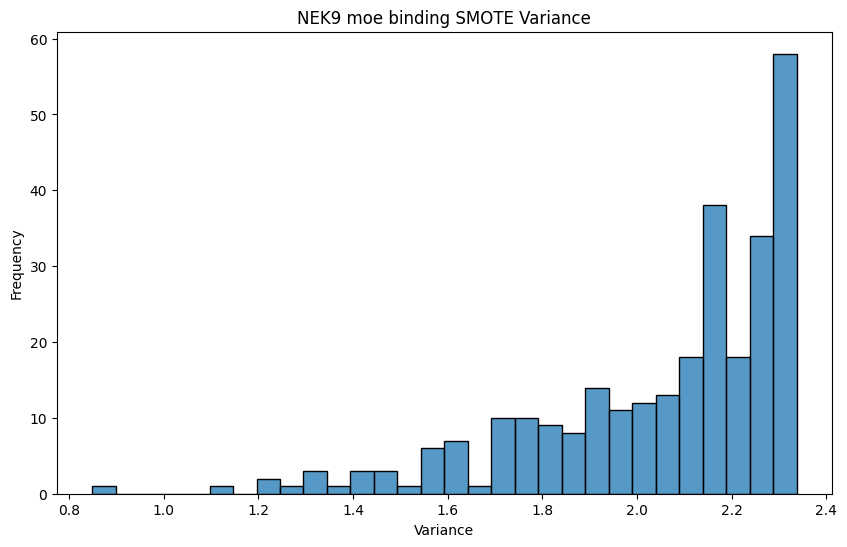

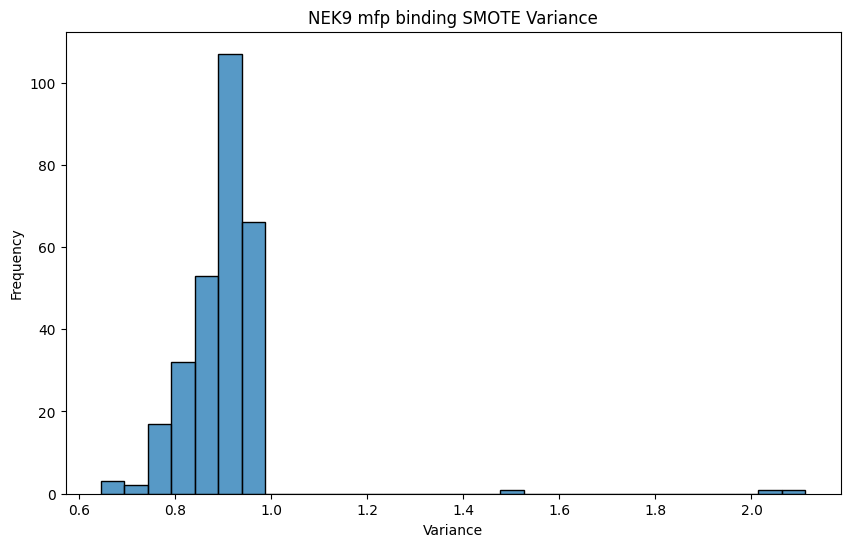

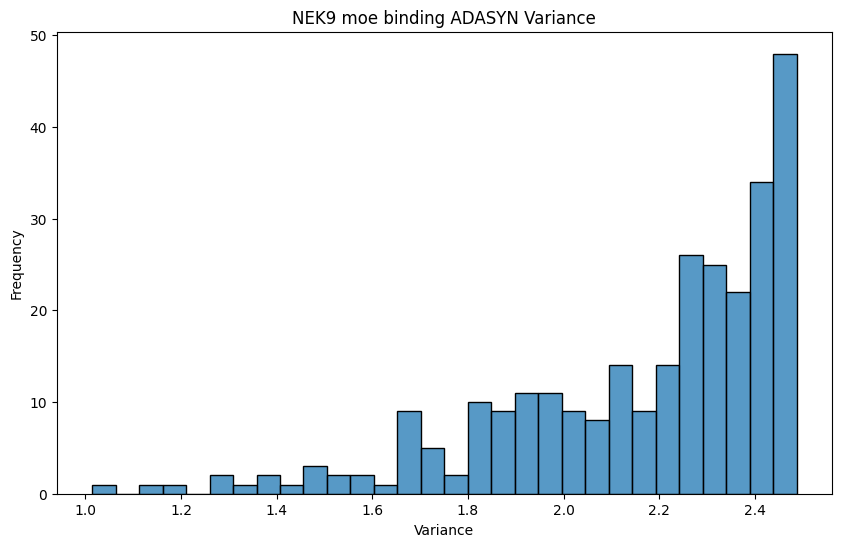

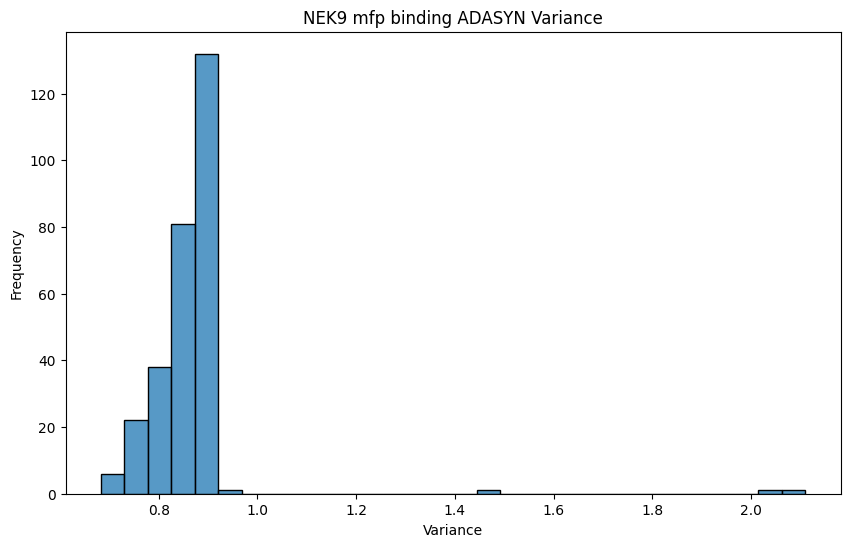

In [90]:
def calculate_prediction_variance(df, true_labels):
    # Determine the indices for TP, TN, FP, and FN
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    # Initialize 'prediction variance' with NaN
    df['prediction variance'] = np.nan
    
    # Assign values based on the indices
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    return df

def histogram_variance_GP(df, title, figure_path, filename):
    # Prepare data for plotting
    data = {
        'prediction variance': df['prediction variance'],
        'Feature Type': df['feat_type'],
    }
    plot_df = pd.DataFrame(data)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x='prediction variance', bins=30, kde=False)
    
    plt.title(title)
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    
    plt.show()

for nek in nek_list:
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({
                'prediction': moe_preds,
                'prediction_type': moe_pred['prediction_type'],
                'var0': var0_moe,
                'var1': var1_moe,
                'ADdist': test_dist
            })
            mfp_df = pd.DataFrame({
                'prediction': mfp_preds,
                'prediction_type': mfp_pred['prediction_type'],
                'var0': var0_mfp,
                'var1': var1_mfp,
                'ADdist': test_dist
            })
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            # Calculate prediction variance
            moe_df = calculate_prediction_variance(moe_df, true_labels)
            mfp_df = calculate_prediction_variance(mfp_df, true_labels)

            if samp == 'scaled': 
                samp = 'raw'
            
            # Plot variance histograms for both MOE and MFP
            histogram_variance_GP(moe_df, f'NEK{nek} moe binding {samp} Variance', figure_path, f'NEK{nek}_binding_moe_{samp}_variance_hist')
            histogram_variance_GP(mfp_df, f'NEK{nek} mfp binding {samp} Variance', figure_path, f'NEK{nek}_binding_mfp_{samp}_variance_hist')

            if samp == 'raw': 
                samp = 'scaled'


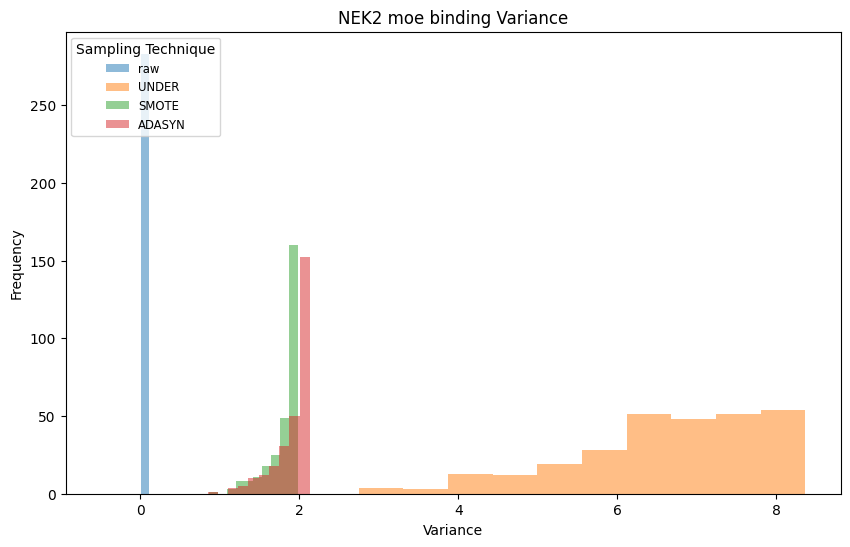

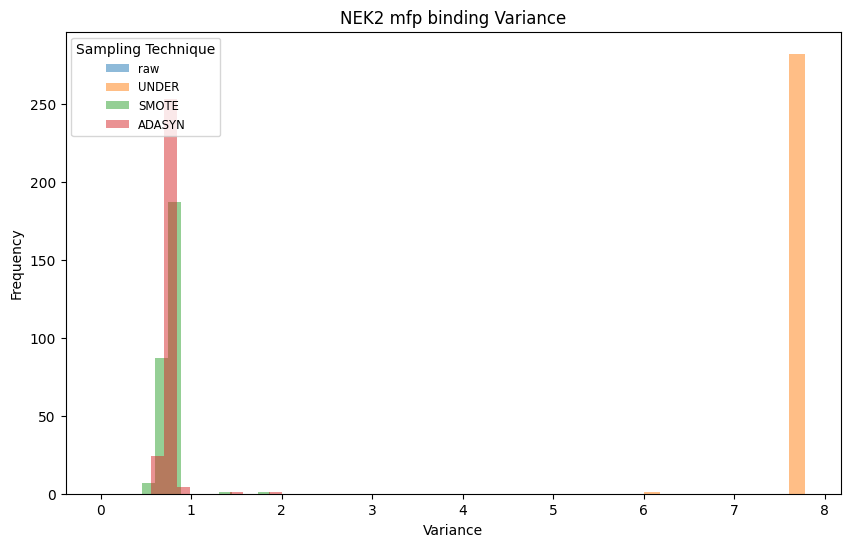

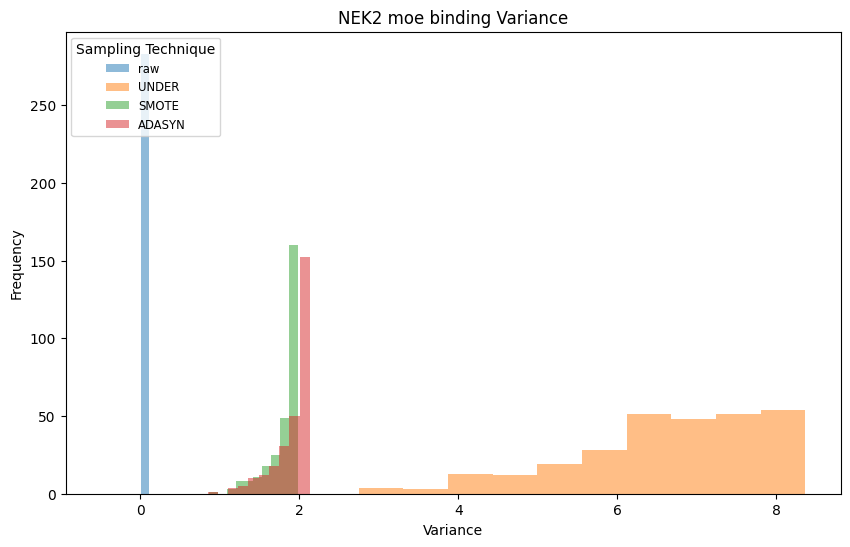

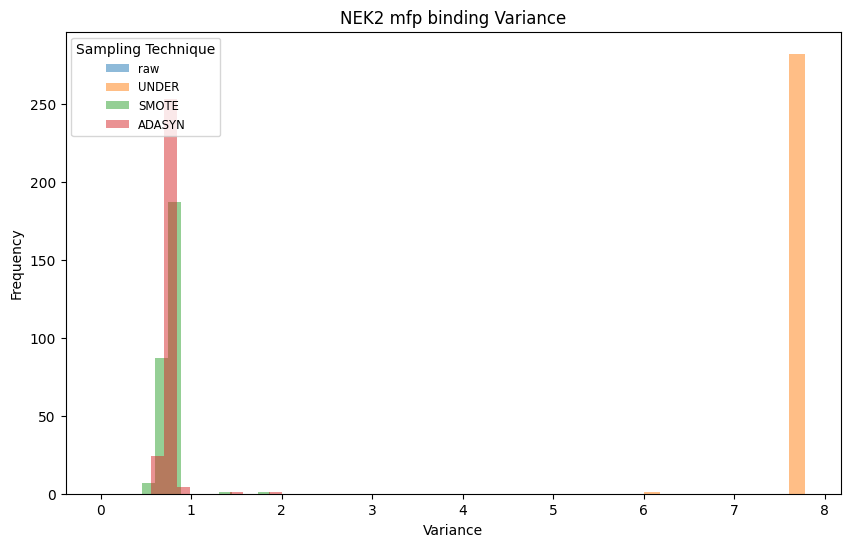

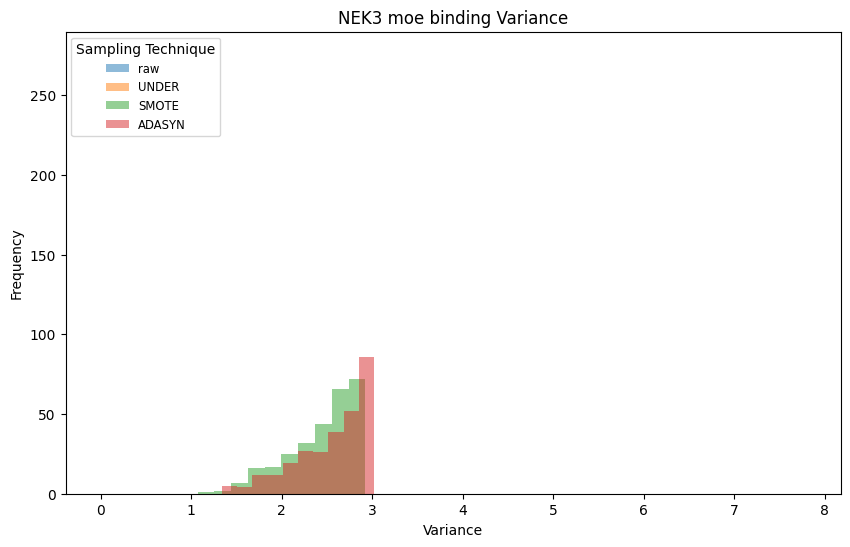

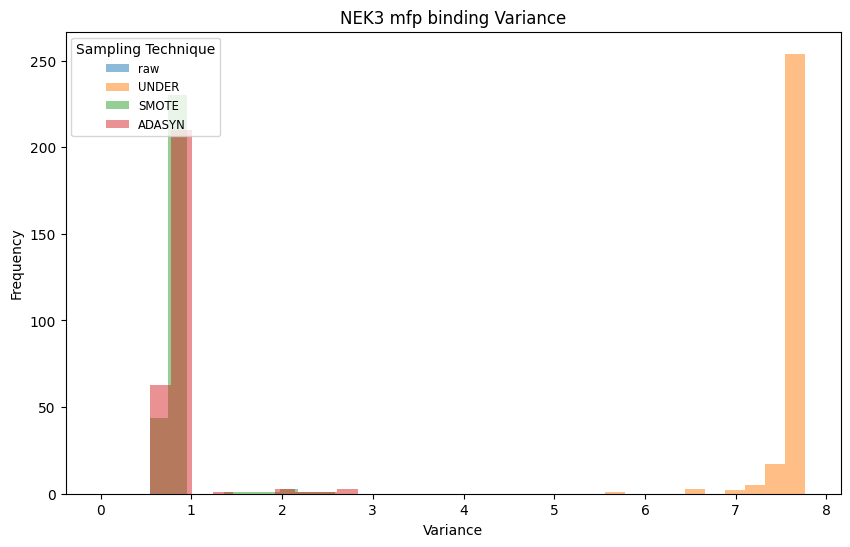

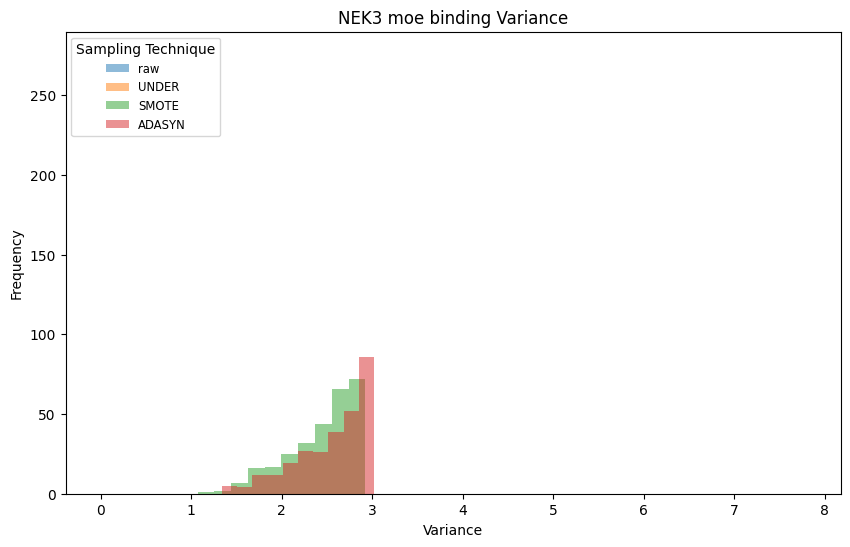

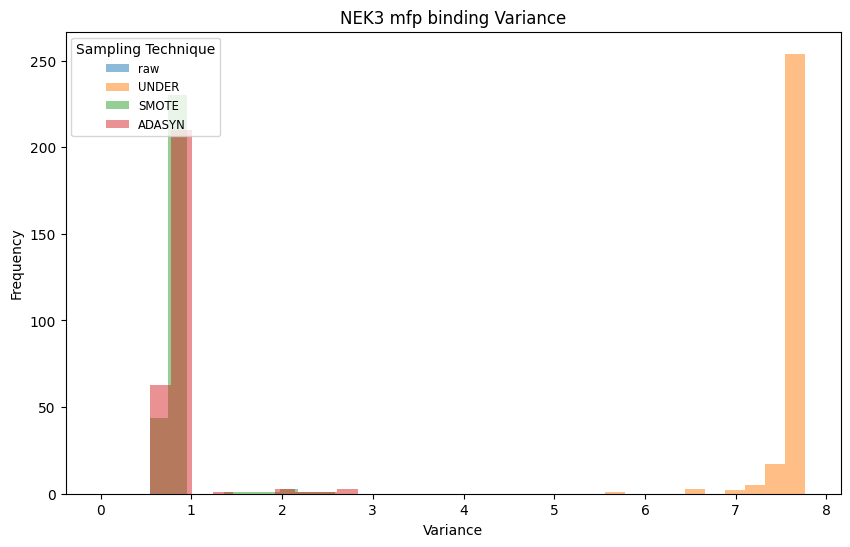

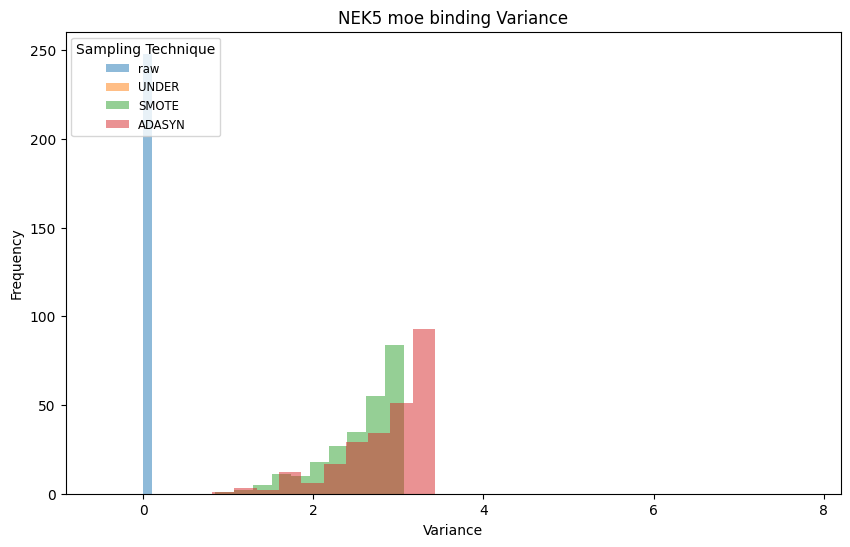

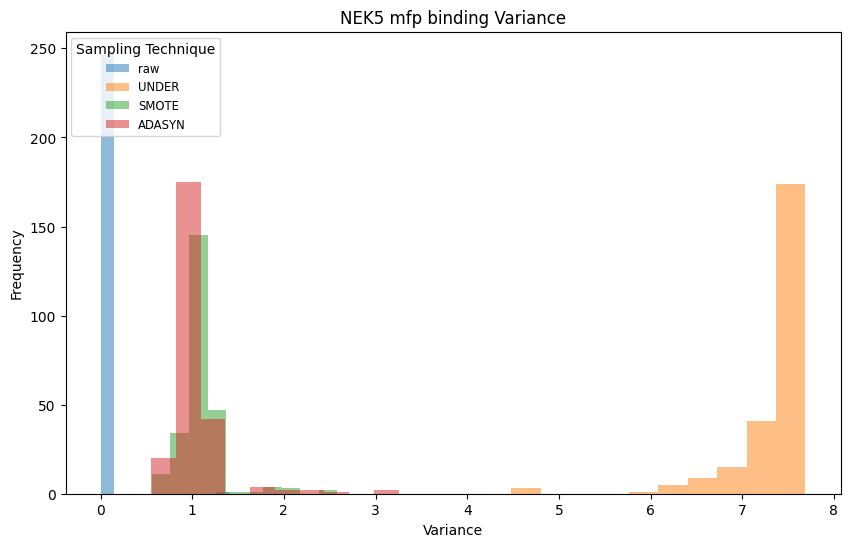

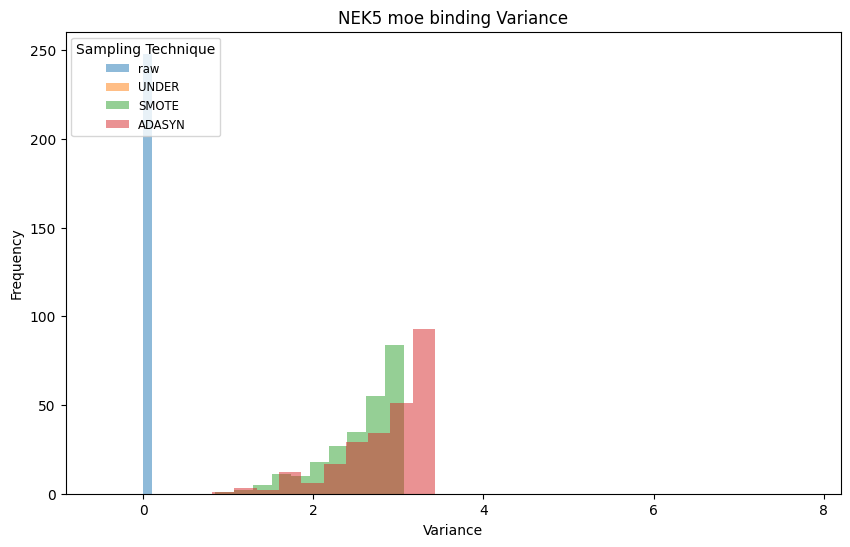

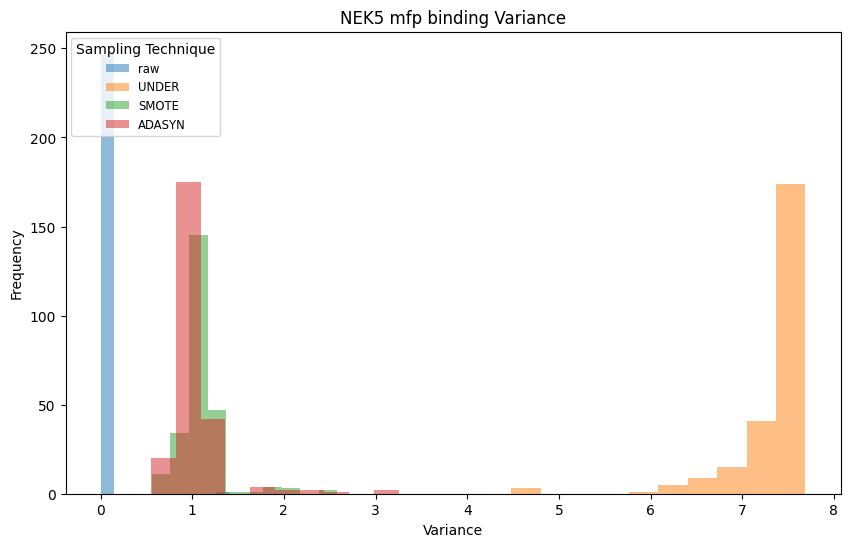

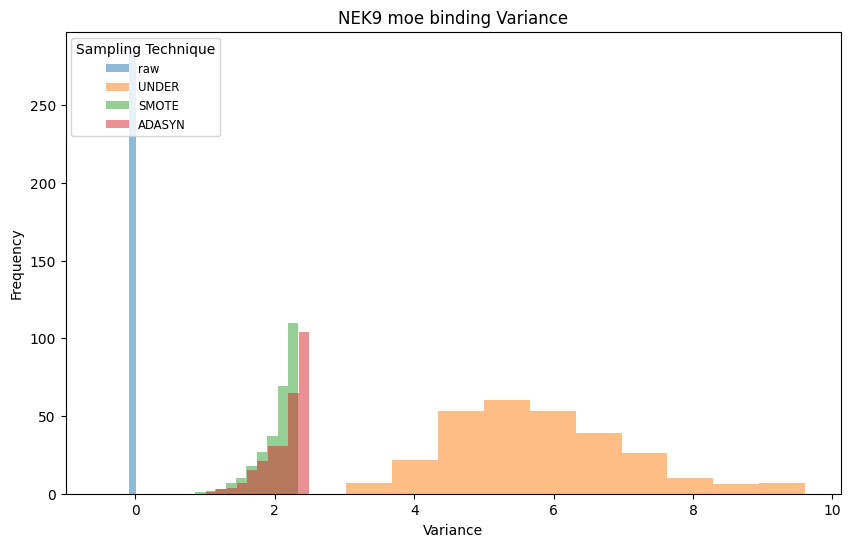

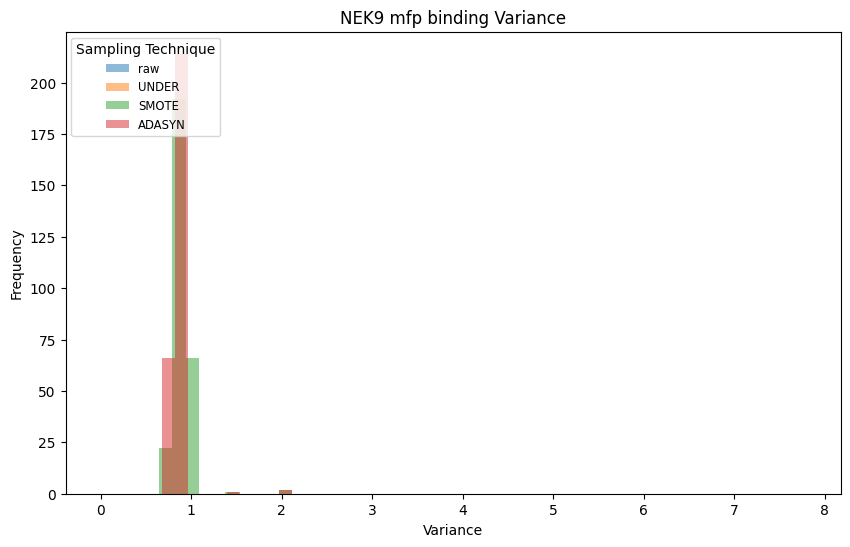

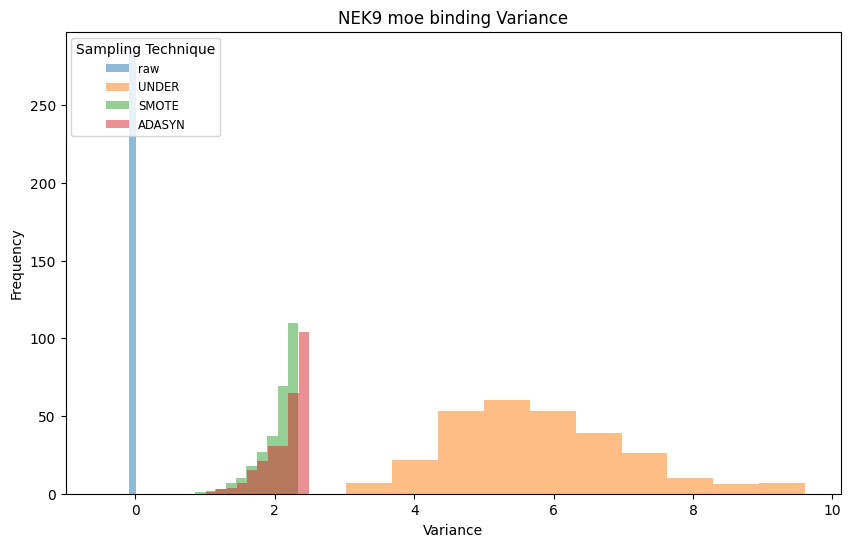

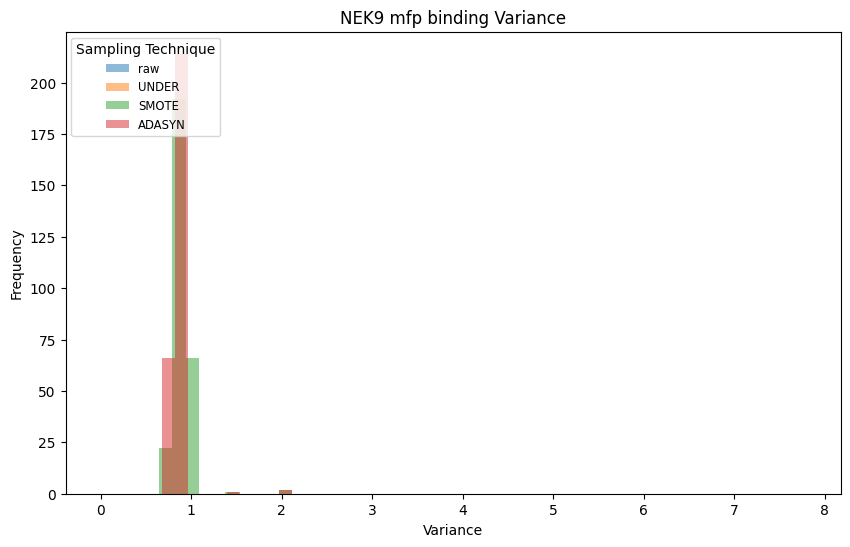

In [114]:


def layered_histogram_variance(dfs, sampling_labels, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dfs, sampling_labels):
        sns.histplot(df['prediction variance'], bins=10, kde=False, label=label, alpha=0.5, edgecolor=None, linewidth=None)
    
    plt.title(title)
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.legend(title='Sampling Technique', loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))
    plt.show()


for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({
                'prediction': moe_preds,
                'prediction_type': moe_pred['prediction_type'],
                'var0': var0_moe,
                'var1': var1_moe,
                'ADdist': test_dist
            })
            mfp_df = pd.DataFrame({
                'prediction': mfp_preds,
                'prediction_type': mfp_pred['prediction_type'],
                'var0': var0_mfp,
                'var1': var1_mfp,
                'ADdist': test_dist
            })
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            # Calculate prediction variance
            moe_df = calculate_prediction_variance(moe_df, true_labels)
            mfp_df = calculate_prediction_variance(mfp_df, true_labels)

            # Collect DataFrames and labels for layered histogram
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered histograms for variance after the loop populates dfs and labels
        layered_histogram_variance(dfs_moe, labels, f'NEK{nek} moe binding Variance', figure_path, f'NEK{nek}_binding_moe_variance_hist')
        layered_histogram_variance(dfs_mfp, labels, f'NEK{nek} mfp binding Variance', figure_path, f'NEK{nek}_binding_mfp_variance_hist')


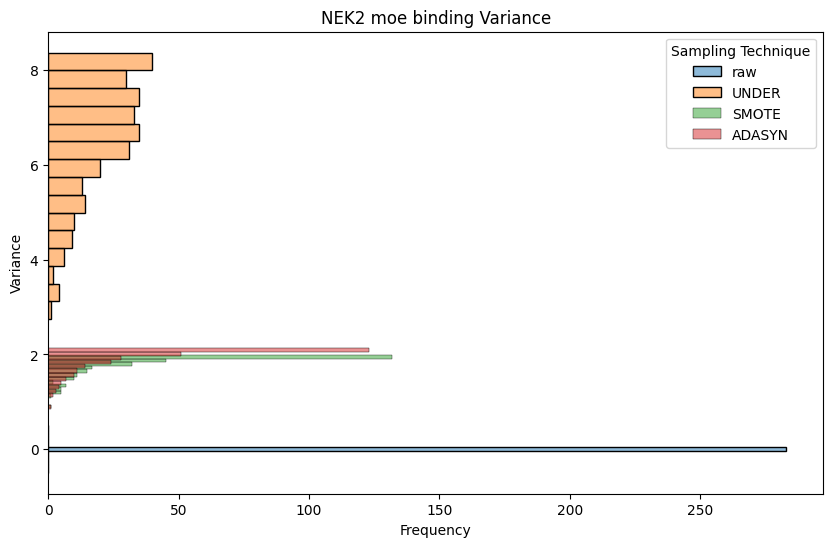

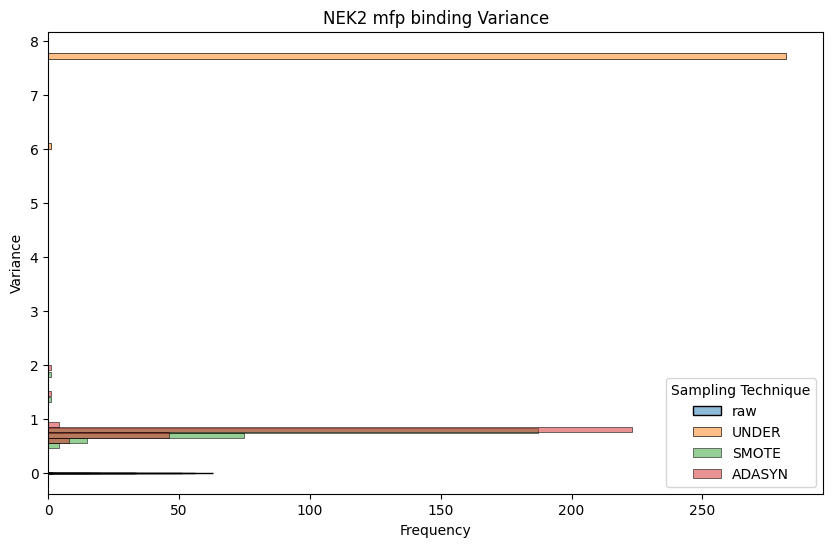

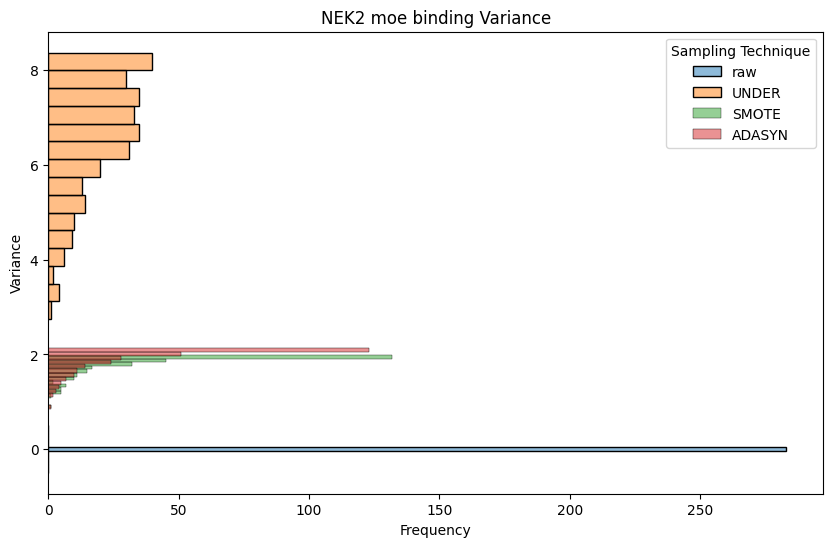

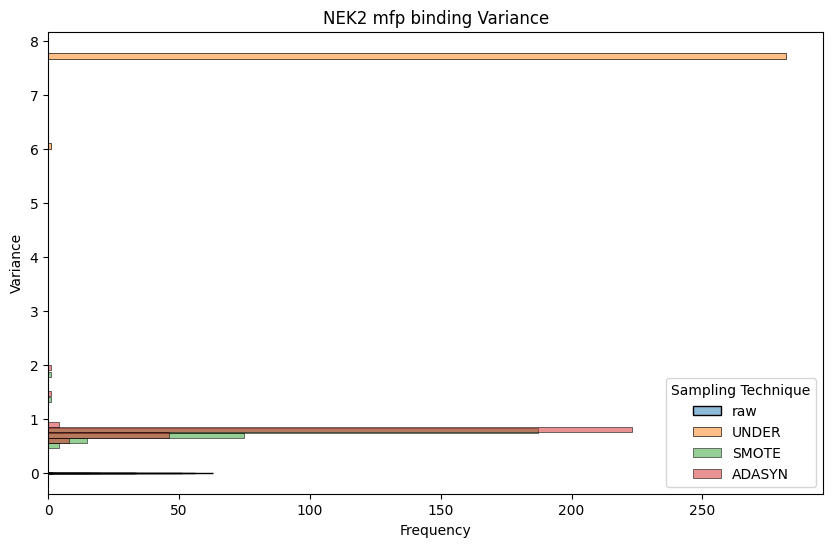

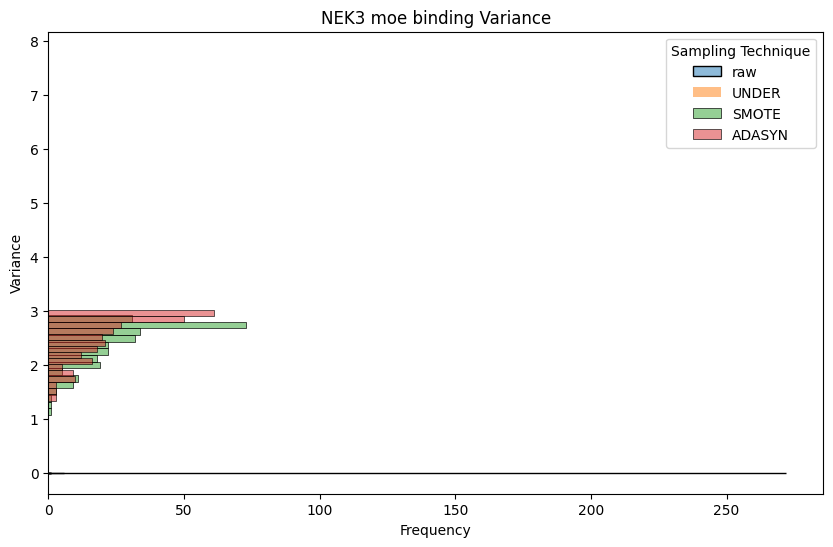

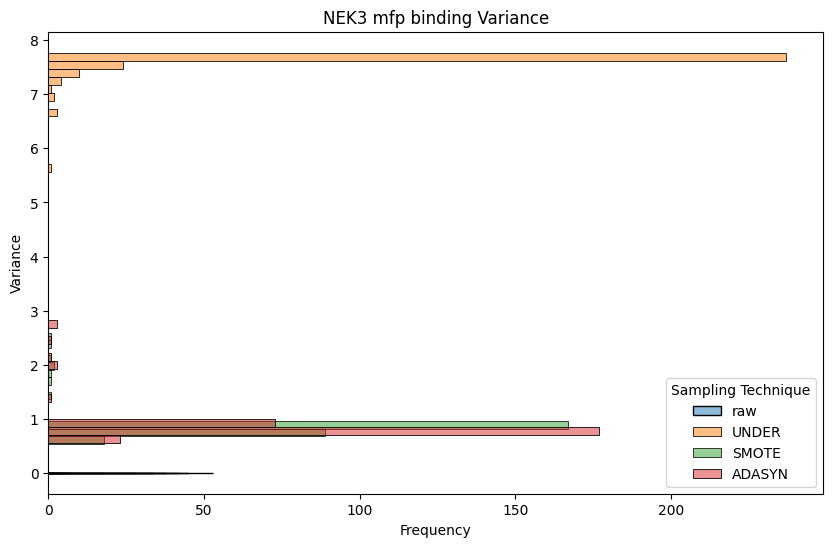

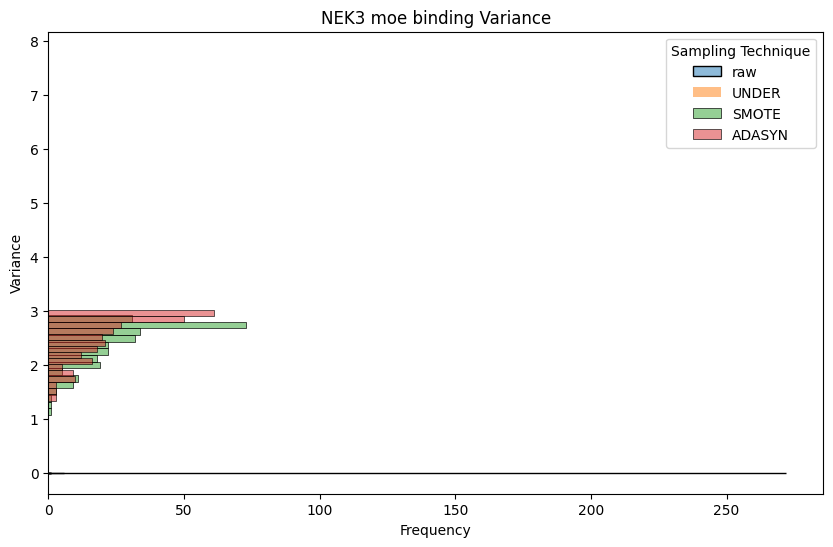

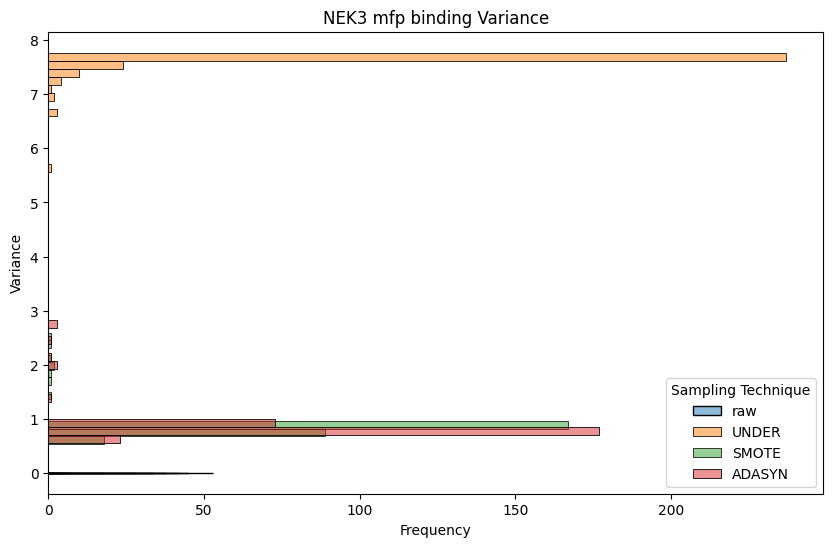

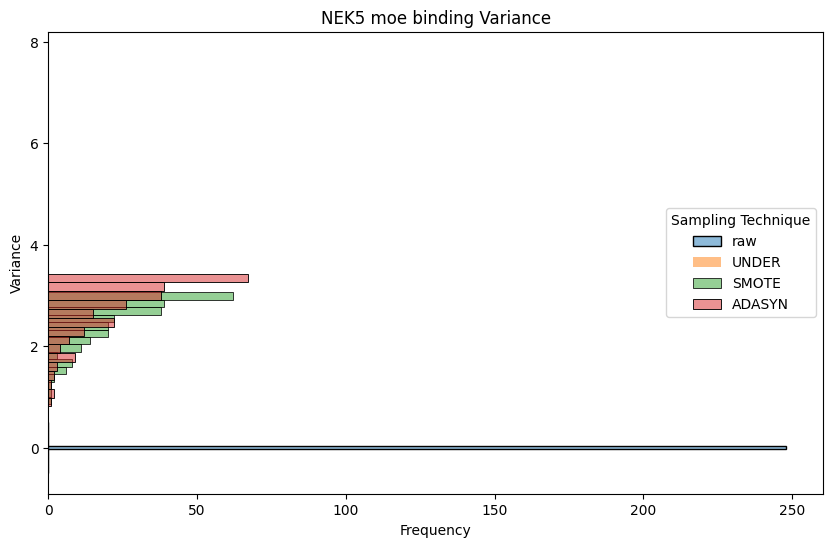

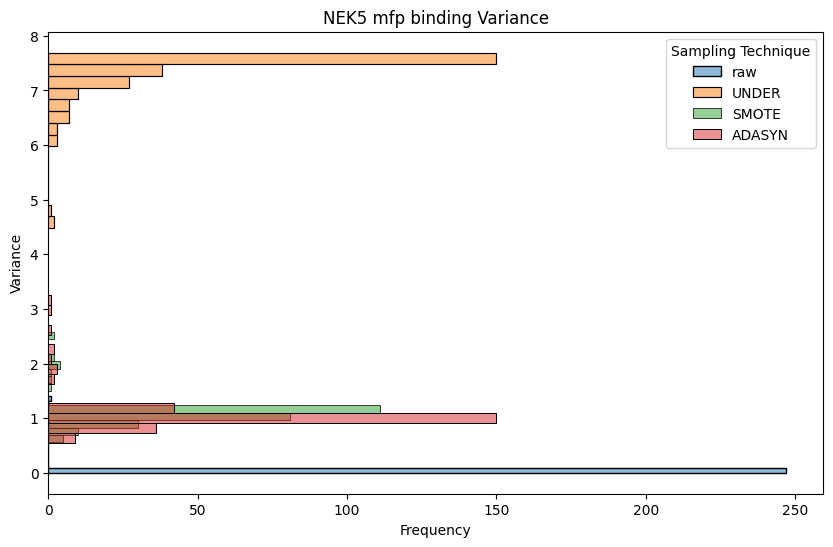

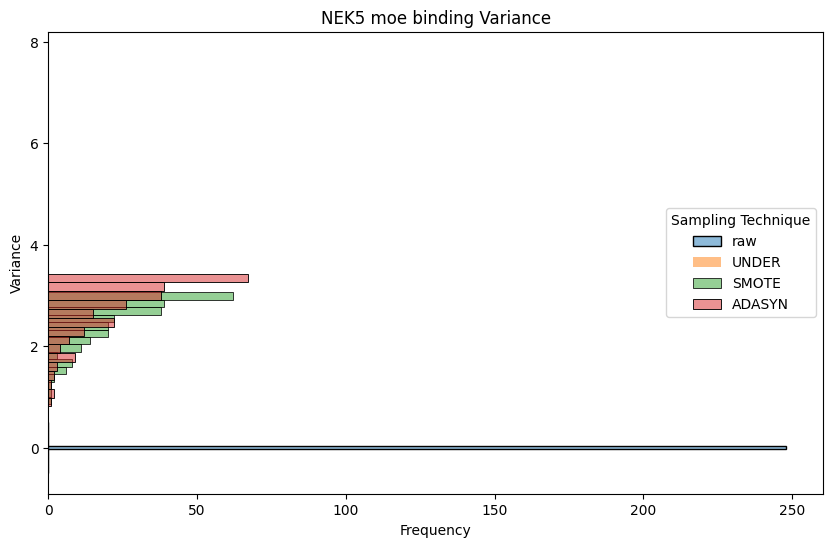

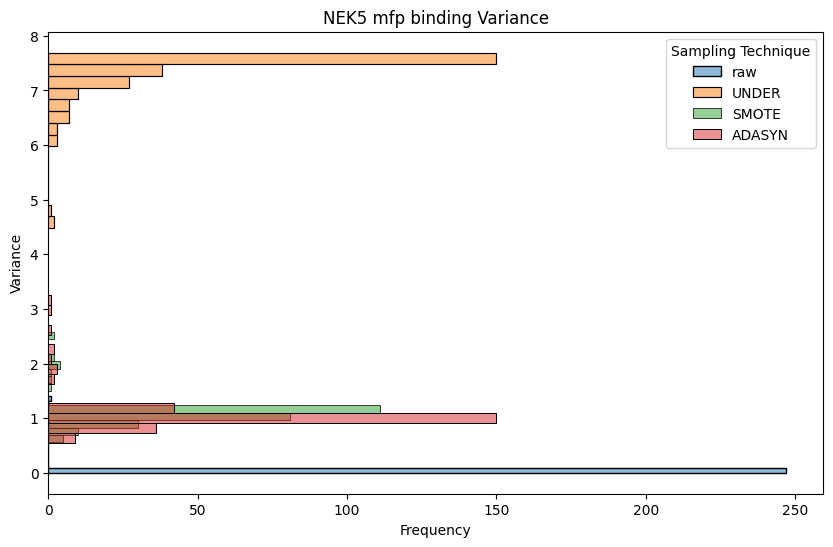

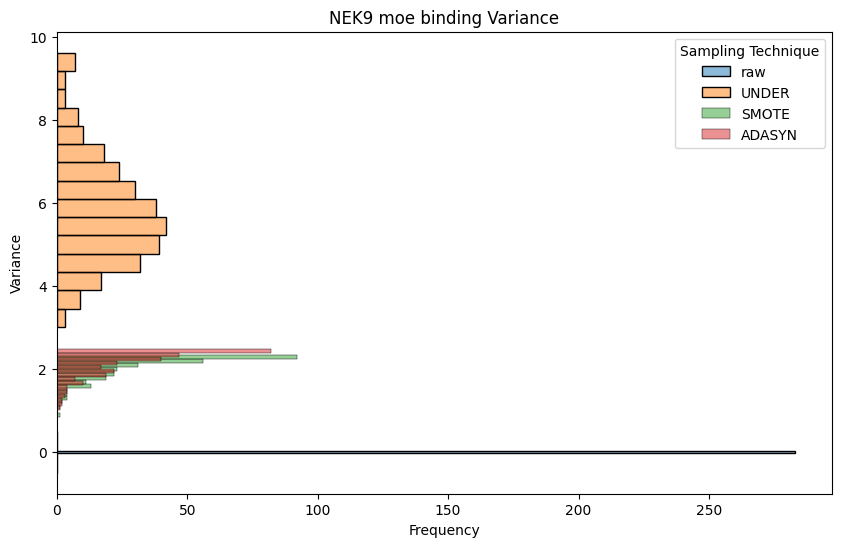

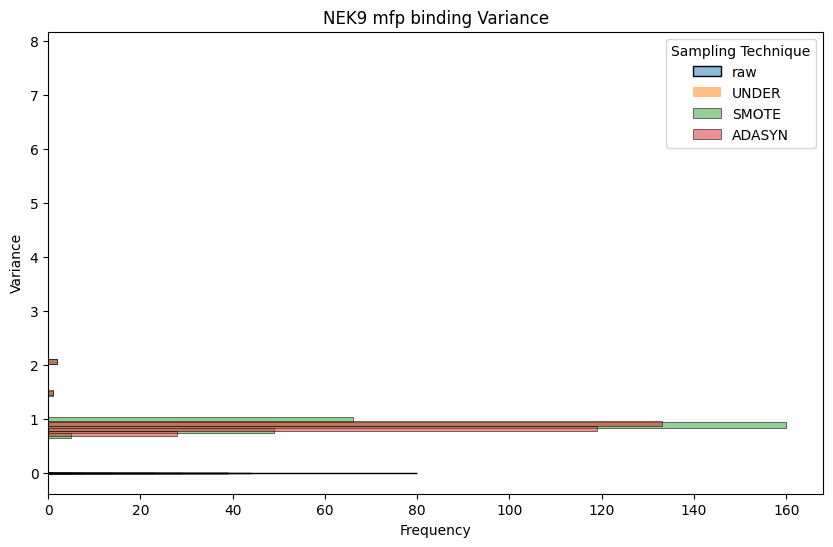

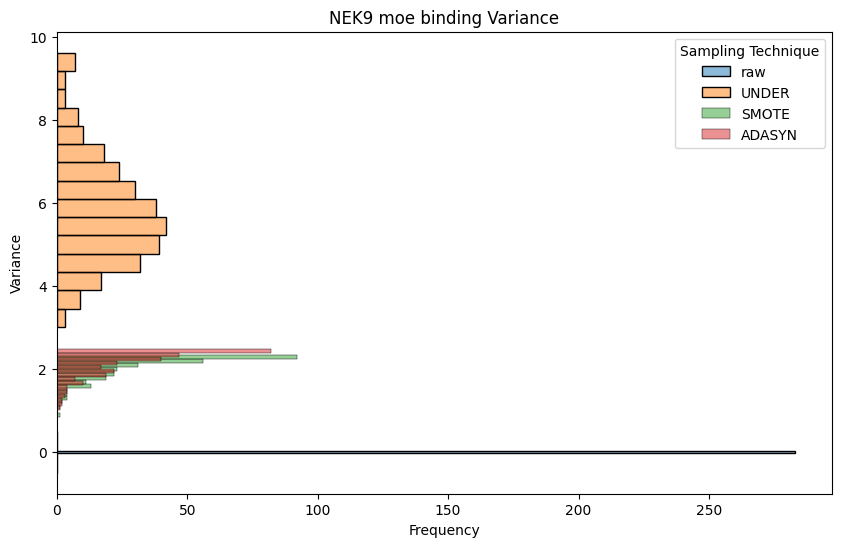

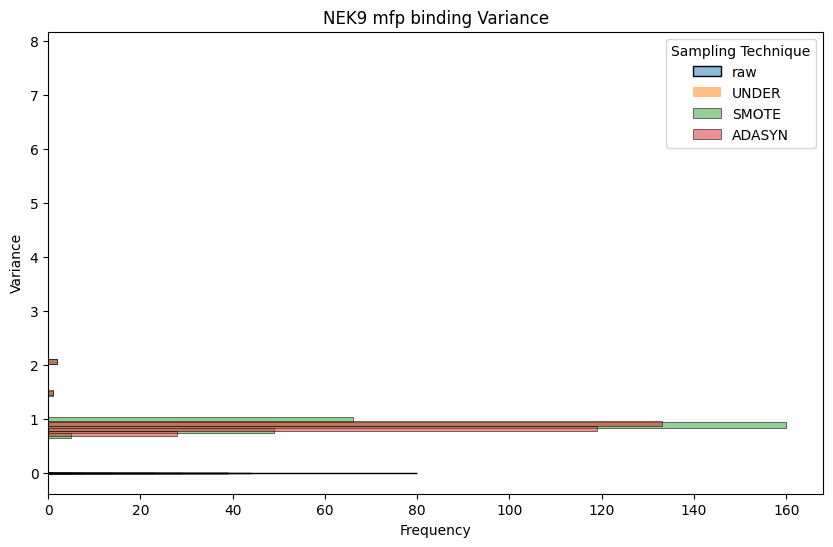

In [103]:
def layered_histogram_variance(dfs, sampling_labels, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dfs, sampling_labels):
        sns.histplot(y=df['prediction variance'], bins=15, kde=False, label=label, alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Variance')
    plt.legend(title='Sampling Technique')
    plt.show()

for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({
                'prediction': moe_preds,
                'prediction_type': moe_pred['prediction_type'],
                'var0': var0_moe,
                'var1': var1_moe,
                'ADdist': test_dist
            })
            mfp_df = pd.DataFrame({
                'prediction': mfp_preds,
                'prediction_type': mfp_pred['prediction_type'],
                'var0': var0_mfp,
                'var1': var1_mfp,
                'ADdist': test_dist
            })
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            # Calculate prediction variance
            moe_df = calculate_prediction_variance(moe_df, true_labels)
            mfp_df = calculate_prediction_variance(mfp_df, true_labels)

            # Collect DataFrames and labels for layered histogram
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered histograms for variance after the loop populates dfs and labels
        layered_histogram_variance(dfs_moe, labels, f'NEK{nek} moe binding Variance', figure_path, f'NEK{nek}_binding_moe_variance_hist')
        layered_histogram_variance(dfs_mfp, labels, f'NEK{nek} mfp binding Variance', figure_path, f'NEK{nek}_binding_mfp_variance_hist')


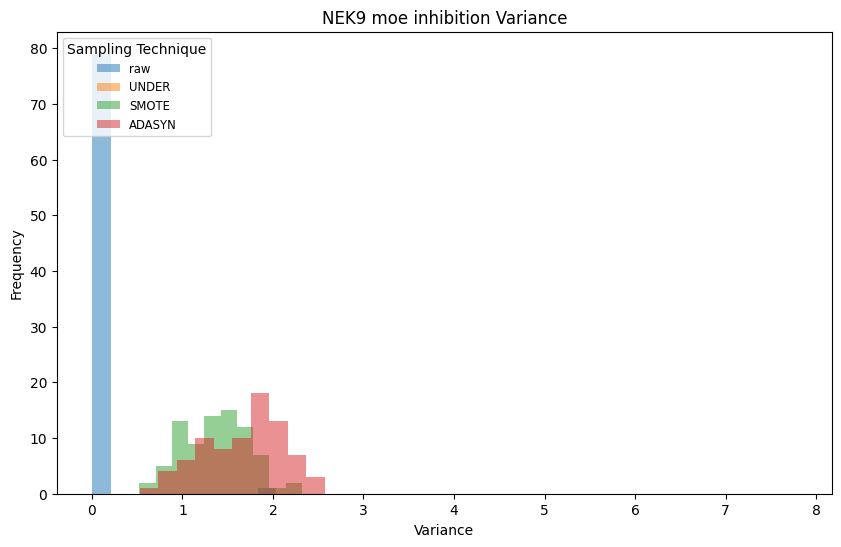

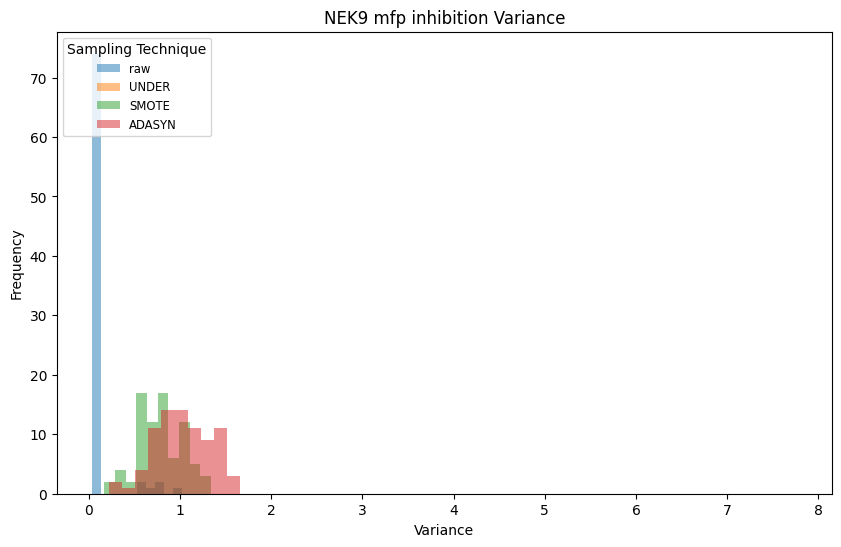

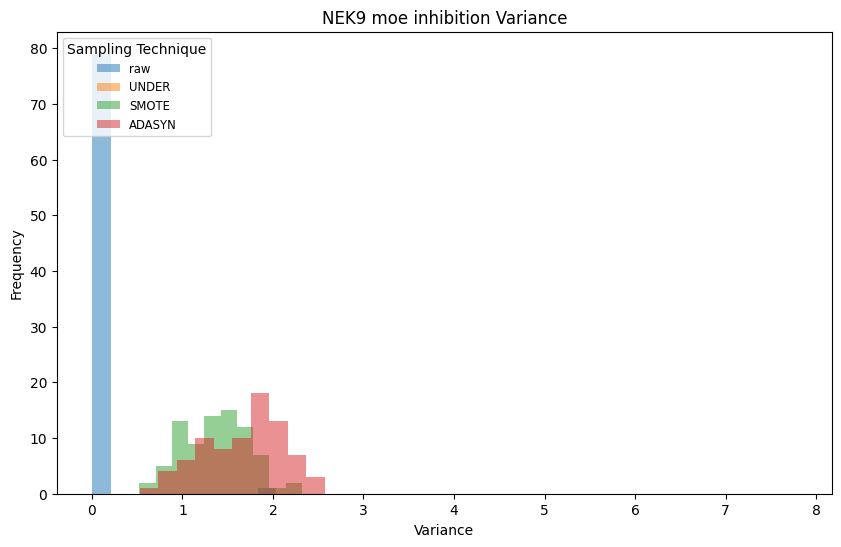

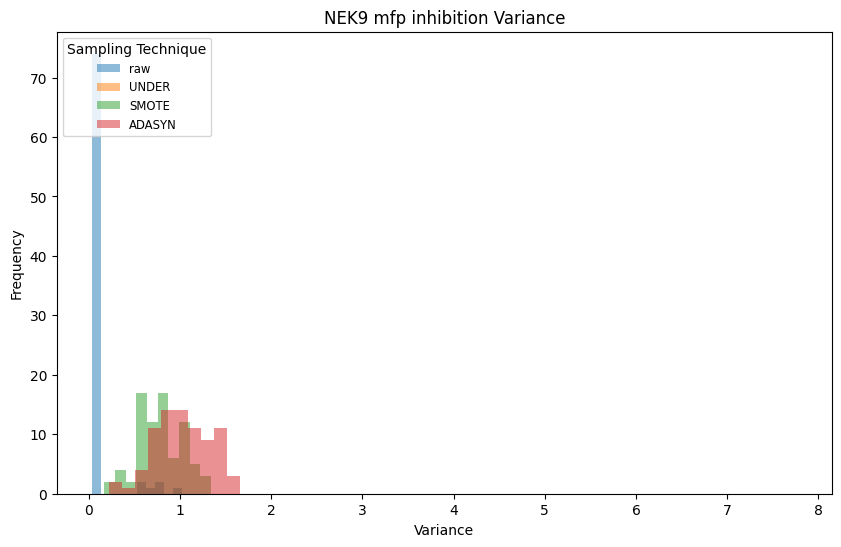

In [117]:


def layered_histogram_variance(dfs, sampling_labels, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dfs, sampling_labels):
        sns.histplot(df['prediction variance'], bins=10, kde=False, label=label, alpha=0.5, edgecolor=None, linewidth=None)
    
    plt.title(title)
    plt.xlabel('Variance')
    plt.ylabel('Frequency')
    plt.legend(title='Sampling Technique', loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))
    plt.show()

nek_list=['9']

for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/inhib/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_inhibition_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_inhibition_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_inhibition_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({
                'prediction': moe_preds,
                'prediction_type': moe_pred['prediction_type'],
                'var0': var0_moe,
                'var1': var1_moe,
                'ADdist': test_dist
            })
            mfp_df = pd.DataFrame({
                'prediction': mfp_preds,
                'prediction_type': mfp_pred['prediction_type'],
                'var0': var0_mfp,
                'var1': var1_mfp,
                'ADdist': test_dist
            })
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            # Calculate prediction variance
            moe_df = calculate_prediction_variance(moe_df, true_labels)
            mfp_df = calculate_prediction_variance(mfp_df, true_labels)

            # Collect DataFrames and labels for layered histogram
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered histograms for variance after the loop populates dfs and labels
        layered_histogram_variance(dfs_moe, labels, f'NEK{nek} moe inhibition Variance', figure_path, f'NEK{nek}_binding_moe_variance_hist')
        layered_histogram_variance(dfs_mfp, labels, f'NEK{nek} mfp inhibition Variance', figure_path, f'NEK{nek}_binding_mfp_variance_hist')


prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  0.003416  1.971957  0.000001       moe   
1             0              TN  0.003416  2.508622  1.329870       moe   
2             0              TN  0.003416  1.980935  0.607102       moe   
3             0              TN  0.003416  2.005904  0.583403       moe   
4             0              TN  0.003416  2.694345  1.099025       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  0.003416  2.442577  1.002226       moe   
279           0              FN  0.003416  2.715452  0.972063       moe   
280           0              FN  0.003416  2.215717  0.000001       moe   
281           0              FN  0.003416  2.064657  0.081170       moe   
282           0              FN  0.003416  1.957333  0.742228       moe   

     prediction variance  
0               0.003416  
1               0.003416  
2               0.003416  
3               0.003416  
4               0.003416  
..                   ...  
278             0.003416  
279             0.003416  
280             0.003416  
281             0.003416  
282             0.003416  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  4.502858  4.747395  0.401701       moe   
1             1              FP  5.733377  5.892288  0.763635       moe   
2             0              TN  4.184783  4.315451  0.292368       moe   
3             0              TN  4.431579  4.542707  0.289862       moe   
4             1              FP  6.415120  6.632542  1.605487       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  5.652657  5.914649  0.786600       moe   
279           1              TP  6.396023  6.509221  1.049623       moe   
280           1              TP  5.141298  4.805426  0.364091       moe   
281           0              FN  4.375036  4.506881  0.014243       moe   
282           1              TP  4.158995  4.128592  0.040561       moe   

     prediction variance  
0               4.502858  
1               5.892288  
2               4.184783  
3               4.431579  
4               6.632542  
..                   ...  
278             5.652657  
279             6.509221  
280             4.805426  
281             4.375036  
282             4.128592  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  1.633316  1.739575  0.378738       moe   
1             0              TN  2.181535  2.608085  1.370623       moe   
2             0              TN  1.755522  1.762019  1.282991       moe   
3             0              TN  1.780780  1.820316  1.179284       moe   
4             0              TN  2.266135  2.894061  1.549844       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  2.182924  2.598460  1.501907       moe   
279           0              FN  2.256803  2.855953  1.311112       moe   
280           0              FN  1.739570  1.777057  0.281692       moe   
281           0              FN  1.789501  1.863468  1.026589       moe   
282           0              FN  1.608468  1.598182  0.947730       moe   

     prediction variance  
0               1.633316  
1               2.181535  
2               1.755522  
3               1.780780  
4               2.266135  
..                   ...  
278             2.182924  
279             2.256803  
280             1.739570  
281             1.789501  
282             1.608468  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  1.720111  1.741731  0.378229       moe   
1             0              TN  2.310802  2.646286  1.368373       moe   
2             0              TN  1.826456  1.739716  1.286040       moe   
3             0              TN  1.858216  1.811392  1.169129       moe   
4             0              TN  2.407474  2.911971  1.555357       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  2.309697  2.579589  1.506406       moe   
279           0              FN  2.398037  2.870953  1.351933       moe   
280           0              FN  1.818199  1.769491  0.270706       moe   
281           0              FN  1.878286  1.879241  1.028969       moe   
282           0              FN  1.695300  1.578389  0.921022       moe   

     prediction variance  
0               1.720111  
1               2.310802  
2               1.826456  
3               1.858216  
4               2.407474  
..                   ...  
278             2.309697  
279             2.398037  
280             1.818199  
281             1.878286  
282             1.695300  

[283 rows x 7 columns]

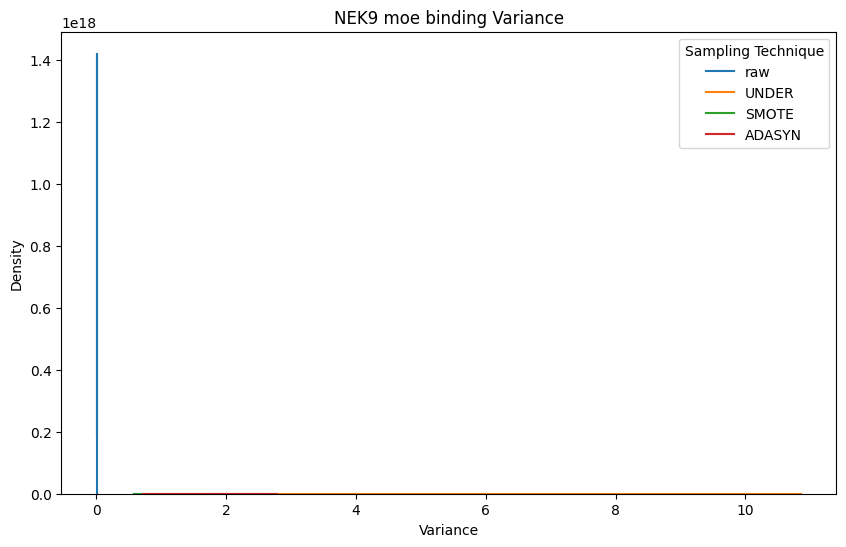

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  0.003416  1.971957  0.000001       moe   
1             0              TN  0.003416  2.508622  2.652304       moe   
2             0              TN  0.003416  1.980935  0.000001       moe   
3             0              TN  0.003416  2.005904  0.000001       moe   
4             0              TN  0.003416  2.694345  1.988149       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  0.003416  2.442577  1.807337       moe   
279           0              FN  0.003416  2.715452  0.315616       moe   
280           0              FN  0.003416  2.215717  0.000001       moe   
281           0              FN  0.003416  2.064657  1.074814       moe   
282           0              FN  0.003416  1.957333  0.903740       moe   

     prediction variance  
0               0.003416  
1               0.003416  
2               0.003416  
3               0.003416  
4               0.003416  
..                   ...  
278             0.003416  
279             0.003416  
280             0.003416  
281             0.003416  
282             0.003416  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  4.502858  4.747395  0.431536       moe   
1             1              FP  5.733377  5.892288  3.550309       moe   
2             0              TN  4.184783  4.315451  0.000001       moe   
3             0              TN  4.431579  4.542707  1.816422       moe   
4             1              FP  6.415120  6.632542  2.642115       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  5.652657  5.914649  2.516507       moe   
279           1              TP  6.396023  6.509221  1.391850       moe   
280           1              TP  5.141298  4.805426  1.972103       moe   
281           0              FN  4.375036  4.506881  2.155885       moe   
282           1              TP  4.158995  4.128592  0.796987       moe   

     prediction variance  
0               4.502858  
1               5.892288  
2               4.184783  
3               4.431579  
4               6.632542  
..                   ...  
278             5.652657  
279             6.509221  
280             4.805426  
281             4.375036  
282             4.128592  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  1.633316  1.739575  0.517519       moe   
1             0              TN  2.181535  2.608085  2.198733       moe   
2             0              TN  1.755522  1.762019  0.814827       moe   
3             0              TN  1.780780  1.820316  0.941799       moe   
4             0              TN  2.266135  2.894061  1.687796       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  2.182924  2.598460  1.602586       moe   
279           0              FN  2.256803  2.855953  0.866552       moe   
280           0              FN  1.739570  1.777057  0.908261       moe   
281           0              FN  1.789501  1.863468  1.273397       moe   
282           0              FN  1.608468  1.598182  0.891002       moe   

     prediction variance  
0               1.633316  
1               2.181535  
2               1.755522  
3               1.780780  
4               2.266135  
..                   ...  
278             2.182924  
279             2.256803  
280             1.739570  
281             1.789501  
282             1.608468  

[283 rows x 7 columns]

prediction prediction_type      var0      var1    ADdist feat_type  \
0             0              TN  1.720111  1.741731  0.525295       moe   
1             0              TN  2.310802  2.646286  2.200400       moe   
2             0              TN  1.826456  1.739716  0.821523       moe   
3             0              TN  1.858216  1.811392  0.948033       moe   
4             0              TN  2.407474  2.911971  1.691320       moe   
..          ...             ...       ...       ...       ...       ...   
278           0              FN  2.309697  2.579589  1.606419       moe   
279           0              FN  2.398037  2.870953  0.873060       moe   
280           0              FN  1.818199  1.769491  0.914618       moe   
281           0              FN  1.878286  1.879241  1.278427       moe   
282           0              FN  1.695300  1.578389  0.897421       moe   

     prediction variance  
0               1.720111  
1               2.310802  
2               1.826456  
3               1.858216  
4               2.407474  
..                   ...  
278             2.309697  
279             2.398037  
280             1.818199  
281             1.878286  
282             1.695300  

[283 rows x 7 columns]

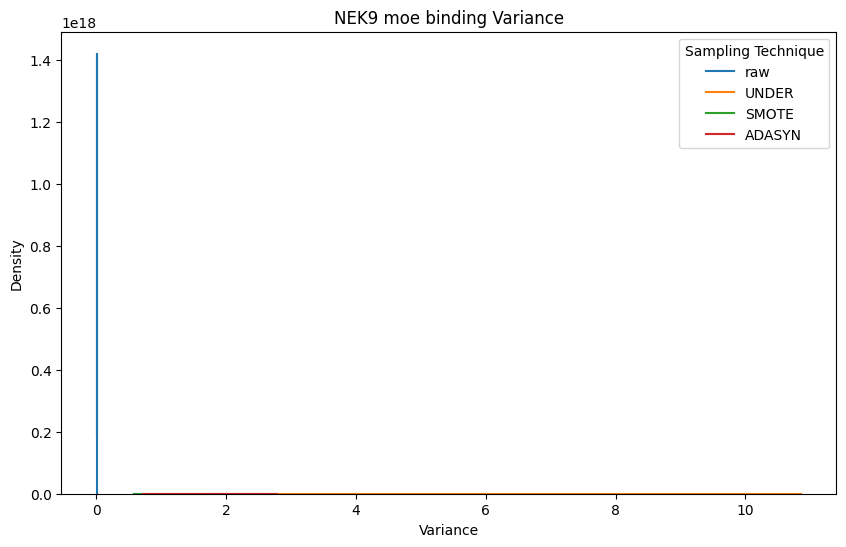

In [122]:
def layered_kde_plot(dfs, sampling_labels, title, figure_path, filename):
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dfs, sampling_labels):
        sns.kdeplot(df['prediction variance'], label=label, fill=False)
        display (df)
    plt.title(title)
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.legend(title='Sampling Technique')
    plt.show()


nek_list=['9']
for nek in nek_list:
    for feat in feat_types: 
        dfs_moe = []
        dfs_mfp = []
        labels = []
        
        for samp in samplings: 
            df_path = f'/Users/radhi/Desktop/CAPSTONE_DATA/NEK/NEK{nek}/bind/'
            full_df = pd.read_csv(f'{df_path}NEK{nek}_binding_{feat}_{samp}_df.csv') 
            train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
            test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
         
            moe_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_moe_{samp}_test_GP.csv')
            mfp_pred = pd.read_csv(f'{GPpath}NEK{nek}_binding_mfp_{samp}_test_GP.csv')
            var0_moe = moe_pred['var_pred_class0'].to_numpy()
            var1_moe = moe_pred['var_pred_class1'].to_numpy()
            var0_mfp = mfp_pred['var_pred_class0'].to_numpy()
            var1_mfp  = mfp_pred['var_pred_class1'].to_numpy()
            moe_preds = moe_pred['y_pred']
            mfp_preds = mfp_pred['y_pred']
    
            true_labels = moe_pred['y'].to_numpy()

            moe_df = pd.DataFrame({
                'prediction': moe_preds,
                'prediction_type': moe_pred['prediction_type'],
                'var0': var0_moe,
                'var1': var1_moe,
                'ADdist': test_dist
            })
            mfp_df = pd.DataFrame({
                'prediction': mfp_preds,
                'prediction_type': mfp_pred['prediction_type'],
                'var0': var0_mfp,
                'var1': var1_mfp,
                'ADdist': test_dist
            })
            moe_df['feat_type'] = 'moe'
            mfp_df['feat_type'] = 'mfp' 

            # Calculate prediction variance
            moe_df = calculate_prediction_variance(moe_df, true_labels)
            mfp_df = calculate_prediction_variance(mfp_df, true_labels)

            # Collect DataFrames and labels for layered KDE plot
            dfs_moe.append(moe_df)
            dfs_mfp.append(mfp_df)
            labels.append(samp if samp != 'scaled' else 'raw')
        
        # Create layered KDE plots for variance after the loop populates dfs and labels
        layered_kde_plot(dfs_moe, labels, f'NEK{nek} moe binding Variance', figure_path, f'NEK{nek}_binding_moe_variance_kde')
        #layered_kde_plot(dfs_mfp, labels, f'NEK{nek} mfp binding Variance', figure_path, f'NEK{nek}_binding_mfp_variance_kde')
